# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [50]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

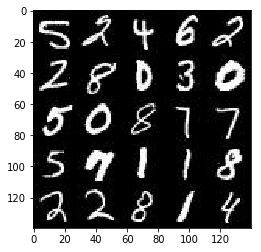

In [62]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

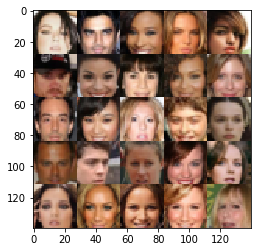

In [63]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [64]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.4.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [65]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='real_input')
    z_input = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    learning_rate = tf.placeholder(tf.float32, [], name='learning_rate')
    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [113]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha=0.08
        
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=1, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 7x7x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [114]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        alpha=0.08
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x128 now

        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=1, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        # 28x28x64 now

        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=1, padding='same')
        # 28x28xout_channel_dim now
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [115]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    alpha = 0.08
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [116]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [117]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [118]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    if data_image_mode == "RGB":
        out_channel_dim = 3
    else:
        out_channel_dim = 1

    real_input, z_input, learning_rate_tensor = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

    d_loss, g_loss = model_loss(real_input, z_input, out_channel_dim)

    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)

    steps = 0
    print_every = 50
    show_every = 200

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                batch_images *= 2
                
                steps += 1

                # Sample random noise for Generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={real_input: batch_images, z_input: batch_z,
                                               learning_rate_tensor: learning_rate})
                _ = sess.run(g_opt, feed_dict={real_input: batch_images, z_input: batch_z, learning_rate_tensor: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({z_input: batch_z, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 3, z_input, out_channel_dim, data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/10... Discriminator Loss: 1.5170... Generator Loss: 0.6841
Epoch 1/10... Discriminator Loss: 1.8032... Generator Loss: 0.4251
Epoch 1/10... Discriminator Loss: 1.4091... Generator Loss: 0.5416
Epoch 1/10... Discriminator Loss: 1.2822... Generator Loss: 0.6743


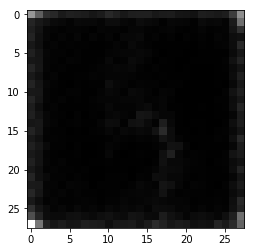

Epoch 1/10... Discriminator Loss: 1.2747... Generator Loss: 0.6570
Epoch 1/10... Discriminator Loss: 1.3308... Generator Loss: 0.6051
Epoch 1/10... Discriminator Loss: 1.1892... Generator Loss: 0.8301
Epoch 1/10... Discriminator Loss: 1.1276... Generator Loss: 1.2103


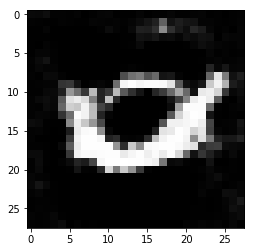

Epoch 1/10... Discriminator Loss: 1.4089... Generator Loss: 0.5030
Epoch 1/10... Discriminator Loss: 1.3877... Generator Loss: 1.3542
Epoch 1/10... Discriminator Loss: 1.4458... Generator Loss: 0.4663
Epoch 1/10... Discriminator Loss: 1.3722... Generator Loss: 0.5614


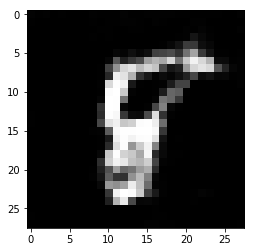

Epoch 1/10... Discriminator Loss: 1.3569... Generator Loss: 0.5724
Epoch 1/10... Discriminator Loss: 1.1951... Generator Loss: 1.1085
Epoch 1/10... Discriminator Loss: 1.0538... Generator Loss: 0.9057
Epoch 1/10... Discriminator Loss: 1.3445... Generator Loss: 0.5873


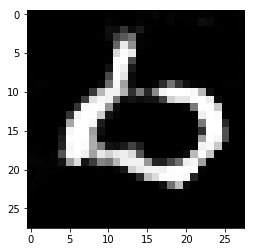

Epoch 1/10... Discriminator Loss: 1.2790... Generator Loss: 1.2176
Epoch 1/10... Discriminator Loss: 1.2355... Generator Loss: 0.7864
Epoch 2/10... Discriminator Loss: 1.5896... Generator Loss: 0.4378
Epoch 2/10... Discriminator Loss: 1.3889... Generator Loss: 0.5462


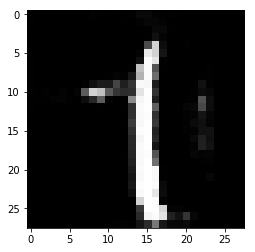

Epoch 2/10... Discriminator Loss: 1.1714... Generator Loss: 0.9642
Epoch 2/10... Discriminator Loss: 1.2297... Generator Loss: 0.7640
Epoch 2/10... Discriminator Loss: 1.2247... Generator Loss: 0.7290
Epoch 2/10... Discriminator Loss: 1.1331... Generator Loss: 1.1285


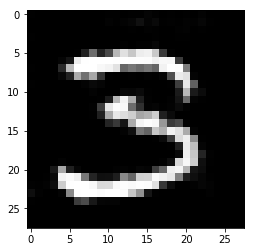

Epoch 2/10... Discriminator Loss: 1.5420... Generator Loss: 1.9580
Epoch 2/10... Discriminator Loss: 1.0864... Generator Loss: 1.2879
Epoch 2/10... Discriminator Loss: 1.0862... Generator Loss: 0.9164
Epoch 2/10... Discriminator Loss: 1.4158... Generator Loss: 0.4987


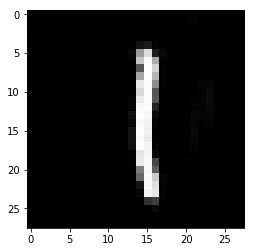

Epoch 2/10... Discriminator Loss: 1.0530... Generator Loss: 1.3398
Epoch 2/10... Discriminator Loss: 1.1328... Generator Loss: 0.8135
Epoch 2/10... Discriminator Loss: 1.3694... Generator Loss: 0.5790
Epoch 2/10... Discriminator Loss: 0.9758... Generator Loss: 1.2074


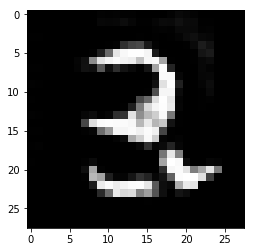

Epoch 2/10... Discriminator Loss: 1.9516... Generator Loss: 0.2827
Epoch 2/10... Discriminator Loss: 1.1556... Generator Loss: 0.8537
Epoch 2/10... Discriminator Loss: 1.0421... Generator Loss: 1.1751
Epoch 2/10... Discriminator Loss: 1.1536... Generator Loss: 0.8036


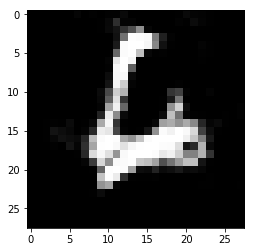

Epoch 2/10... Discriminator Loss: 1.0857... Generator Loss: 1.0183
Epoch 3/10... Discriminator Loss: 1.0702... Generator Loss: 1.1603
Epoch 3/10... Discriminator Loss: 1.0678... Generator Loss: 0.9048
Epoch 3/10... Discriminator Loss: 1.1783... Generator Loss: 0.9906


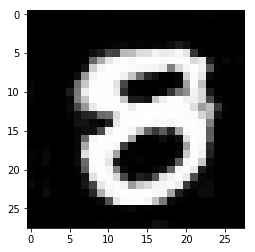

Epoch 3/10... Discriminator Loss: 1.1964... Generator Loss: 0.7854
Epoch 3/10... Discriminator Loss: 1.1443... Generator Loss: 1.4032
Epoch 3/10... Discriminator Loss: 1.0894... Generator Loss: 0.7501
Epoch 3/10... Discriminator Loss: 1.0636... Generator Loss: 1.1219


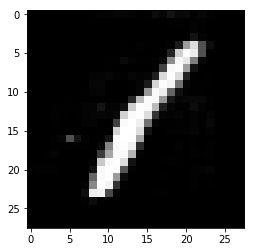

Epoch 3/10... Discriminator Loss: 1.1216... Generator Loss: 0.8260
Epoch 3/10... Discriminator Loss: 1.1717... Generator Loss: 0.8191
Epoch 3/10... Discriminator Loss: 1.0989... Generator Loss: 1.0846
Epoch 3/10... Discriminator Loss: 1.1153... Generator Loss: 1.0075


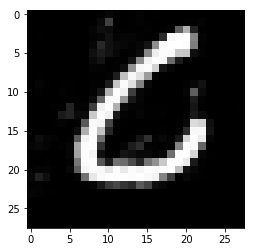

Epoch 3/10... Discriminator Loss: 1.2384... Generator Loss: 0.7262
Epoch 3/10... Discriminator Loss: 1.3166... Generator Loss: 0.5865
Epoch 3/10... Discriminator Loss: 1.1322... Generator Loss: 0.8646
Epoch 3/10... Discriminator Loss: 1.1432... Generator Loss: 0.7747


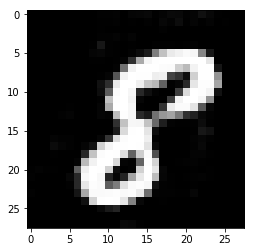

Epoch 3/10... Discriminator Loss: 1.2269... Generator Loss: 0.9493
Epoch 3/10... Discriminator Loss: 1.3606... Generator Loss: 0.5722
Epoch 3/10... Discriminator Loss: 1.7044... Generator Loss: 0.3647
Epoch 3/10... Discriminator Loss: 1.1899... Generator Loss: 0.7435


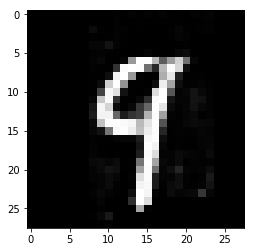

Epoch 4/10... Discriminator Loss: 1.1833... Generator Loss: 0.8392
Epoch 4/10... Discriminator Loss: 1.2150... Generator Loss: 0.7619
Epoch 4/10... Discriminator Loss: 1.3433... Generator Loss: 0.5688
Epoch 4/10... Discriminator Loss: 1.2013... Generator Loss: 0.9979


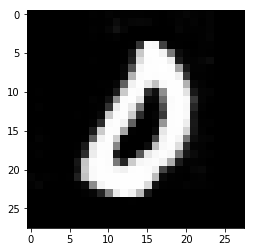

Epoch 4/10... Discriminator Loss: 1.0689... Generator Loss: 1.1164
Epoch 4/10... Discriminator Loss: 1.2296... Generator Loss: 0.6995
Epoch 4/10... Discriminator Loss: 1.0912... Generator Loss: 1.0225
Epoch 4/10... Discriminator Loss: 1.1029... Generator Loss: 0.9426


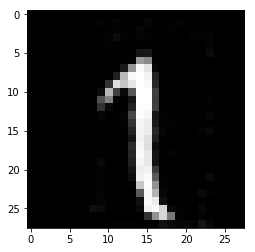

Epoch 4/10... Discriminator Loss: 1.0837... Generator Loss: 0.8078
Epoch 4/10... Discriminator Loss: 1.2071... Generator Loss: 0.6848
Epoch 4/10... Discriminator Loss: 1.3458... Generator Loss: 0.6498
Epoch 4/10... Discriminator Loss: 1.1731... Generator Loss: 0.8520


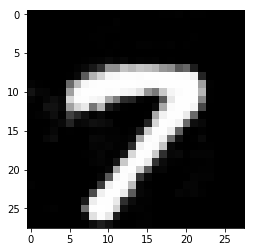

Epoch 4/10... Discriminator Loss: 1.1890... Generator Loss: 0.7098
Epoch 4/10... Discriminator Loss: 1.0895... Generator Loss: 0.8310
Epoch 4/10... Discriminator Loss: 1.0880... Generator Loss: 1.2629
Epoch 4/10... Discriminator Loss: 1.1027... Generator Loss: 0.8049


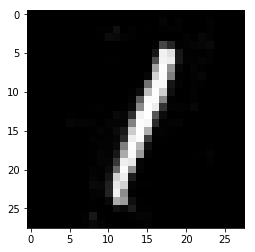

Epoch 4/10... Discriminator Loss: 1.2666... Generator Loss: 1.2334
Epoch 4/10... Discriminator Loss: 0.9906... Generator Loss: 1.1243
Epoch 5/10... Discriminator Loss: 1.2500... Generator Loss: 0.6512
Epoch 5/10... Discriminator Loss: 1.2220... Generator Loss: 0.6510


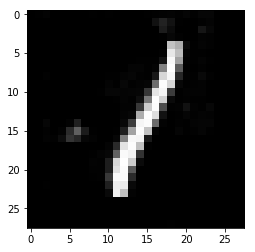

Epoch 5/10... Discriminator Loss: 1.1499... Generator Loss: 1.0070
Epoch 5/10... Discriminator Loss: 1.0448... Generator Loss: 1.3107
Epoch 5/10... Discriminator Loss: 1.1950... Generator Loss: 0.7692
Epoch 5/10... Discriminator Loss: 1.4205... Generator Loss: 0.5575


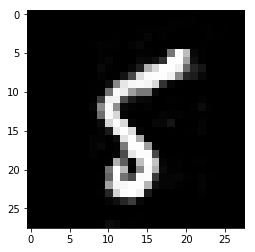

Epoch 5/10... Discriminator Loss: 1.2315... Generator Loss: 1.0934
Epoch 5/10... Discriminator Loss: 1.0647... Generator Loss: 0.9729
Epoch 5/10... Discriminator Loss: 1.0207... Generator Loss: 1.1158
Epoch 5/10... Discriminator Loss: 1.2143... Generator Loss: 0.7693


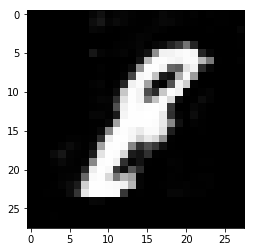

Epoch 5/10... Discriminator Loss: 1.0659... Generator Loss: 0.9706
Epoch 5/10... Discriminator Loss: 1.2322... Generator Loss: 0.8942
Epoch 5/10... Discriminator Loss: 1.0482... Generator Loss: 1.0395
Epoch 5/10... Discriminator Loss: 1.2125... Generator Loss: 0.7042


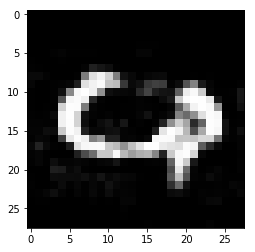

Epoch 5/10... Discriminator Loss: 1.1979... Generator Loss: 0.9866
Epoch 5/10... Discriminator Loss: 1.0745... Generator Loss: 0.8627
Epoch 5/10... Discriminator Loss: 1.2526... Generator Loss: 0.6949
Epoch 5/10... Discriminator Loss: 1.1165... Generator Loss: 1.4222


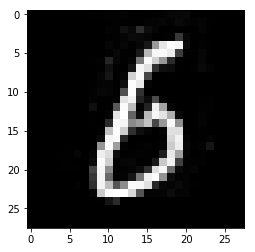

Epoch 5/10... Discriminator Loss: 1.3477... Generator Loss: 0.7154
Epoch 6/10... Discriminator Loss: 1.0406... Generator Loss: 1.2777
Epoch 6/10... Discriminator Loss: 1.3339... Generator Loss: 0.6701
Epoch 6/10... Discriminator Loss: 1.0219... Generator Loss: 1.5194


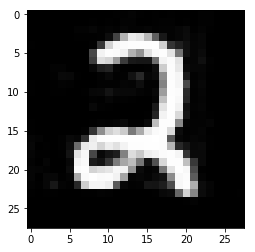

Epoch 6/10... Discriminator Loss: 1.1010... Generator Loss: 0.8336
Epoch 6/10... Discriminator Loss: 1.0521... Generator Loss: 1.0400
Epoch 6/10... Discriminator Loss: 1.0901... Generator Loss: 1.0519
Epoch 6/10... Discriminator Loss: 1.2431... Generator Loss: 0.7652


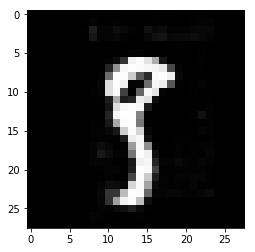

Epoch 6/10... Discriminator Loss: 1.0915... Generator Loss: 1.1023
Epoch 6/10... Discriminator Loss: 0.9888... Generator Loss: 1.4079
Epoch 6/10... Discriminator Loss: 1.0120... Generator Loss: 0.9966
Epoch 6/10... Discriminator Loss: 1.1530... Generator Loss: 1.1501


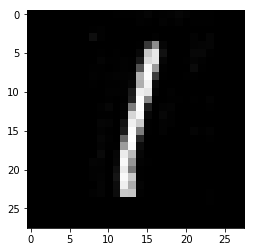

Epoch 6/10... Discriminator Loss: 1.1830... Generator Loss: 0.7320
Epoch 6/10... Discriminator Loss: 1.1590... Generator Loss: 0.7718
Epoch 6/10... Discriminator Loss: 1.0346... Generator Loss: 1.4463
Epoch 6/10... Discriminator Loss: 1.2369... Generator Loss: 0.8369


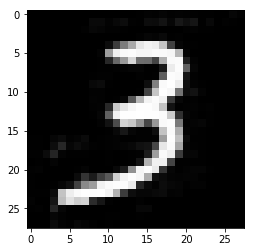

Epoch 6/10... Discriminator Loss: 1.0818... Generator Loss: 1.1699
Epoch 6/10... Discriminator Loss: 1.1065... Generator Loss: 1.0139
Epoch 6/10... Discriminator Loss: 1.1552... Generator Loss: 0.7645
Epoch 6/10... Discriminator Loss: 1.1449... Generator Loss: 0.8068


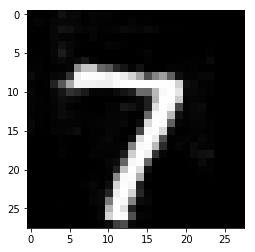

Epoch 7/10... Discriminator Loss: 1.0965... Generator Loss: 0.9629
Epoch 7/10... Discriminator Loss: 1.1515... Generator Loss: 0.7634
Epoch 7/10... Discriminator Loss: 1.3020... Generator Loss: 0.6389
Epoch 7/10... Discriminator Loss: 1.3822... Generator Loss: 0.5898


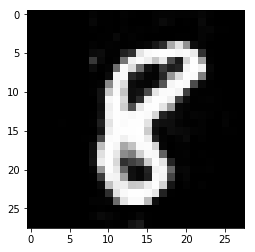

Epoch 7/10... Discriminator Loss: 1.1888... Generator Loss: 0.7902
Epoch 7/10... Discriminator Loss: 1.1793... Generator Loss: 0.9285
Epoch 7/10... Discriminator Loss: 1.0742... Generator Loss: 0.8948
Epoch 7/10... Discriminator Loss: 1.2349... Generator Loss: 0.8331


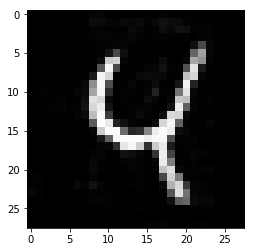

Epoch 7/10... Discriminator Loss: 1.0488... Generator Loss: 1.2926
Epoch 7/10... Discriminator Loss: 1.2186... Generator Loss: 0.6574
Epoch 7/10... Discriminator Loss: 1.0143... Generator Loss: 1.4278
Epoch 7/10... Discriminator Loss: 1.1401... Generator Loss: 0.8378


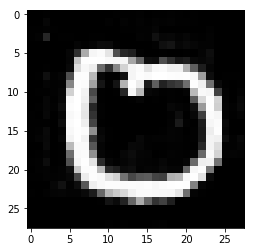

Epoch 7/10... Discriminator Loss: 1.1813... Generator Loss: 1.2599
Epoch 7/10... Discriminator Loss: 1.1517... Generator Loss: 1.1785
Epoch 7/10... Discriminator Loss: 1.0993... Generator Loss: 0.8277
Epoch 7/10... Discriminator Loss: 1.4530... Generator Loss: 0.5416


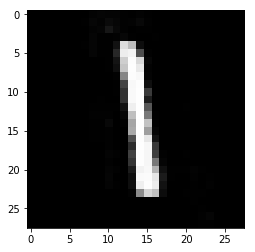

Epoch 7/10... Discriminator Loss: 1.0721... Generator Loss: 0.8003
Epoch 7/10... Discriminator Loss: 1.2038... Generator Loss: 1.1775
Epoch 7/10... Discriminator Loss: 1.0544... Generator Loss: 0.9344
Epoch 8/10... Discriminator Loss: 1.1875... Generator Loss: 0.7698


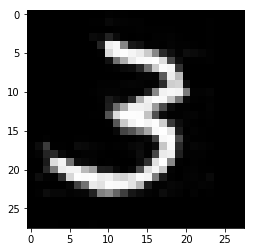

Epoch 8/10... Discriminator Loss: 1.1423... Generator Loss: 1.1061
Epoch 8/10... Discriminator Loss: 1.2416... Generator Loss: 1.4457
Epoch 8/10... Discriminator Loss: 1.3618... Generator Loss: 0.5760
Epoch 8/10... Discriminator Loss: 1.4901... Generator Loss: 0.5498


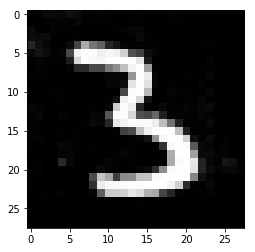

Epoch 8/10... Discriminator Loss: 1.1107... Generator Loss: 0.7998
Epoch 8/10... Discriminator Loss: 1.0789... Generator Loss: 1.5235
Epoch 8/10... Discriminator Loss: 1.2512... Generator Loss: 0.6589
Epoch 8/10... Discriminator Loss: 1.2709... Generator Loss: 0.6820


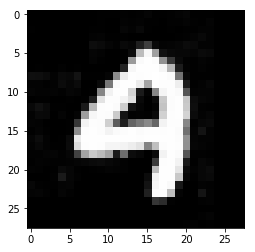

Epoch 8/10... Discriminator Loss: 1.1233... Generator Loss: 1.5622
Epoch 8/10... Discriminator Loss: 1.1913... Generator Loss: 0.7953
Epoch 8/10... Discriminator Loss: 1.1398... Generator Loss: 0.9903
Epoch 8/10... Discriminator Loss: 1.2915... Generator Loss: 0.7305


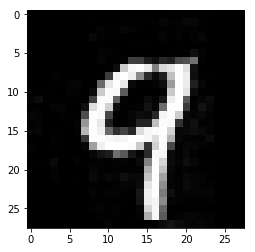

Epoch 8/10... Discriminator Loss: 1.5503... Generator Loss: 0.4314
Epoch 8/10... Discriminator Loss: 1.2769... Generator Loss: 0.6409
Epoch 8/10... Discriminator Loss: 1.4694... Generator Loss: 0.4872
Epoch 8/10... Discriminator Loss: 1.0511... Generator Loss: 1.1590


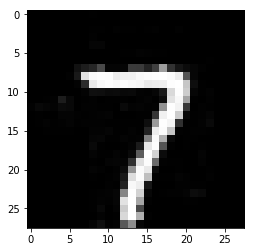

Epoch 8/10... Discriminator Loss: 0.9702... Generator Loss: 1.0951
Epoch 9/10... Discriminator Loss: 1.1301... Generator Loss: 0.9273
Epoch 9/10... Discriminator Loss: 1.1070... Generator Loss: 0.8847
Epoch 9/10... Discriminator Loss: 1.2137... Generator Loss: 1.3566


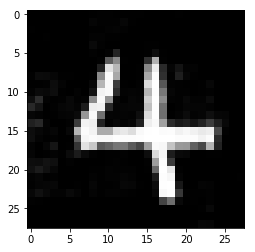

Epoch 9/10... Discriminator Loss: 1.0602... Generator Loss: 1.1652
Epoch 9/10... Discriminator Loss: 0.9504... Generator Loss: 1.0791
Epoch 9/10... Discriminator Loss: 0.9770... Generator Loss: 1.4740
Epoch 9/10... Discriminator Loss: 1.0554... Generator Loss: 1.0330


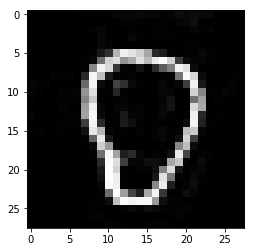

Epoch 9/10... Discriminator Loss: 1.4292... Generator Loss: 0.4778
Epoch 9/10... Discriminator Loss: 0.9829... Generator Loss: 1.0997
Epoch 9/10... Discriminator Loss: 1.0505... Generator Loss: 1.1653
Epoch 9/10... Discriminator Loss: 1.0991... Generator Loss: 1.1429


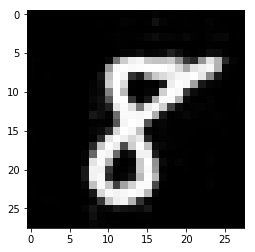

Epoch 9/10... Discriminator Loss: 1.0751... Generator Loss: 0.8822
Epoch 9/10... Discriminator Loss: 1.1586... Generator Loss: 1.2360
Epoch 9/10... Discriminator Loss: 1.2305... Generator Loss: 1.4153
Epoch 9/10... Discriminator Loss: 1.2176... Generator Loss: 0.6909


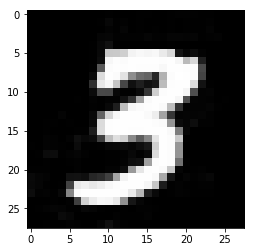

Epoch 9/10... Discriminator Loss: 1.3059... Generator Loss: 0.6559
Epoch 9/10... Discriminator Loss: 1.1144... Generator Loss: 1.4511
Epoch 9/10... Discriminator Loss: 1.0986... Generator Loss: 1.0301
Epoch 9/10... Discriminator Loss: 1.0309... Generator Loss: 1.1949


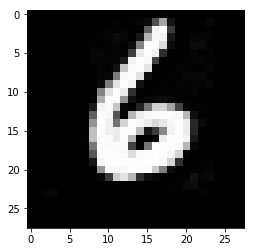

Epoch 10/10... Discriminator Loss: 0.9825... Generator Loss: 1.0689
Epoch 10/10... Discriminator Loss: 1.0658... Generator Loss: 1.1569
Epoch 10/10... Discriminator Loss: 1.0213... Generator Loss: 1.0813
Epoch 10/10... Discriminator Loss: 1.4272... Generator Loss: 0.5293


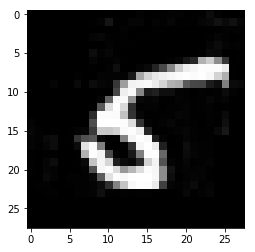

Epoch 10/10... Discriminator Loss: 1.2046... Generator Loss: 0.6781
Epoch 10/10... Discriminator Loss: 1.0813... Generator Loss: 1.4530
Epoch 10/10... Discriminator Loss: 1.1585... Generator Loss: 0.7796
Epoch 10/10... Discriminator Loss: 1.0780... Generator Loss: 1.3141


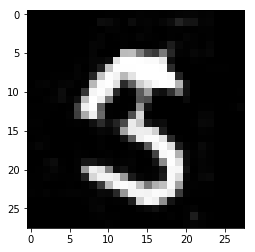

Epoch 10/10... Discriminator Loss: 1.5198... Generator Loss: 0.4577
Epoch 10/10... Discriminator Loss: 1.1883... Generator Loss: 0.7167
Epoch 10/10... Discriminator Loss: 1.0885... Generator Loss: 0.9545
Epoch 10/10... Discriminator Loss: 1.5935... Generator Loss: 0.4005


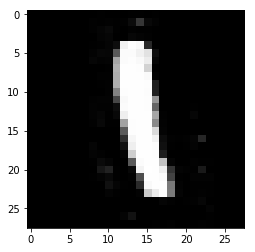

Epoch 10/10... Discriminator Loss: 1.2114... Generator Loss: 0.7169
Epoch 10/10... Discriminator Loss: 1.4005... Generator Loss: 0.5069
Epoch 10/10... Discriminator Loss: 1.2091... Generator Loss: 0.8405
Epoch 10/10... Discriminator Loss: 1.0385... Generator Loss: 0.9435


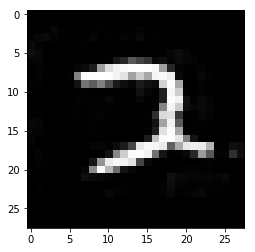

Epoch 10/10... Discriminator Loss: 1.0782... Generator Loss: 1.2012
Epoch 10/10... Discriminator Loss: 0.9876... Generator Loss: 1.2224
Epoch 10/10... Discriminator Loss: 1.0288... Generator Loss: 1.0608


In [119]:
batch_size = 64 # between 32 or 64
z_dim = 100
learning_rate = 0.0002 # between 0.0002 and 0.0008
beta1 = 0.4 # between 0.2 and 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 10

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/25... Discriminator Loss: 1.3403... Generator Loss: 0.9898
Epoch 1/25... Discriminator Loss: 1.1225... Generator Loss: 3.4285
Epoch 1/25... Discriminator Loss: 1.1390... Generator Loss: 0.7638
Epoch 1/25... Discriminator Loss: 0.9551... Generator Loss: 3.4814


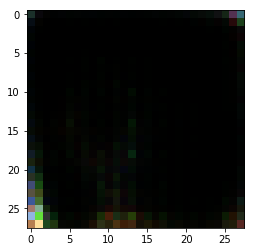

Epoch 1/25... Discriminator Loss: 1.3484... Generator Loss: 0.6335
Epoch 1/25... Discriminator Loss: 0.9994... Generator Loss: 1.2041
Epoch 1/25... Discriminator Loss: 0.7760... Generator Loss: 1.9864
Epoch 1/25... Discriminator Loss: 1.4019... Generator Loss: 0.6975


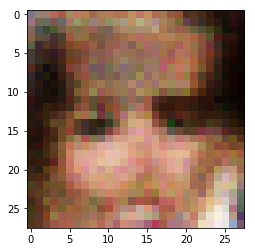

Epoch 1/25... Discriminator Loss: 1.0489... Generator Loss: 0.9827
Epoch 1/25... Discriminator Loss: 0.9621... Generator Loss: 1.1632
Epoch 1/25... Discriminator Loss: 1.2585... Generator Loss: 0.6984
Epoch 1/25... Discriminator Loss: 1.3316... Generator Loss: 0.7026


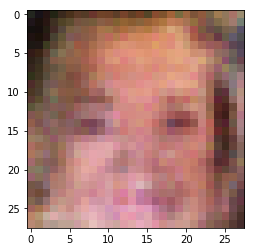

Epoch 1/25... Discriminator Loss: 1.1226... Generator Loss: 3.4715
Epoch 1/25... Discriminator Loss: 0.8932... Generator Loss: 1.9070
Epoch 1/25... Discriminator Loss: 1.2213... Generator Loss: 0.8935
Epoch 1/25... Discriminator Loss: 1.5383... Generator Loss: 0.4274


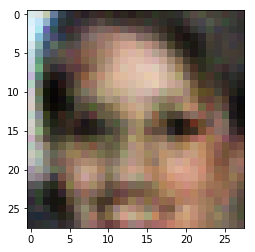

Epoch 1/25... Discriminator Loss: 1.1897... Generator Loss: 1.0161
Epoch 1/25... Discriminator Loss: 1.8349... Generator Loss: 0.2790
Epoch 1/25... Discriminator Loss: 1.0891... Generator Loss: 1.7124
Epoch 1/25... Discriminator Loss: 1.3559... Generator Loss: 1.5894


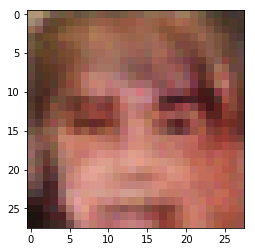

Epoch 1/25... Discriminator Loss: 1.4585... Generator Loss: 1.7498
Epoch 1/25... Discriminator Loss: 1.2411... Generator Loss: 0.7295
Epoch 1/25... Discriminator Loss: 1.1439... Generator Loss: 1.2597
Epoch 1/25... Discriminator Loss: 1.5688... Generator Loss: 0.3952


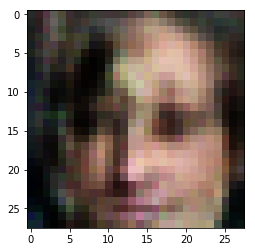

Epoch 1/25... Discriminator Loss: 1.2179... Generator Loss: 0.6761
Epoch 1/25... Discriminator Loss: 1.2891... Generator Loss: 1.7806
Epoch 1/25... Discriminator Loss: 0.7772... Generator Loss: 1.5181
Epoch 1/25... Discriminator Loss: 1.3275... Generator Loss: 0.7083


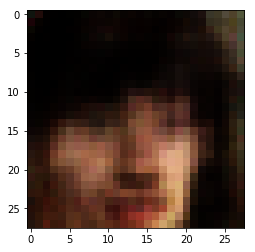

Epoch 1/25... Discriminator Loss: 1.2779... Generator Loss: 0.7680
Epoch 1/25... Discriminator Loss: 1.3275... Generator Loss: 0.7035
Epoch 1/25... Discriminator Loss: 1.3715... Generator Loss: 0.7566
Epoch 1/25... Discriminator Loss: 1.2991... Generator Loss: 0.8321


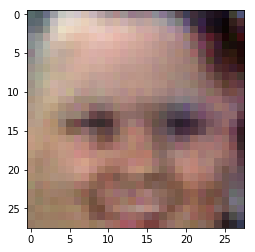

Epoch 1/25... Discriminator Loss: 1.3110... Generator Loss: 0.7497
Epoch 1/25... Discriminator Loss: 1.2828... Generator Loss: 0.6725
Epoch 1/25... Discriminator Loss: 1.5559... Generator Loss: 0.4223
Epoch 1/25... Discriminator Loss: 1.0762... Generator Loss: 1.3994


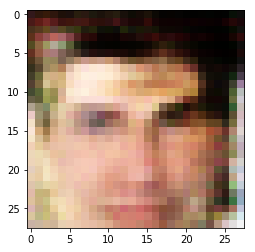

Epoch 1/25... Discriminator Loss: 1.1535... Generator Loss: 0.7474
Epoch 1/25... Discriminator Loss: 1.5053... Generator Loss: 0.4654
Epoch 1/25... Discriminator Loss: 1.2276... Generator Loss: 1.3792
Epoch 1/25... Discriminator Loss: 1.2236... Generator Loss: 1.0235


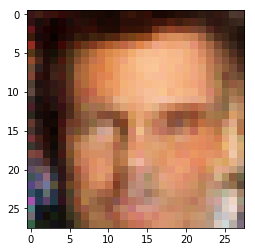

Epoch 1/25... Discriminator Loss: 1.0007... Generator Loss: 1.1201
Epoch 1/25... Discriminator Loss: 1.2712... Generator Loss: 0.7431
Epoch 1/25... Discriminator Loss: 1.1352... Generator Loss: 0.7933
Epoch 1/25... Discriminator Loss: 0.9151... Generator Loss: 2.0804


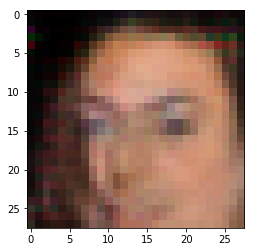

Epoch 1/25... Discriminator Loss: 1.3797... Generator Loss: 0.5601
Epoch 1/25... Discriminator Loss: 1.1997... Generator Loss: 2.3928
Epoch 1/25... Discriminator Loss: 1.3672... Generator Loss: 0.6229
Epoch 1/25... Discriminator Loss: 1.4954... Generator Loss: 1.0898


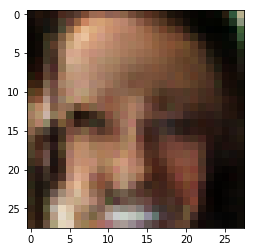

Epoch 1/25... Discriminator Loss: 1.1470... Generator Loss: 0.9461
Epoch 1/25... Discriminator Loss: 1.5604... Generator Loss: 0.6315
Epoch 1/25... Discriminator Loss: 1.2532... Generator Loss: 0.8917
Epoch 1/25... Discriminator Loss: 1.3685... Generator Loss: 0.6110


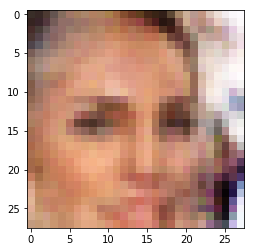

Epoch 1/25... Discriminator Loss: 1.6393... Generator Loss: 0.4013
Epoch 1/25... Discriminator Loss: 1.1516... Generator Loss: 1.1325
Epoch 1/25... Discriminator Loss: 1.4324... Generator Loss: 0.5580
Epoch 1/25... Discriminator Loss: 1.3738... Generator Loss: 0.8921


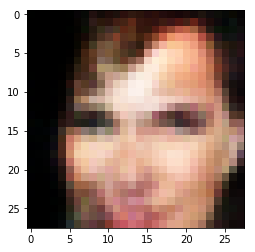

Epoch 1/25... Discriminator Loss: 1.2895... Generator Loss: 0.6863
Epoch 1/25... Discriminator Loss: 1.5106... Generator Loss: 0.6251
Epoch 1/25... Discriminator Loss: 1.0409... Generator Loss: 1.5389
Epoch 1/25... Discriminator Loss: 1.3057... Generator Loss: 0.6716


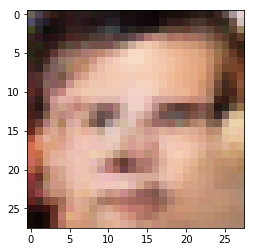

Epoch 1/25... Discriminator Loss: 1.6529... Generator Loss: 0.3610
Epoch 1/25... Discriminator Loss: 1.3452... Generator Loss: 0.7037
Epoch 1/25... Discriminator Loss: 1.5071... Generator Loss: 1.6575
Epoch 2/25... Discriminator Loss: 1.2708... Generator Loss: 0.8553


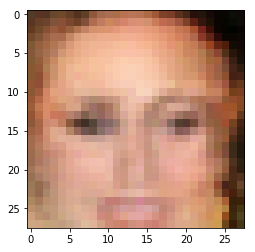

Epoch 2/25... Discriminator Loss: 1.3499... Generator Loss: 0.7892
Epoch 2/25... Discriminator Loss: 1.2480... Generator Loss: 0.8293
Epoch 2/25... Discriminator Loss: 1.3362... Generator Loss: 0.6795
Epoch 2/25... Discriminator Loss: 1.2781... Generator Loss: 0.6824


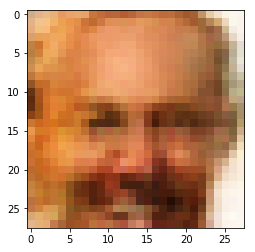

Epoch 2/25... Discriminator Loss: 1.3731... Generator Loss: 0.6776
Epoch 2/25... Discriminator Loss: 1.3133... Generator Loss: 0.6598
Epoch 2/25... Discriminator Loss: 1.5921... Generator Loss: 0.4076
Epoch 2/25... Discriminator Loss: 1.3631... Generator Loss: 0.7954


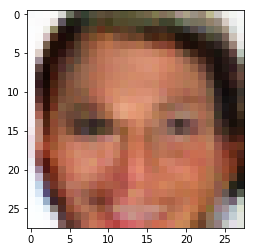

Epoch 2/25... Discriminator Loss: 1.3079... Generator Loss: 0.7643
Epoch 2/25... Discriminator Loss: 1.1794... Generator Loss: 1.2046
Epoch 2/25... Discriminator Loss: 1.2841... Generator Loss: 0.9040
Epoch 2/25... Discriminator Loss: 1.2469... Generator Loss: 0.9336


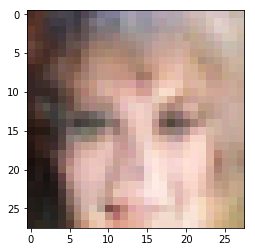

Epoch 2/25... Discriminator Loss: 1.3770... Generator Loss: 0.7277
Epoch 2/25... Discriminator Loss: 1.4733... Generator Loss: 0.5286
Epoch 2/25... Discriminator Loss: 1.1837... Generator Loss: 1.3062
Epoch 2/25... Discriminator Loss: 1.3382... Generator Loss: 0.6925


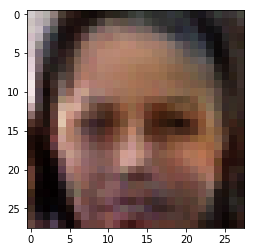

Epoch 2/25... Discriminator Loss: 1.5327... Generator Loss: 1.0190
Epoch 2/25... Discriminator Loss: 1.4269... Generator Loss: 0.6035
Epoch 2/25... Discriminator Loss: 1.4635... Generator Loss: 0.4807
Epoch 2/25... Discriminator Loss: 1.2125... Generator Loss: 1.1653


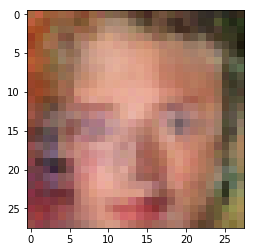

Epoch 2/25... Discriminator Loss: 1.3558... Generator Loss: 0.6753
Epoch 2/25... Discriminator Loss: 1.4288... Generator Loss: 0.5911
Epoch 2/25... Discriminator Loss: 0.9952... Generator Loss: 1.8101
Epoch 2/25... Discriminator Loss: 1.3634... Generator Loss: 0.5942


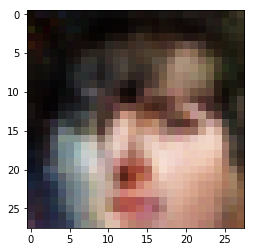

Epoch 2/25... Discriminator Loss: 1.3881... Generator Loss: 1.2868
Epoch 2/25... Discriminator Loss: 1.2674... Generator Loss: 0.8084
Epoch 2/25... Discriminator Loss: 1.3962... Generator Loss: 1.0744
Epoch 2/25... Discriminator Loss: 1.3019... Generator Loss: 1.0094


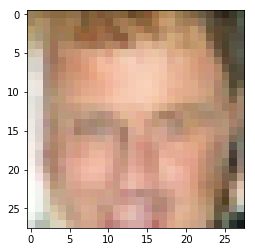

Epoch 2/25... Discriminator Loss: 1.3123... Generator Loss: 0.7632
Epoch 2/25... Discriminator Loss: 1.1811... Generator Loss: 1.0063
Epoch 2/25... Discriminator Loss: 1.4237... Generator Loss: 0.5234
Epoch 2/25... Discriminator Loss: 1.3748... Generator Loss: 0.8606


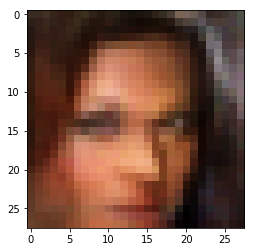

Epoch 2/25... Discriminator Loss: 1.5706... Generator Loss: 0.4571
Epoch 2/25... Discriminator Loss: 1.3720... Generator Loss: 0.6599
Epoch 2/25... Discriminator Loss: 1.3139... Generator Loss: 0.5873
Epoch 2/25... Discriminator Loss: 1.2639... Generator Loss: 0.8733


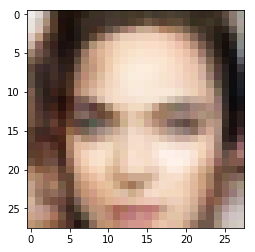

Epoch 2/25... Discriminator Loss: 1.3861... Generator Loss: 0.6183
Epoch 2/25... Discriminator Loss: 1.3695... Generator Loss: 0.8675
Epoch 2/25... Discriminator Loss: 1.4908... Generator Loss: 0.5994
Epoch 2/25... Discriminator Loss: 1.3829... Generator Loss: 0.6471


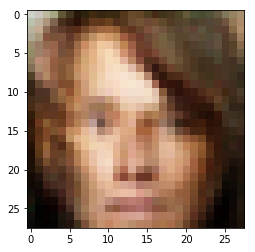

Epoch 2/25... Discriminator Loss: 1.3107... Generator Loss: 0.8469
Epoch 2/25... Discriminator Loss: 1.4124... Generator Loss: 0.8267
Epoch 2/25... Discriminator Loss: 1.5724... Generator Loss: 1.0374
Epoch 2/25... Discriminator Loss: 1.5077... Generator Loss: 0.5516


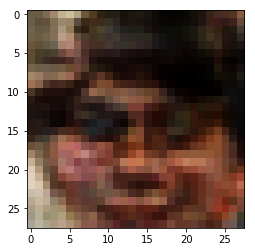

Epoch 2/25... Discriminator Loss: 1.3282... Generator Loss: 0.7689
Epoch 2/25... Discriminator Loss: 1.4379... Generator Loss: 0.5533
Epoch 2/25... Discriminator Loss: 1.4200... Generator Loss: 0.6772
Epoch 2/25... Discriminator Loss: 1.3568... Generator Loss: 0.7525


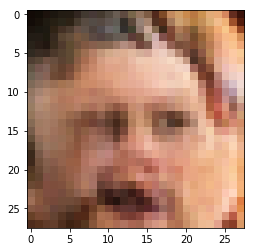

Epoch 2/25... Discriminator Loss: 1.3079... Generator Loss: 0.6885
Epoch 2/25... Discriminator Loss: 1.5197... Generator Loss: 0.5885
Epoch 2/25... Discriminator Loss: 1.4842... Generator Loss: 0.4933
Epoch 2/25... Discriminator Loss: 1.3319... Generator Loss: 0.6863


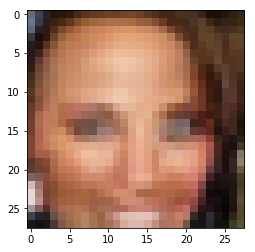

Epoch 2/25... Discriminator Loss: 1.4642... Generator Loss: 0.5199
Epoch 2/25... Discriminator Loss: 1.4055... Generator Loss: 0.5820
Epoch 2/25... Discriminator Loss: 1.4425... Generator Loss: 0.5753
Epoch 2/25... Discriminator Loss: 1.4719... Generator Loss: 0.5127


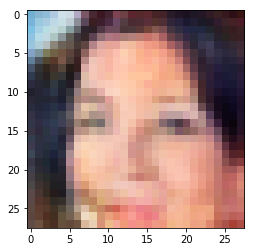

Epoch 2/25... Discriminator Loss: 1.4748... Generator Loss: 0.8754
Epoch 2/25... Discriminator Loss: 1.4557... Generator Loss: 0.7107
Epoch 2/25... Discriminator Loss: 1.3426... Generator Loss: 0.6785
Epoch 2/25... Discriminator Loss: 1.6518... Generator Loss: 0.9130


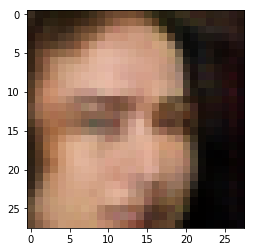

Epoch 2/25... Discriminator Loss: 1.3869... Generator Loss: 1.0171
Epoch 2/25... Discriminator Loss: 1.2565... Generator Loss: 0.7445
Epoch 3/25... Discriminator Loss: 1.3689... Generator Loss: 1.0506
Epoch 3/25... Discriminator Loss: 1.3889... Generator Loss: 0.6185


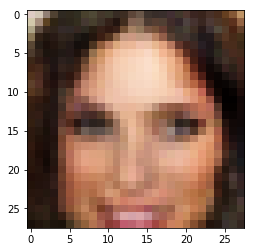

Epoch 3/25... Discriminator Loss: 1.5710... Generator Loss: 0.8907
Epoch 3/25... Discriminator Loss: 1.4796... Generator Loss: 0.5715
Epoch 3/25... Discriminator Loss: 1.4625... Generator Loss: 0.5708
Epoch 3/25... Discriminator Loss: 1.6590... Generator Loss: 0.5927


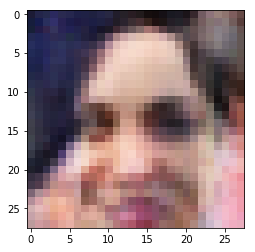

Epoch 3/25... Discriminator Loss: 1.3692... Generator Loss: 1.0738
Epoch 3/25... Discriminator Loss: 1.3080... Generator Loss: 0.7716
Epoch 3/25... Discriminator Loss: 1.3099... Generator Loss: 0.6683
Epoch 3/25... Discriminator Loss: 1.2237... Generator Loss: 0.8945


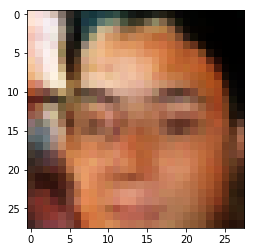

Epoch 3/25... Discriminator Loss: 1.3149... Generator Loss: 0.7315
Epoch 3/25... Discriminator Loss: 1.2660... Generator Loss: 0.6938
Epoch 3/25... Discriminator Loss: 1.4542... Generator Loss: 0.5295
Epoch 3/25... Discriminator Loss: 1.3900... Generator Loss: 0.6149


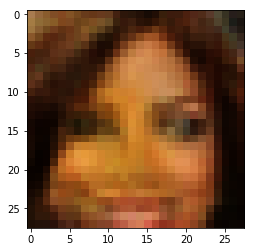

Epoch 3/25... Discriminator Loss: 1.5718... Generator Loss: 0.5958
Epoch 3/25... Discriminator Loss: 1.2930... Generator Loss: 0.7213
Epoch 3/25... Discriminator Loss: 1.3865... Generator Loss: 0.8375
Epoch 3/25... Discriminator Loss: 1.4113... Generator Loss: 0.6314


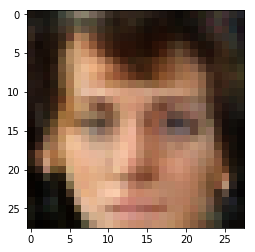

Epoch 3/25... Discriminator Loss: 1.2522... Generator Loss: 0.7703
Epoch 3/25... Discriminator Loss: 1.3167... Generator Loss: 0.7729
Epoch 3/25... Discriminator Loss: 1.2718... Generator Loss: 0.8736
Epoch 3/25... Discriminator Loss: 1.4998... Generator Loss: 0.5175


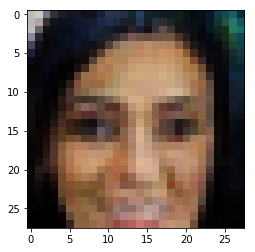

Epoch 3/25... Discriminator Loss: 1.3388... Generator Loss: 0.9516
Epoch 3/25... Discriminator Loss: 1.4605... Generator Loss: 0.6437
Epoch 3/25... Discriminator Loss: 1.3370... Generator Loss: 0.8579
Epoch 3/25... Discriminator Loss: 1.2966... Generator Loss: 0.7865


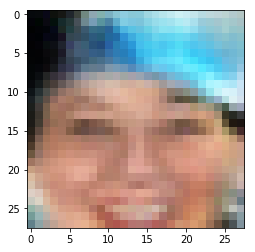

Epoch 3/25... Discriminator Loss: 1.4496... Generator Loss: 0.6480
Epoch 3/25... Discriminator Loss: 1.3529... Generator Loss: 0.8293
Epoch 3/25... Discriminator Loss: 1.4109... Generator Loss: 1.0302
Epoch 3/25... Discriminator Loss: 1.4631... Generator Loss: 0.9176


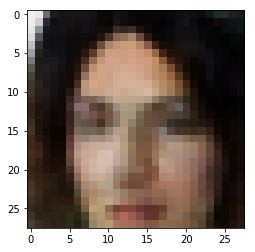

Epoch 3/25... Discriminator Loss: 1.3397... Generator Loss: 0.7083
Epoch 3/25... Discriminator Loss: 1.3187... Generator Loss: 0.7353
Epoch 3/25... Discriminator Loss: 1.3785... Generator Loss: 0.6848
Epoch 3/25... Discriminator Loss: 1.3024... Generator Loss: 0.6588


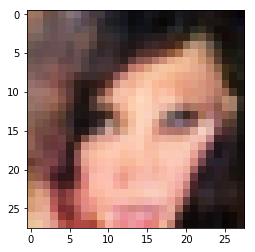

Epoch 3/25... Discriminator Loss: 1.5544... Generator Loss: 1.0336
Epoch 3/25... Discriminator Loss: 1.4037... Generator Loss: 0.5321
Epoch 3/25... Discriminator Loss: 1.3149... Generator Loss: 0.6841
Epoch 3/25... Discriminator Loss: 1.3634... Generator Loss: 0.7610


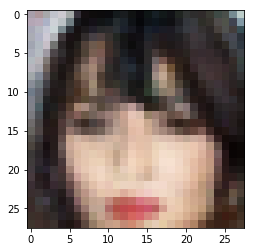

Epoch 3/25... Discriminator Loss: 1.2593... Generator Loss: 0.7385
Epoch 3/25... Discriminator Loss: 1.4370... Generator Loss: 0.6992
Epoch 3/25... Discriminator Loss: 1.2421... Generator Loss: 0.9361
Epoch 3/25... Discriminator Loss: 1.2447... Generator Loss: 0.7415


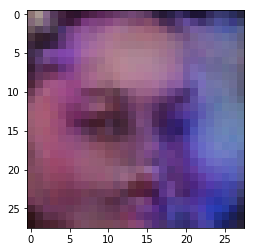

Epoch 3/25... Discriminator Loss: 1.4133... Generator Loss: 0.7626
Epoch 3/25... Discriminator Loss: 1.3355... Generator Loss: 0.7750
Epoch 3/25... Discriminator Loss: 1.5543... Generator Loss: 0.5113
Epoch 3/25... Discriminator Loss: 1.5232... Generator Loss: 0.5131


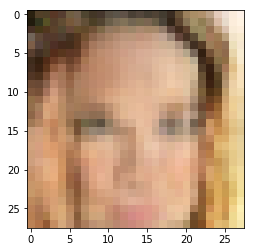

Epoch 3/25... Discriminator Loss: 1.3420... Generator Loss: 0.7034
Epoch 3/25... Discriminator Loss: 1.4499... Generator Loss: 0.4953
Epoch 3/25... Discriminator Loss: 1.5699... Generator Loss: 0.4628
Epoch 3/25... Discriminator Loss: 1.4750... Generator Loss: 0.4746


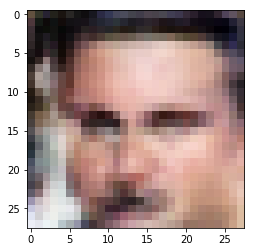

Epoch 3/25... Discriminator Loss: 1.3150... Generator Loss: 0.8574
Epoch 3/25... Discriminator Loss: 1.4520... Generator Loss: 0.6243
Epoch 3/25... Discriminator Loss: 1.4284... Generator Loss: 0.6226
Epoch 3/25... Discriminator Loss: 1.4414... Generator Loss: 0.6221


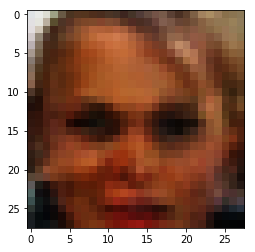

Epoch 3/25... Discriminator Loss: 1.5164... Generator Loss: 0.7504
Epoch 3/25... Discriminator Loss: 1.2725... Generator Loss: 0.6458
Epoch 3/25... Discriminator Loss: 1.2547... Generator Loss: 0.8529
Epoch 3/25... Discriminator Loss: 1.2930... Generator Loss: 0.8304


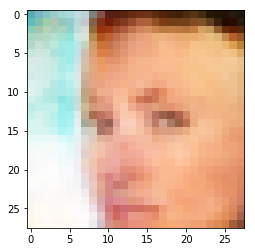

Epoch 3/25... Discriminator Loss: 1.2967... Generator Loss: 0.6880
Epoch 3/25... Discriminator Loss: 1.2579... Generator Loss: 0.8174
Epoch 3/25... Discriminator Loss: 1.3876... Generator Loss: 0.6651
Epoch 3/25... Discriminator Loss: 1.3139... Generator Loss: 0.8895


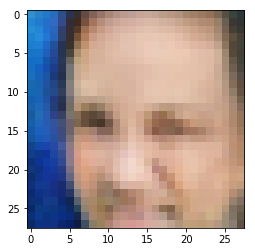

Epoch 3/25... Discriminator Loss: 1.3880... Generator Loss: 0.7292
Epoch 4/25... Discriminator Loss: 1.3206... Generator Loss: 0.8769
Epoch 4/25... Discriminator Loss: 1.4374... Generator Loss: 0.5744
Epoch 4/25... Discriminator Loss: 1.3374... Generator Loss: 0.6691


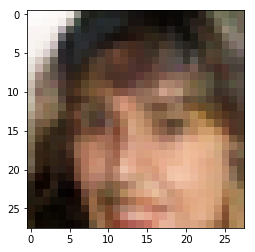

Epoch 4/25... Discriminator Loss: 1.4149... Generator Loss: 0.6228
Epoch 4/25... Discriminator Loss: 1.3234... Generator Loss: 0.8499
Epoch 4/25... Discriminator Loss: 1.3358... Generator Loss: 0.7320
Epoch 4/25... Discriminator Loss: 1.3263... Generator Loss: 0.8067


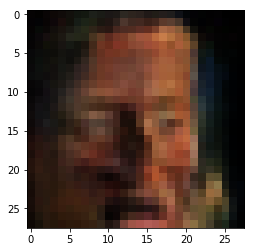

Epoch 4/25... Discriminator Loss: 1.3714... Generator Loss: 0.8344
Epoch 4/25... Discriminator Loss: 1.3744... Generator Loss: 0.6752
Epoch 4/25... Discriminator Loss: 1.4241... Generator Loss: 0.5969
Epoch 4/25... Discriminator Loss: 1.3314... Generator Loss: 0.8355


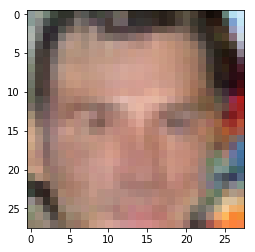

Epoch 4/25... Discriminator Loss: 1.2872... Generator Loss: 1.0946
Epoch 4/25... Discriminator Loss: 1.3716... Generator Loss: 0.7742
Epoch 4/25... Discriminator Loss: 1.5239... Generator Loss: 0.4951
Epoch 4/25... Discriminator Loss: 1.1943... Generator Loss: 0.9657


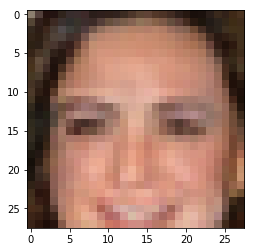

Epoch 4/25... Discriminator Loss: 1.4575... Generator Loss: 0.5292
Epoch 4/25... Discriminator Loss: 1.3169... Generator Loss: 0.6783
Epoch 4/25... Discriminator Loss: 1.4063... Generator Loss: 0.6392
Epoch 4/25... Discriminator Loss: 1.2825... Generator Loss: 0.9256


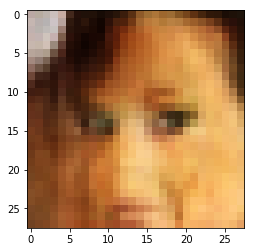

Epoch 4/25... Discriminator Loss: 1.3990... Generator Loss: 0.7025
Epoch 4/25... Discriminator Loss: 1.3679... Generator Loss: 0.6562
Epoch 4/25... Discriminator Loss: 1.2328... Generator Loss: 0.7582
Epoch 4/25... Discriminator Loss: 1.4015... Generator Loss: 0.6089


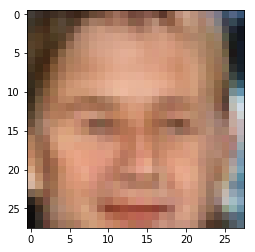

Epoch 4/25... Discriminator Loss: 1.4639... Generator Loss: 0.5538
Epoch 4/25... Discriminator Loss: 1.4277... Generator Loss: 0.6501
Epoch 4/25... Discriminator Loss: 1.3412... Generator Loss: 0.6182
Epoch 4/25... Discriminator Loss: 1.3517... Generator Loss: 0.8477


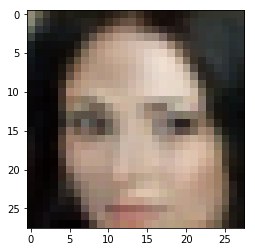

Epoch 4/25... Discriminator Loss: 1.4707... Generator Loss: 0.6614
Epoch 4/25... Discriminator Loss: 1.6171... Generator Loss: 0.6102
Epoch 4/25... Discriminator Loss: 1.4787... Generator Loss: 0.5794
Epoch 4/25... Discriminator Loss: 1.3781... Generator Loss: 0.7629


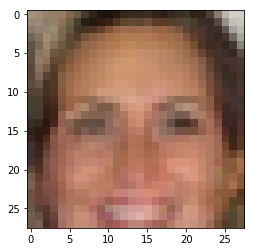

Epoch 4/25... Discriminator Loss: 1.5289... Generator Loss: 0.7507
Epoch 4/25... Discriminator Loss: 1.4045... Generator Loss: 0.6708
Epoch 4/25... Discriminator Loss: 1.3381... Generator Loss: 0.7732
Epoch 4/25... Discriminator Loss: 1.3357... Generator Loss: 0.7627


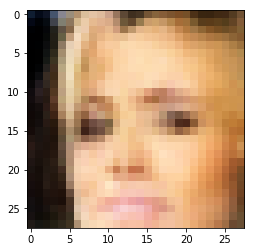

Epoch 4/25... Discriminator Loss: 1.4556... Generator Loss: 0.6482
Epoch 4/25... Discriminator Loss: 1.4045... Generator Loss: 0.7252
Epoch 4/25... Discriminator Loss: 1.4233... Generator Loss: 0.8503
Epoch 4/25... Discriminator Loss: 1.2325... Generator Loss: 0.9149


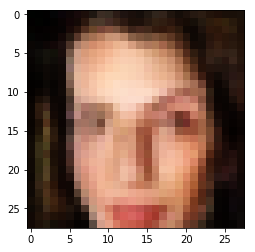

Epoch 4/25... Discriminator Loss: 1.4376... Generator Loss: 0.6178
Epoch 4/25... Discriminator Loss: 1.3665... Generator Loss: 0.6153
Epoch 4/25... Discriminator Loss: 1.2919... Generator Loss: 0.6915
Epoch 4/25... Discriminator Loss: 1.3397... Generator Loss: 0.7095


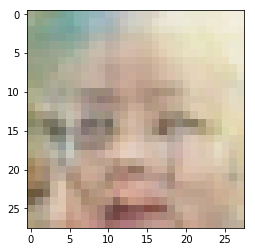

Epoch 4/25... Discriminator Loss: 1.3735... Generator Loss: 0.7206
Epoch 4/25... Discriminator Loss: 1.3483... Generator Loss: 0.7216
Epoch 4/25... Discriminator Loss: 1.4119... Generator Loss: 0.7221
Epoch 4/25... Discriminator Loss: 1.3346... Generator Loss: 0.7725


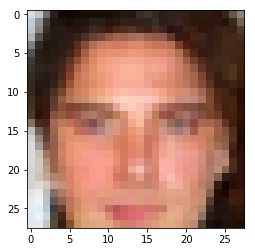

Epoch 4/25... Discriminator Loss: 1.3110... Generator Loss: 0.7694
Epoch 4/25... Discriminator Loss: 1.3585... Generator Loss: 0.7478
Epoch 4/25... Discriminator Loss: 1.3551... Generator Loss: 0.7985
Epoch 4/25... Discriminator Loss: 1.4473... Generator Loss: 0.7604


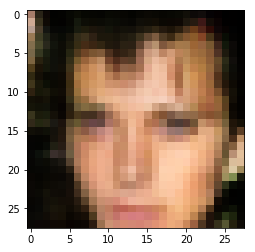

Epoch 4/25... Discriminator Loss: 1.1952... Generator Loss: 0.9703
Epoch 4/25... Discriminator Loss: 1.3998... Generator Loss: 0.6618
Epoch 4/25... Discriminator Loss: 1.3809... Generator Loss: 0.9242
Epoch 4/25... Discriminator Loss: 1.4111... Generator Loss: 0.6630


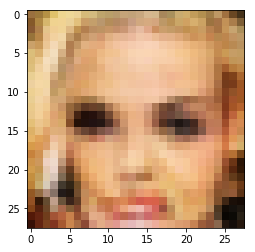

Epoch 4/25... Discriminator Loss: 1.4447... Generator Loss: 0.7736
Epoch 4/25... Discriminator Loss: 1.6743... Generator Loss: 0.6124
Epoch 4/25... Discriminator Loss: 1.2894... Generator Loss: 0.8673
Epoch 4/25... Discriminator Loss: 1.3774... Generator Loss: 0.6790


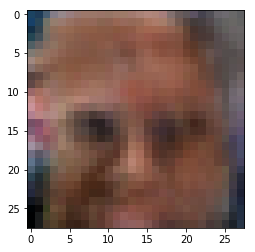

Epoch 4/25... Discriminator Loss: 1.3405... Generator Loss: 0.8056
Epoch 4/25... Discriminator Loss: 1.4245... Generator Loss: 0.5560
Epoch 4/25... Discriminator Loss: 1.4125... Generator Loss: 0.6292
Epoch 4/25... Discriminator Loss: 1.4184... Generator Loss: 0.6434


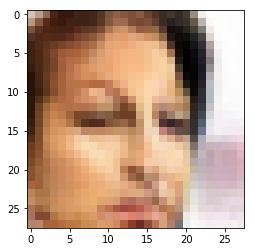

Epoch 4/25... Discriminator Loss: 1.3738... Generator Loss: 0.8739
Epoch 5/25... Discriminator Loss: 1.3702... Generator Loss: 0.6865
Epoch 5/25... Discriminator Loss: 1.3713... Generator Loss: 0.5956
Epoch 5/25... Discriminator Loss: 1.3729... Generator Loss: 0.9218


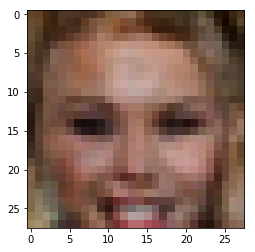

Epoch 5/25... Discriminator Loss: 1.3001... Generator Loss: 0.7094
Epoch 5/25... Discriminator Loss: 1.4261... Generator Loss: 0.6656
Epoch 5/25... Discriminator Loss: 1.3262... Generator Loss: 1.0009
Epoch 5/25... Discriminator Loss: 1.3535... Generator Loss: 0.7328


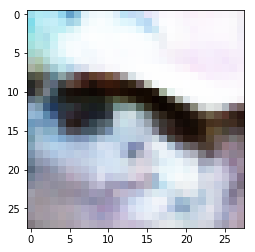

Epoch 5/25... Discriminator Loss: 1.3401... Generator Loss: 0.6995
Epoch 5/25... Discriminator Loss: 1.4375... Generator Loss: 0.7152
Epoch 5/25... Discriminator Loss: 1.4318... Generator Loss: 0.7289
Epoch 5/25... Discriminator Loss: 1.3993... Generator Loss: 0.6684


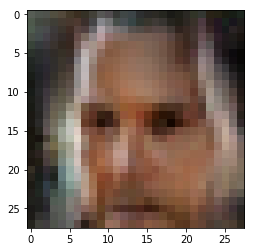

Epoch 5/25... Discriminator Loss: 1.3712... Generator Loss: 0.5976
Epoch 5/25... Discriminator Loss: 1.4211... Generator Loss: 0.6400
Epoch 5/25... Discriminator Loss: 1.3658... Generator Loss: 0.7743
Epoch 5/25... Discriminator Loss: 1.5253... Generator Loss: 0.6123


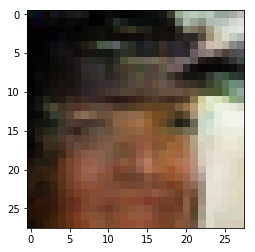

Epoch 5/25... Discriminator Loss: 1.4199... Generator Loss: 0.5903
Epoch 5/25... Discriminator Loss: 1.3368... Generator Loss: 0.7954
Epoch 5/25... Discriminator Loss: 1.3819... Generator Loss: 0.7228
Epoch 5/25... Discriminator Loss: 1.3061... Generator Loss: 0.9110


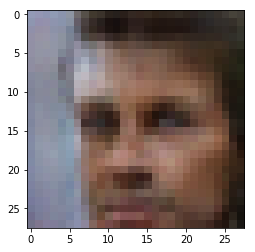

Epoch 5/25... Discriminator Loss: 1.4345... Generator Loss: 0.6981
Epoch 5/25... Discriminator Loss: 1.4066... Generator Loss: 0.6063
Epoch 5/25... Discriminator Loss: 1.3108... Generator Loss: 0.8159
Epoch 5/25... Discriminator Loss: 1.4033... Generator Loss: 0.6392


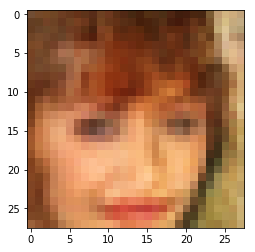

Epoch 5/25... Discriminator Loss: 1.3201... Generator Loss: 0.7261
Epoch 5/25... Discriminator Loss: 1.2941... Generator Loss: 0.7036
Epoch 5/25... Discriminator Loss: 1.3923... Generator Loss: 0.5993
Epoch 5/25... Discriminator Loss: 1.3441... Generator Loss: 0.7645


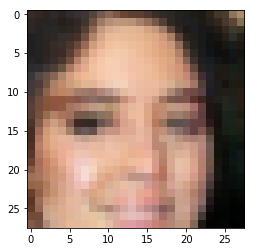

Epoch 5/25... Discriminator Loss: 1.4408... Generator Loss: 0.5919
Epoch 5/25... Discriminator Loss: 1.3915... Generator Loss: 0.8317
Epoch 5/25... Discriminator Loss: 1.3909... Generator Loss: 0.6734
Epoch 5/25... Discriminator Loss: 1.3934... Generator Loss: 0.7082


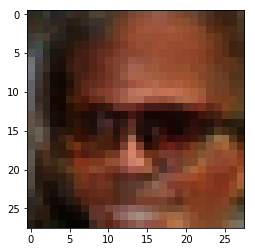

Epoch 5/25... Discriminator Loss: 1.3792... Generator Loss: 0.6933
Epoch 5/25... Discriminator Loss: 1.3974... Generator Loss: 0.7254
Epoch 5/25... Discriminator Loss: 1.3531... Generator Loss: 0.7579
Epoch 5/25... Discriminator Loss: 1.3363... Generator Loss: 0.8035


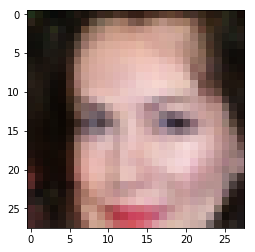

Epoch 5/25... Discriminator Loss: 1.3844... Generator Loss: 0.5766
Epoch 5/25... Discriminator Loss: 1.4742... Generator Loss: 0.5363
Epoch 5/25... Discriminator Loss: 1.4240... Generator Loss: 0.6568
Epoch 5/25... Discriminator Loss: 1.3560... Generator Loss: 0.8005


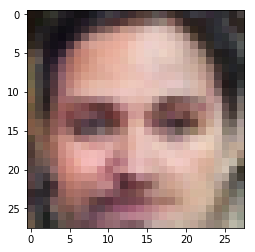

Epoch 5/25... Discriminator Loss: 1.4393... Generator Loss: 0.7151
Epoch 5/25... Discriminator Loss: 1.4353... Generator Loss: 0.6142
Epoch 5/25... Discriminator Loss: 1.3216... Generator Loss: 0.6745
Epoch 5/25... Discriminator Loss: 1.3802... Generator Loss: 0.8997


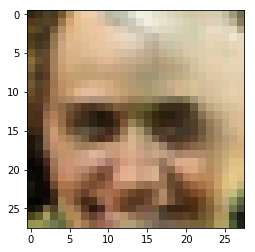

Epoch 5/25... Discriminator Loss: 1.4290... Generator Loss: 0.7066
Epoch 5/25... Discriminator Loss: 1.4246... Generator Loss: 0.6521
Epoch 5/25... Discriminator Loss: 1.3300... Generator Loss: 0.7025
Epoch 5/25... Discriminator Loss: 1.3910... Generator Loss: 0.7357


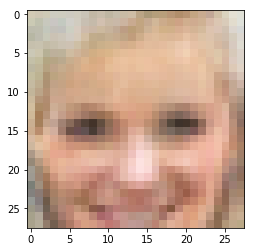

Epoch 5/25... Discriminator Loss: 1.3534... Generator Loss: 0.8081
Epoch 5/25... Discriminator Loss: 1.3173... Generator Loss: 0.9381
Epoch 5/25... Discriminator Loss: 1.5262... Generator Loss: 0.5070
Epoch 5/25... Discriminator Loss: 1.4025... Generator Loss: 0.5967


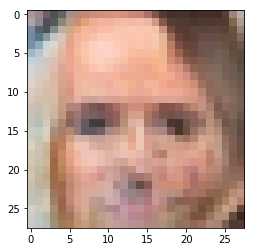

Epoch 5/25... Discriminator Loss: 1.3716... Generator Loss: 0.7816
Epoch 5/25... Discriminator Loss: 1.4298... Generator Loss: 0.7305
Epoch 5/25... Discriminator Loss: 1.3981... Generator Loss: 0.7312
Epoch 5/25... Discriminator Loss: 1.4190... Generator Loss: 0.7416


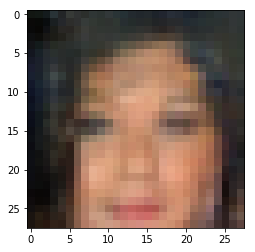

Epoch 5/25... Discriminator Loss: 1.3396... Generator Loss: 0.6515
Epoch 5/25... Discriminator Loss: 1.3958... Generator Loss: 0.8648
Epoch 5/25... Discriminator Loss: 1.4025... Generator Loss: 0.7865
Epoch 5/25... Discriminator Loss: 1.3647... Generator Loss: 0.6894


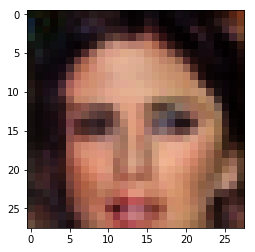

Epoch 5/25... Discriminator Loss: 1.4879... Generator Loss: 0.5391
Epoch 5/25... Discriminator Loss: 1.3504... Generator Loss: 0.8773
Epoch 5/25... Discriminator Loss: 1.3547... Generator Loss: 0.7428
Epoch 5/25... Discriminator Loss: 1.4163... Generator Loss: 0.5616


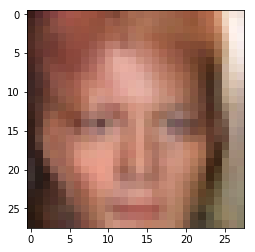

Epoch 6/25... Discriminator Loss: 1.5199... Generator Loss: 0.6144
Epoch 6/25... Discriminator Loss: 1.4239... Generator Loss: 0.5827
Epoch 6/25... Discriminator Loss: 1.3941... Generator Loss: 0.7008
Epoch 6/25... Discriminator Loss: 1.5347... Generator Loss: 0.6109


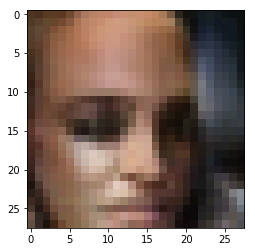

Epoch 6/25... Discriminator Loss: 1.4135... Generator Loss: 0.6738
Epoch 6/25... Discriminator Loss: 1.3000... Generator Loss: 0.7522
Epoch 6/25... Discriminator Loss: 1.3899... Generator Loss: 0.6678
Epoch 6/25... Discriminator Loss: 1.4163... Generator Loss: 0.6402


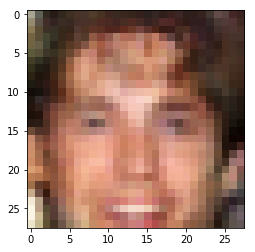

Epoch 6/25... Discriminator Loss: 1.3616... Generator Loss: 1.0272
Epoch 6/25... Discriminator Loss: 1.3285... Generator Loss: 0.8647
Epoch 6/25... Discriminator Loss: 1.5629... Generator Loss: 0.4416
Epoch 6/25... Discriminator Loss: 1.3790... Generator Loss: 0.7192


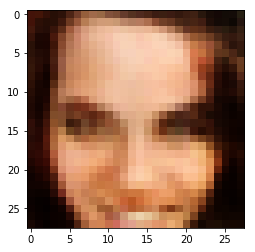

Epoch 6/25... Discriminator Loss: 1.3082... Generator Loss: 0.8349
Epoch 6/25... Discriminator Loss: 1.4384... Generator Loss: 0.6933
Epoch 6/25... Discriminator Loss: 1.3759... Generator Loss: 0.6751
Epoch 6/25... Discriminator Loss: 1.3800... Generator Loss: 0.7629


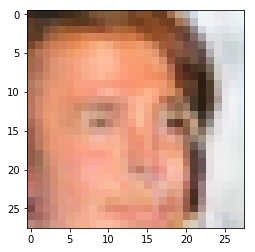

Epoch 6/25... Discriminator Loss: 1.3451... Generator Loss: 0.6591
Epoch 6/25... Discriminator Loss: 1.3886... Generator Loss: 0.6130
Epoch 6/25... Discriminator Loss: 1.4252... Generator Loss: 0.6227
Epoch 6/25... Discriminator Loss: 1.3130... Generator Loss: 0.8324


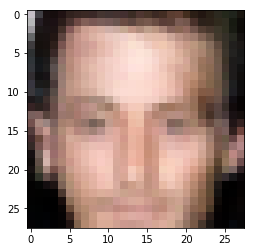

Epoch 6/25... Discriminator Loss: 1.3832... Generator Loss: 0.5915
Epoch 6/25... Discriminator Loss: 1.3101... Generator Loss: 0.8387
Epoch 6/25... Discriminator Loss: 1.4011... Generator Loss: 0.6752
Epoch 6/25... Discriminator Loss: 1.3982... Generator Loss: 0.7434


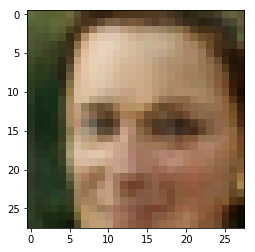

Epoch 6/25... Discriminator Loss: 1.3084... Generator Loss: 0.8829
Epoch 6/25... Discriminator Loss: 1.2880... Generator Loss: 0.8111
Epoch 6/25... Discriminator Loss: 1.4126... Generator Loss: 0.6748
Epoch 6/25... Discriminator Loss: 1.3706... Generator Loss: 0.7648


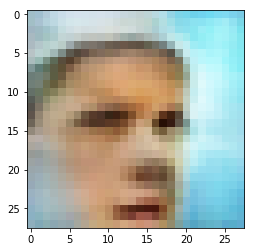

Epoch 6/25... Discriminator Loss: 1.2966... Generator Loss: 0.8227
Epoch 6/25... Discriminator Loss: 1.3902... Generator Loss: 0.6851
Epoch 6/25... Discriminator Loss: 1.4249... Generator Loss: 0.6187
Epoch 6/25... Discriminator Loss: 1.1784... Generator Loss: 0.8905


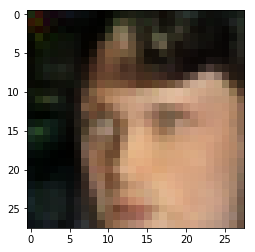

Epoch 6/25... Discriminator Loss: 1.4519... Generator Loss: 0.6661
Epoch 6/25... Discriminator Loss: 1.4629... Generator Loss: 0.6567
Epoch 6/25... Discriminator Loss: 1.3259... Generator Loss: 0.8773
Epoch 6/25... Discriminator Loss: 1.2559... Generator Loss: 0.8055


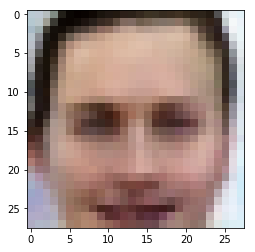

Epoch 6/25... Discriminator Loss: 1.4102... Generator Loss: 0.6566
Epoch 6/25... Discriminator Loss: 1.3878... Generator Loss: 0.8132
Epoch 6/25... Discriminator Loss: 1.3958... Generator Loss: 0.7519
Epoch 6/25... Discriminator Loss: 1.3613... Generator Loss: 0.6497


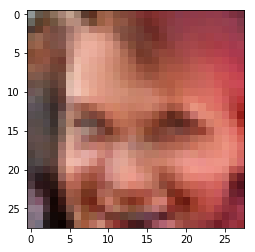

Epoch 6/25... Discriminator Loss: 1.3657... Generator Loss: 0.6870
Epoch 6/25... Discriminator Loss: 1.4365... Generator Loss: 0.8407
Epoch 6/25... Discriminator Loss: 1.3915... Generator Loss: 0.6365
Epoch 6/25... Discriminator Loss: 1.3633... Generator Loss: 0.7824


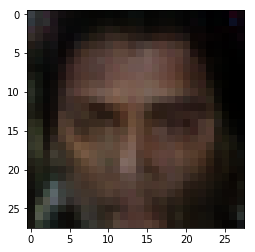

Epoch 6/25... Discriminator Loss: 1.3706... Generator Loss: 0.7813
Epoch 6/25... Discriminator Loss: 1.3802... Generator Loss: 0.6489
Epoch 6/25... Discriminator Loss: 1.3918... Generator Loss: 0.6856
Epoch 6/25... Discriminator Loss: 1.4391... Generator Loss: 0.6876


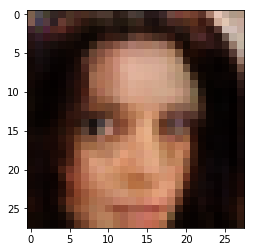

Epoch 6/25... Discriminator Loss: 1.3902... Generator Loss: 0.6707
Epoch 6/25... Discriminator Loss: 1.4651... Generator Loss: 0.6011
Epoch 6/25... Discriminator Loss: 1.3176... Generator Loss: 0.7706
Epoch 6/25... Discriminator Loss: 1.4653... Generator Loss: 0.7057


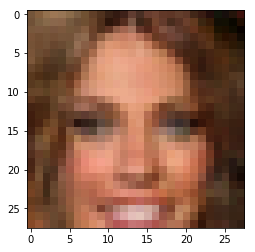

Epoch 6/25... Discriminator Loss: 1.4343... Generator Loss: 0.6526
Epoch 6/25... Discriminator Loss: 1.3898... Generator Loss: 0.7474
Epoch 6/25... Discriminator Loss: 1.4637... Generator Loss: 0.5486
Epoch 6/25... Discriminator Loss: 1.2850... Generator Loss: 0.7713


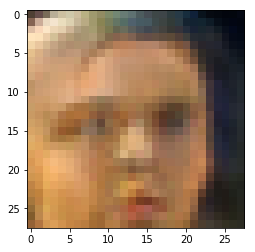

Epoch 6/25... Discriminator Loss: 1.4095... Generator Loss: 0.6923
Epoch 6/25... Discriminator Loss: 1.3974... Generator Loss: 0.6292
Epoch 6/25... Discriminator Loss: 1.4284... Generator Loss: 0.7001
Epoch 6/25... Discriminator Loss: 1.3836... Generator Loss: 0.7073


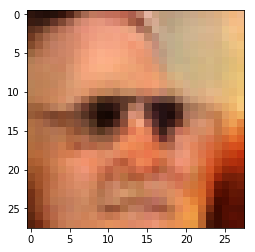

Epoch 6/25... Discriminator Loss: 1.2862... Generator Loss: 0.7755
Epoch 6/25... Discriminator Loss: 1.4280... Generator Loss: 0.6634
Epoch 6/25... Discriminator Loss: 1.5268... Generator Loss: 0.9004
Epoch 7/25... Discriminator Loss: 1.4513... Generator Loss: 0.5753


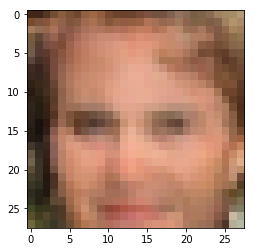

Epoch 7/25... Discriminator Loss: 1.4224... Generator Loss: 0.6576
Epoch 7/25... Discriminator Loss: 1.3527... Generator Loss: 0.8520
Epoch 7/25... Discriminator Loss: 1.3030... Generator Loss: 0.8047
Epoch 7/25... Discriminator Loss: 1.3752... Generator Loss: 0.6238


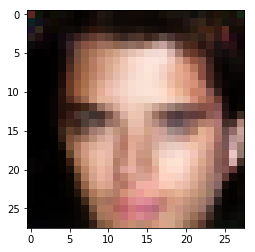

Epoch 7/25... Discriminator Loss: 1.3591... Generator Loss: 0.8259
Epoch 7/25... Discriminator Loss: 1.3990... Generator Loss: 0.6712
Epoch 7/25... Discriminator Loss: 1.4203... Generator Loss: 0.6515
Epoch 7/25... Discriminator Loss: 1.3771... Generator Loss: 0.6940


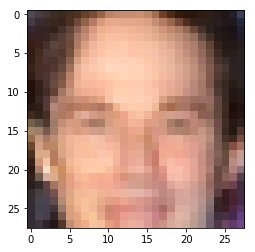

Epoch 7/25... Discriminator Loss: 1.4119... Generator Loss: 0.6523
Epoch 7/25... Discriminator Loss: 1.3077... Generator Loss: 0.8317
Epoch 7/25... Discriminator Loss: 1.4443... Generator Loss: 0.5782
Epoch 7/25... Discriminator Loss: 1.4639... Generator Loss: 0.6612


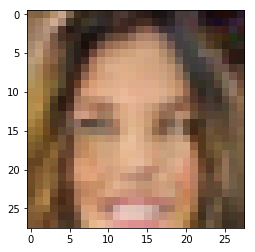

Epoch 7/25... Discriminator Loss: 1.4291... Generator Loss: 0.5715
Epoch 7/25... Discriminator Loss: 1.2640... Generator Loss: 0.9557
Epoch 7/25... Discriminator Loss: 1.3548... Generator Loss: 0.6464
Epoch 7/25... Discriminator Loss: 1.3556... Generator Loss: 0.6013


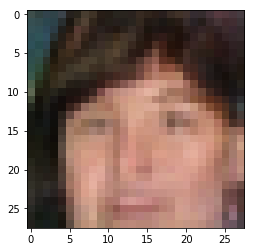

Epoch 7/25... Discriminator Loss: 1.4059... Generator Loss: 0.6363
Epoch 7/25... Discriminator Loss: 1.2997... Generator Loss: 0.7690
Epoch 7/25... Discriminator Loss: 1.3502... Generator Loss: 0.8280
Epoch 7/25... Discriminator Loss: 1.4114... Generator Loss: 0.7848


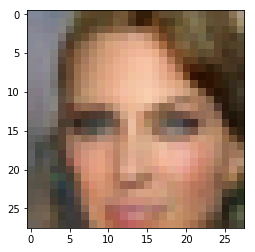

Epoch 7/25... Discriminator Loss: 1.3679... Generator Loss: 0.7042
Epoch 7/25... Discriminator Loss: 1.3424... Generator Loss: 0.6724
Epoch 7/25... Discriminator Loss: 1.4008... Generator Loss: 0.6061
Epoch 7/25... Discriminator Loss: 1.3408... Generator Loss: 0.8275


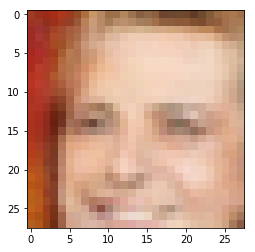

Epoch 7/25... Discriminator Loss: 1.5354... Generator Loss: 0.5749
Epoch 7/25... Discriminator Loss: 1.5028... Generator Loss: 0.5987
Epoch 7/25... Discriminator Loss: 1.3584... Generator Loss: 0.7205
Epoch 7/25... Discriminator Loss: 1.3164... Generator Loss: 0.8146


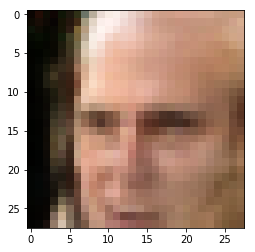

Epoch 7/25... Discriminator Loss: 1.2622... Generator Loss: 0.9123
Epoch 7/25... Discriminator Loss: 1.4071... Generator Loss: 0.6544
Epoch 7/25... Discriminator Loss: 1.3535... Generator Loss: 0.7264
Epoch 7/25... Discriminator Loss: 1.3637... Generator Loss: 0.7257


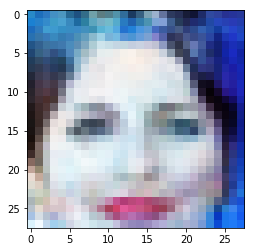

Epoch 7/25... Discriminator Loss: 1.3059... Generator Loss: 0.8132
Epoch 7/25... Discriminator Loss: 1.4778... Generator Loss: 0.5603
Epoch 7/25... Discriminator Loss: 1.4564... Generator Loss: 0.6450
Epoch 7/25... Discriminator Loss: 1.4310... Generator Loss: 0.6388


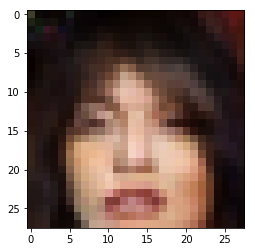

Epoch 7/25... Discriminator Loss: 1.4571... Generator Loss: 0.5419
Epoch 7/25... Discriminator Loss: 1.3969... Generator Loss: 0.6415
Epoch 7/25... Discriminator Loss: 1.2389... Generator Loss: 0.7917
Epoch 7/25... Discriminator Loss: 1.2772... Generator Loss: 0.9866


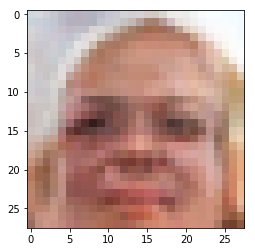

Epoch 7/25... Discriminator Loss: 1.4468... Generator Loss: 0.6902
Epoch 7/25... Discriminator Loss: 1.3509... Generator Loss: 0.8201
Epoch 7/25... Discriminator Loss: 1.3239... Generator Loss: 0.8500
Epoch 7/25... Discriminator Loss: 1.3619... Generator Loss: 0.8564


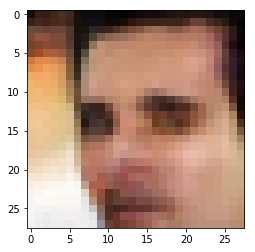

Epoch 7/25... Discriminator Loss: 1.3227... Generator Loss: 0.7531
Epoch 7/25... Discriminator Loss: 1.3022... Generator Loss: 0.7174
Epoch 7/25... Discriminator Loss: 1.2662... Generator Loss: 0.8027
Epoch 7/25... Discriminator Loss: 1.4137... Generator Loss: 0.7935


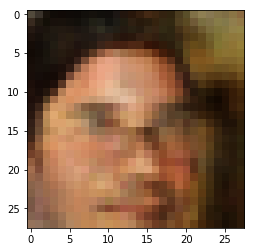

Epoch 7/25... Discriminator Loss: 1.3747... Generator Loss: 0.6917
Epoch 7/25... Discriminator Loss: 1.3601... Generator Loss: 0.6882
Epoch 7/25... Discriminator Loss: 1.3856... Generator Loss: 0.6660
Epoch 7/25... Discriminator Loss: 1.4113... Generator Loss: 0.5762


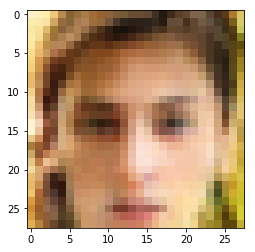

Epoch 7/25... Discriminator Loss: 1.3636... Generator Loss: 0.7521
Epoch 7/25... Discriminator Loss: 1.4589... Generator Loss: 0.6194
Epoch 7/25... Discriminator Loss: 1.3884... Generator Loss: 0.7248
Epoch 7/25... Discriminator Loss: 1.3437... Generator Loss: 0.7138


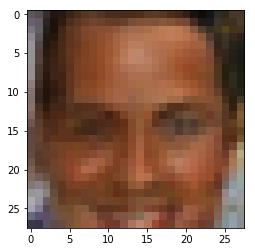

Epoch 7/25... Discriminator Loss: 1.4575... Generator Loss: 0.5570
Epoch 7/25... Discriminator Loss: 1.3868... Generator Loss: 0.7113
Epoch 7/25... Discriminator Loss: 1.3627... Generator Loss: 0.6452
Epoch 7/25... Discriminator Loss: 1.3573... Generator Loss: 0.7385


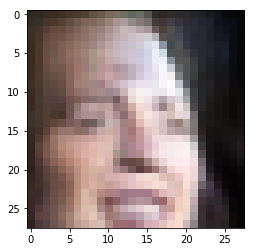

Epoch 7/25... Discriminator Loss: 1.3800... Generator Loss: 0.7763
Epoch 7/25... Discriminator Loss: 1.4106... Generator Loss: 0.7887
Epoch 7/25... Discriminator Loss: 1.3647... Generator Loss: 0.7366
Epoch 8/25... Discriminator Loss: 1.3789... Generator Loss: 0.7183


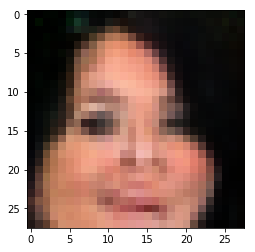

Epoch 8/25... Discriminator Loss: 1.3470... Generator Loss: 0.8273
Epoch 8/25... Discriminator Loss: 1.3865... Generator Loss: 0.6908
Epoch 8/25... Discriminator Loss: 1.3266... Generator Loss: 0.8248
Epoch 8/25... Discriminator Loss: 1.3842... Generator Loss: 0.7434


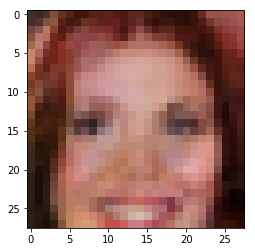

Epoch 8/25... Discriminator Loss: 1.4294... Generator Loss: 0.6804
Epoch 8/25... Discriminator Loss: 1.4405... Generator Loss: 0.6404
Epoch 8/25... Discriminator Loss: 1.3010... Generator Loss: 0.8203
Epoch 8/25... Discriminator Loss: 1.4313... Generator Loss: 0.6676


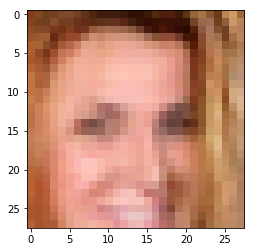

Epoch 8/25... Discriminator Loss: 1.3265... Generator Loss: 0.7233
Epoch 8/25... Discriminator Loss: 1.4405... Generator Loss: 0.5950
Epoch 8/25... Discriminator Loss: 1.4819... Generator Loss: 0.6712
Epoch 8/25... Discriminator Loss: 1.3921... Generator Loss: 0.5820


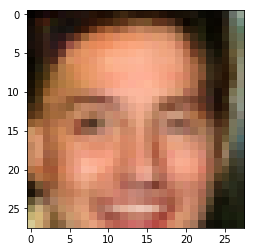

Epoch 8/25... Discriminator Loss: 1.3880... Generator Loss: 0.6222
Epoch 8/25... Discriminator Loss: 1.3640... Generator Loss: 0.8319
Epoch 8/25... Discriminator Loss: 1.3252... Generator Loss: 0.6882
Epoch 8/25... Discriminator Loss: 1.4147... Generator Loss: 0.6101


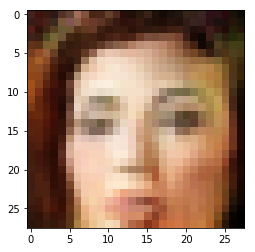

Epoch 8/25... Discriminator Loss: 1.3689... Generator Loss: 0.8167
Epoch 8/25... Discriminator Loss: 1.4046... Generator Loss: 0.7304
Epoch 8/25... Discriminator Loss: 1.3574... Generator Loss: 0.7101
Epoch 8/25... Discriminator Loss: 1.4995... Generator Loss: 0.6561


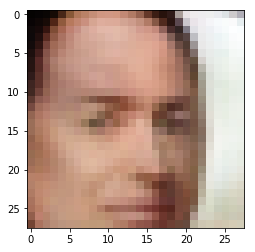

Epoch 8/25... Discriminator Loss: 1.3703... Generator Loss: 0.6940
Epoch 8/25... Discriminator Loss: 1.3911... Generator Loss: 0.7545
Epoch 8/25... Discriminator Loss: 1.3741... Generator Loss: 0.6496
Epoch 8/25... Discriminator Loss: 1.4844... Generator Loss: 0.5237


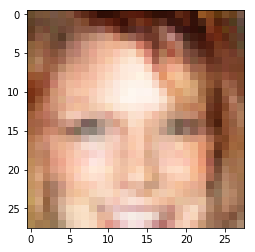

Epoch 8/25... Discriminator Loss: 1.6262... Generator Loss: 0.4500
Epoch 8/25... Discriminator Loss: 1.4009... Generator Loss: 0.7207
Epoch 8/25... Discriminator Loss: 1.3715... Generator Loss: 0.7505
Epoch 8/25... Discriminator Loss: 1.3763... Generator Loss: 0.8605


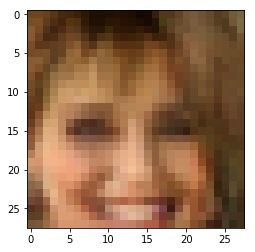

Epoch 8/25... Discriminator Loss: 1.3791... Generator Loss: 0.6972
Epoch 8/25... Discriminator Loss: 1.3627... Generator Loss: 0.7462
Epoch 8/25... Discriminator Loss: 1.4185... Generator Loss: 0.7413
Epoch 8/25... Discriminator Loss: 1.4331... Generator Loss: 0.5626


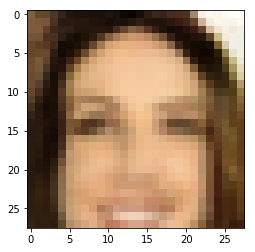

Epoch 8/25... Discriminator Loss: 1.4100... Generator Loss: 0.6532
Epoch 8/25... Discriminator Loss: 1.3833... Generator Loss: 0.6161
Epoch 8/25... Discriminator Loss: 1.2893... Generator Loss: 0.8518
Epoch 8/25... Discriminator Loss: 1.2524... Generator Loss: 0.7237


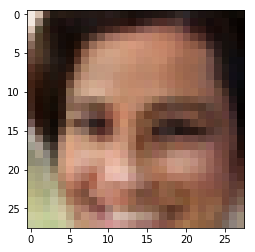

Epoch 8/25... Discriminator Loss: 1.3397... Generator Loss: 0.7447
Epoch 8/25... Discriminator Loss: 1.3066... Generator Loss: 0.7167
Epoch 8/25... Discriminator Loss: 1.3583... Generator Loss: 0.7612
Epoch 8/25... Discriminator Loss: 1.4319... Generator Loss: 0.6296


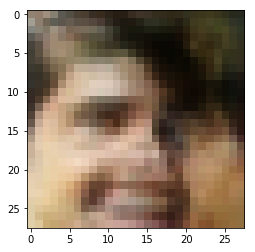

Epoch 8/25... Discriminator Loss: 1.3912... Generator Loss: 0.7056
Epoch 8/25... Discriminator Loss: 1.2740... Generator Loss: 0.8706
Epoch 8/25... Discriminator Loss: 1.3143... Generator Loss: 0.8948
Epoch 8/25... Discriminator Loss: 1.3899... Generator Loss: 0.6829


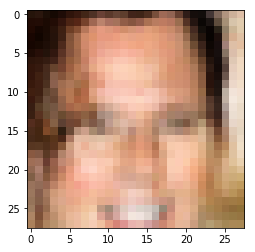

Epoch 8/25... Discriminator Loss: 1.3914... Generator Loss: 0.7847
Epoch 8/25... Discriminator Loss: 1.3563... Generator Loss: 0.7831
Epoch 8/25... Discriminator Loss: 1.4530... Generator Loss: 0.6669
Epoch 8/25... Discriminator Loss: 1.3184... Generator Loss: 0.7653


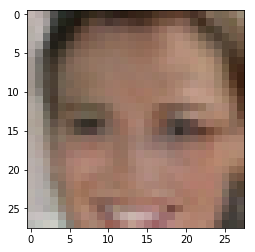

Epoch 8/25... Discriminator Loss: 1.3141... Generator Loss: 0.7079
Epoch 8/25... Discriminator Loss: 1.2311... Generator Loss: 0.8856
Epoch 8/25... Discriminator Loss: 1.4019... Generator Loss: 0.6967
Epoch 8/25... Discriminator Loss: 1.3542... Generator Loss: 0.7122


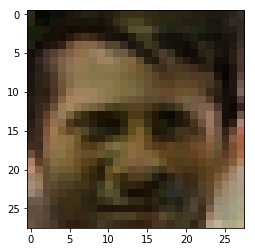

Epoch 8/25... Discriminator Loss: 1.3873... Generator Loss: 0.7865
Epoch 8/25... Discriminator Loss: 1.4851... Generator Loss: 0.7089
Epoch 8/25... Discriminator Loss: 1.4488... Generator Loss: 0.6853
Epoch 8/25... Discriminator Loss: 1.3865... Generator Loss: 0.6327


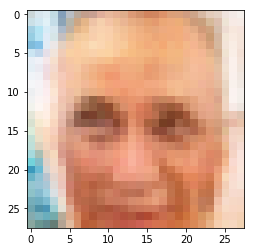

Epoch 8/25... Discriminator Loss: 1.4136... Generator Loss: 0.6772
Epoch 8/25... Discriminator Loss: 1.4488... Generator Loss: 0.5806
Epoch 8/25... Discriminator Loss: 1.3623... Generator Loss: 0.6845
Epoch 8/25... Discriminator Loss: 1.3960... Generator Loss: 0.6429


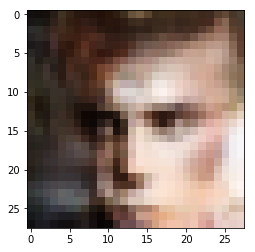

Epoch 8/25... Discriminator Loss: 1.3149... Generator Loss: 0.8111
Epoch 8/25... Discriminator Loss: 1.4115... Generator Loss: 0.5864
Epoch 9/25... Discriminator Loss: 1.5016... Generator Loss: 0.6400
Epoch 9/25... Discriminator Loss: 1.4327... Generator Loss: 0.6363


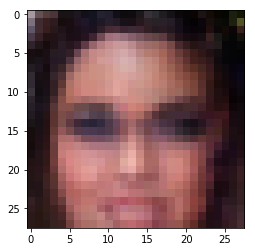

Epoch 9/25... Discriminator Loss: 1.4446... Generator Loss: 0.5897
Epoch 9/25... Discriminator Loss: 1.3465... Generator Loss: 0.7620
Epoch 9/25... Discriminator Loss: 1.3972... Generator Loss: 0.7402
Epoch 9/25... Discriminator Loss: 1.3080... Generator Loss: 0.7762


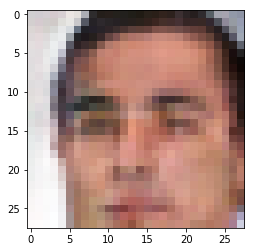

Epoch 9/25... Discriminator Loss: 1.3583... Generator Loss: 0.8074
Epoch 9/25... Discriminator Loss: 1.2745... Generator Loss: 0.8081
Epoch 9/25... Discriminator Loss: 1.3758... Generator Loss: 0.6953
Epoch 9/25... Discriminator Loss: 1.4296... Generator Loss: 0.6208


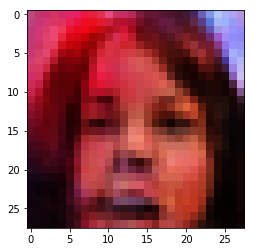

Epoch 9/25... Discriminator Loss: 1.4341... Generator Loss: 0.6047
Epoch 9/25... Discriminator Loss: 1.3186... Generator Loss: 0.7079
Epoch 9/25... Discriminator Loss: 1.3326... Generator Loss: 0.6963
Epoch 9/25... Discriminator Loss: 1.3682... Generator Loss: 0.8041


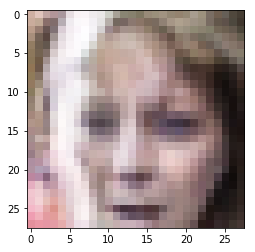

Epoch 9/25... Discriminator Loss: 1.4499... Generator Loss: 0.6442
Epoch 9/25... Discriminator Loss: 1.4966... Generator Loss: 0.6295
Epoch 9/25... Discriminator Loss: 1.3703... Generator Loss: 0.6632
Epoch 9/25... Discriminator Loss: 1.4136... Generator Loss: 0.6782


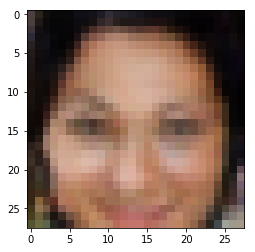

Epoch 9/25... Discriminator Loss: 1.4528... Generator Loss: 0.6602
Epoch 9/25... Discriminator Loss: 1.4438... Generator Loss: 0.5617
Epoch 9/25... Discriminator Loss: 1.4184... Generator Loss: 0.6019
Epoch 9/25... Discriminator Loss: 1.3809... Generator Loss: 0.6045


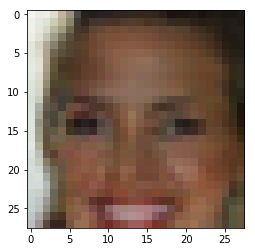

Epoch 9/25... Discriminator Loss: 1.3653... Generator Loss: 0.7339
Epoch 9/25... Discriminator Loss: 1.4121... Generator Loss: 0.7659
Epoch 9/25... Discriminator Loss: 1.4591... Generator Loss: 0.5699
Epoch 9/25... Discriminator Loss: 1.5231... Generator Loss: 0.5857


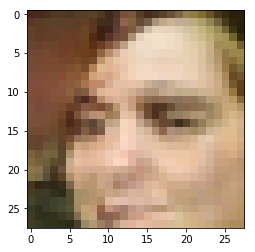

Epoch 9/25... Discriminator Loss: 1.2657... Generator Loss: 0.8638
Epoch 9/25... Discriminator Loss: 1.4314... Generator Loss: 0.7101
Epoch 9/25... Discriminator Loss: 1.4897... Generator Loss: 0.6570
Epoch 9/25... Discriminator Loss: 1.4126... Generator Loss: 0.6287


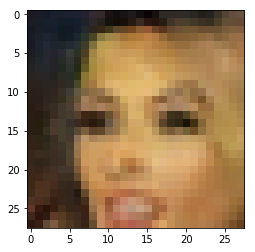

Epoch 9/25... Discriminator Loss: 1.4806... Generator Loss: 0.5878
Epoch 9/25... Discriminator Loss: 1.4159... Generator Loss: 0.7021
Epoch 9/25... Discriminator Loss: 1.4998... Generator Loss: 0.6612
Epoch 9/25... Discriminator Loss: 1.3963... Generator Loss: 0.6954


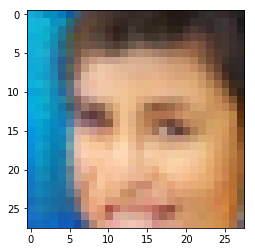

Epoch 9/25... Discriminator Loss: 1.4229... Generator Loss: 0.7699
Epoch 9/25... Discriminator Loss: 1.3671... Generator Loss: 0.7917
Epoch 9/25... Discriminator Loss: 1.3070... Generator Loss: 0.6701
Epoch 9/25... Discriminator Loss: 1.3844... Generator Loss: 0.8404


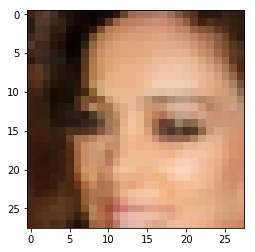

Epoch 9/25... Discriminator Loss: 1.3794... Generator Loss: 0.7161
Epoch 9/25... Discriminator Loss: 1.4621... Generator Loss: 0.6673
Epoch 9/25... Discriminator Loss: 1.3479... Generator Loss: 0.7097
Epoch 9/25... Discriminator Loss: 1.3886... Generator Loss: 0.6577


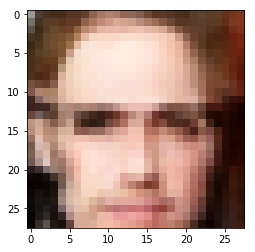

Epoch 9/25... Discriminator Loss: 1.3716... Generator Loss: 0.7094
Epoch 9/25... Discriminator Loss: 1.4825... Generator Loss: 0.5864
Epoch 9/25... Discriminator Loss: 1.3798... Generator Loss: 0.6890
Epoch 9/25... Discriminator Loss: 1.3195... Generator Loss: 0.7363


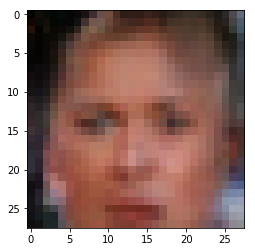

Epoch 9/25... Discriminator Loss: 1.4372... Generator Loss: 0.5210
Epoch 9/25... Discriminator Loss: 1.3352... Generator Loss: 0.8159
Epoch 9/25... Discriminator Loss: 1.3385... Generator Loss: 0.6907
Epoch 9/25... Discriminator Loss: 1.4289... Generator Loss: 0.6123


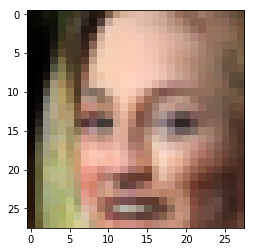

Epoch 9/25... Discriminator Loss: 1.4368... Generator Loss: 0.5976
Epoch 9/25... Discriminator Loss: 1.3912... Generator Loss: 0.7509
Epoch 9/25... Discriminator Loss: 1.4047... Generator Loss: 0.5739
Epoch 9/25... Discriminator Loss: 1.3298... Generator Loss: 0.7153


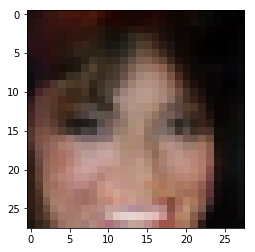

Epoch 9/25... Discriminator Loss: 1.3295... Generator Loss: 0.6927
Epoch 9/25... Discriminator Loss: 1.2933... Generator Loss: 0.7625
Epoch 9/25... Discriminator Loss: 1.4331... Generator Loss: 0.6602
Epoch 9/25... Discriminator Loss: 1.3843... Generator Loss: 0.7582


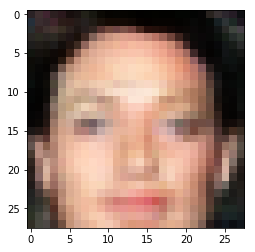

Epoch 9/25... Discriminator Loss: 1.4860... Generator Loss: 0.5818
Epoch 9/25... Discriminator Loss: 1.2727... Generator Loss: 0.7255
Epoch 9/25... Discriminator Loss: 1.3815... Generator Loss: 0.6538
Epoch 9/25... Discriminator Loss: 1.3916... Generator Loss: 0.7406


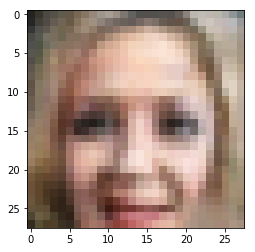

Epoch 9/25... Discriminator Loss: 1.3003... Generator Loss: 0.7467
Epoch 10/25... Discriminator Loss: 1.4112... Generator Loss: 0.6385
Epoch 10/25... Discriminator Loss: 1.3576... Generator Loss: 0.7799
Epoch 10/25... Discriminator Loss: 1.4237... Generator Loss: 0.5491


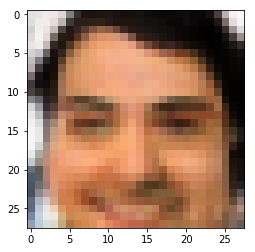

Epoch 10/25... Discriminator Loss: 1.3012... Generator Loss: 0.7697
Epoch 10/25... Discriminator Loss: 1.3703... Generator Loss: 0.7178
Epoch 10/25... Discriminator Loss: 1.5468... Generator Loss: 0.5527
Epoch 10/25... Discriminator Loss: 1.4051... Generator Loss: 0.5762


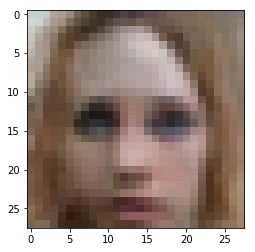

Epoch 10/25... Discriminator Loss: 1.3175... Generator Loss: 0.6899
Epoch 10/25... Discriminator Loss: 1.4565... Generator Loss: 0.6740
Epoch 10/25... Discriminator Loss: 1.3641... Generator Loss: 0.8525
Epoch 10/25... Discriminator Loss: 1.3802... Generator Loss: 0.7254


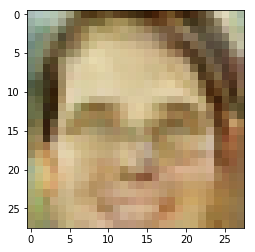

Epoch 10/25... Discriminator Loss: 1.4387... Generator Loss: 0.6320
Epoch 10/25... Discriminator Loss: 1.3514... Generator Loss: 0.7893
Epoch 10/25... Discriminator Loss: 1.4074... Generator Loss: 0.6458
Epoch 10/25... Discriminator Loss: 1.3632... Generator Loss: 0.6543


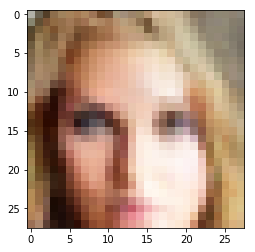

Epoch 10/25... Discriminator Loss: 1.3325... Generator Loss: 0.7004
Epoch 10/25... Discriminator Loss: 1.3190... Generator Loss: 0.7577
Epoch 10/25... Discriminator Loss: 1.3899... Generator Loss: 0.6167
Epoch 10/25... Discriminator Loss: 1.2478... Generator Loss: 0.7501


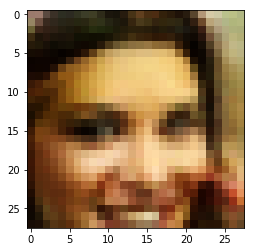

Epoch 10/25... Discriminator Loss: 1.4713... Generator Loss: 0.5411
Epoch 10/25... Discriminator Loss: 1.4442... Generator Loss: 0.7025
Epoch 10/25... Discriminator Loss: 1.4404... Generator Loss: 0.5631
Epoch 10/25... Discriminator Loss: 1.4197... Generator Loss: 0.5808


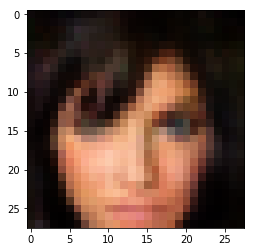

Epoch 10/25... Discriminator Loss: 1.4447... Generator Loss: 0.7805
Epoch 10/25... Discriminator Loss: 1.4498... Generator Loss: 0.6099
Epoch 10/25... Discriminator Loss: 1.5272... Generator Loss: 0.6088
Epoch 10/25... Discriminator Loss: 1.4738... Generator Loss: 0.6992


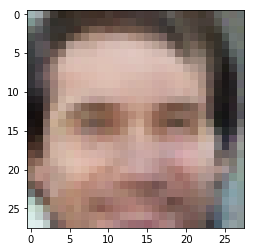

Epoch 10/25... Discriminator Loss: 1.3084... Generator Loss: 0.9146
Epoch 10/25... Discriminator Loss: 1.3624... Generator Loss: 0.6558
Epoch 10/25... Discriminator Loss: 1.4009... Generator Loss: 0.6438
Epoch 10/25... Discriminator Loss: 1.4217... Generator Loss: 0.6515


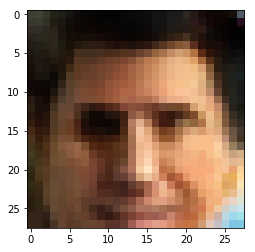

Epoch 10/25... Discriminator Loss: 1.4175... Generator Loss: 0.7610
Epoch 10/25... Discriminator Loss: 1.4496... Generator Loss: 0.6328
Epoch 10/25... Discriminator Loss: 1.4371... Generator Loss: 0.6161
Epoch 10/25... Discriminator Loss: 1.4679... Generator Loss: 0.6244


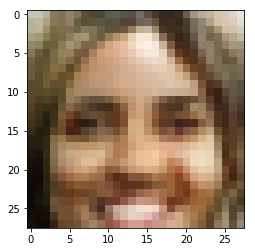

Epoch 10/25... Discriminator Loss: 1.4144... Generator Loss: 0.5697
Epoch 10/25... Discriminator Loss: 1.4458... Generator Loss: 0.5943
Epoch 10/25... Discriminator Loss: 1.3348... Generator Loss: 0.7763
Epoch 10/25... Discriminator Loss: 1.3471... Generator Loss: 0.7275


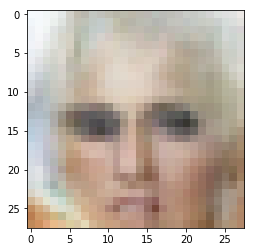

Epoch 10/25... Discriminator Loss: 1.4999... Generator Loss: 0.6127
Epoch 10/25... Discriminator Loss: 1.3716... Generator Loss: 0.6788
Epoch 10/25... Discriminator Loss: 1.4630... Generator Loss: 0.6676
Epoch 10/25... Discriminator Loss: 1.3982... Generator Loss: 0.7008


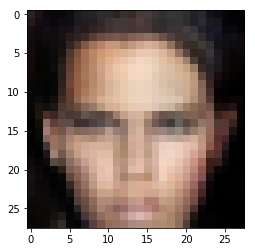

Epoch 10/25... Discriminator Loss: 1.4427... Generator Loss: 0.6802
Epoch 10/25... Discriminator Loss: 1.4025... Generator Loss: 0.6956
Epoch 10/25... Discriminator Loss: 1.4354... Generator Loss: 0.6350
Epoch 10/25... Discriminator Loss: 1.3784... Generator Loss: 0.6944


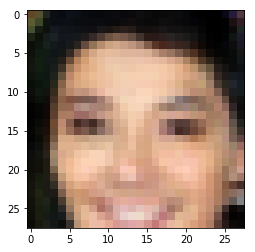

Epoch 10/25... Discriminator Loss: 1.4649... Generator Loss: 0.6056
Epoch 10/25... Discriminator Loss: 1.3125... Generator Loss: 0.7232
Epoch 10/25... Discriminator Loss: 1.4387... Generator Loss: 0.5862
Epoch 10/25... Discriminator Loss: 1.2406... Generator Loss: 0.9126


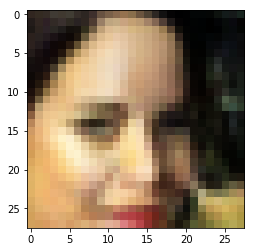

Epoch 10/25... Discriminator Loss: 1.2730... Generator Loss: 0.8423
Epoch 10/25... Discriminator Loss: 1.4251... Generator Loss: 0.6498
Epoch 10/25... Discriminator Loss: 1.2921... Generator Loss: 0.7517
Epoch 10/25... Discriminator Loss: 1.4122... Generator Loss: 0.6267


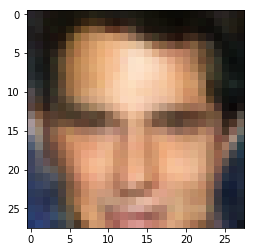

Epoch 10/25... Discriminator Loss: 1.4082... Generator Loss: 0.6930
Epoch 10/25... Discriminator Loss: 1.3650... Generator Loss: 0.7397
Epoch 10/25... Discriminator Loss: 1.4100... Generator Loss: 0.7582
Epoch 10/25... Discriminator Loss: 1.3963... Generator Loss: 0.6000


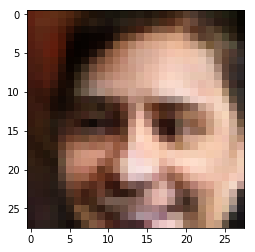

Epoch 10/25... Discriminator Loss: 1.3451... Generator Loss: 0.6841
Epoch 10/25... Discriminator Loss: 1.4655... Generator Loss: 0.6292
Epoch 10/25... Discriminator Loss: 1.4939... Generator Loss: 0.6745
Epoch 10/25... Discriminator Loss: 1.3058... Generator Loss: 0.7720


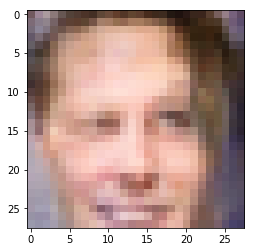

Epoch 10/25... Discriminator Loss: 1.4279... Generator Loss: 0.8009
Epoch 11/25... Discriminator Loss: 1.3419... Generator Loss: 0.6779
Epoch 11/25... Discriminator Loss: 1.4523... Generator Loss: 0.7287
Epoch 11/25... Discriminator Loss: 1.4242... Generator Loss: 0.6256


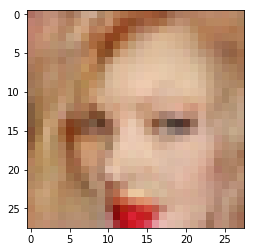

Epoch 11/25... Discriminator Loss: 1.4468... Generator Loss: 0.5864
Epoch 11/25... Discriminator Loss: 1.5110... Generator Loss: 0.5911
Epoch 11/25... Discriminator Loss: 1.3204... Generator Loss: 0.7205
Epoch 11/25... Discriminator Loss: 1.3520... Generator Loss: 0.7301


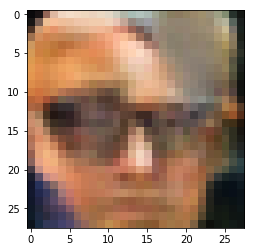

Epoch 11/25... Discriminator Loss: 1.3484... Generator Loss: 0.6985
Epoch 11/25... Discriminator Loss: 1.5208... Generator Loss: 0.6129
Epoch 11/25... Discriminator Loss: 1.4182... Generator Loss: 0.6640
Epoch 11/25... Discriminator Loss: 1.3849... Generator Loss: 0.7047


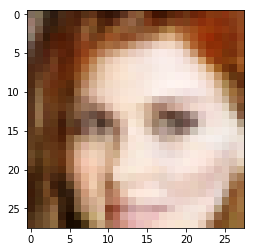

Epoch 11/25... Discriminator Loss: 1.4462... Generator Loss: 0.5925
Epoch 11/25... Discriminator Loss: 1.5972... Generator Loss: 0.5149
Epoch 11/25... Discriminator Loss: 1.3850... Generator Loss: 0.6538
Epoch 11/25... Discriminator Loss: 1.4249... Generator Loss: 0.6065


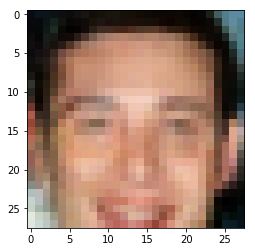

Epoch 11/25... Discriminator Loss: 1.4975... Generator Loss: 0.6442
Epoch 11/25... Discriminator Loss: 1.3380... Generator Loss: 0.7100
Epoch 11/25... Discriminator Loss: 1.4633... Generator Loss: 0.5463
Epoch 11/25... Discriminator Loss: 1.3840... Generator Loss: 0.6824


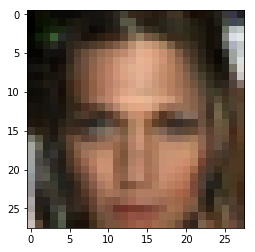

Epoch 11/25... Discriminator Loss: 1.4395... Generator Loss: 0.6682
Epoch 11/25... Discriminator Loss: 1.2995... Generator Loss: 0.6897
Epoch 11/25... Discriminator Loss: 1.3681... Generator Loss: 0.6395
Epoch 11/25... Discriminator Loss: 1.2844... Generator Loss: 0.9459


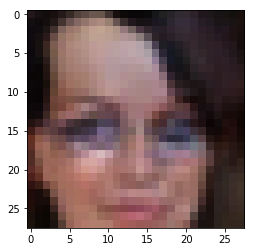

Epoch 11/25... Discriminator Loss: 1.3823... Generator Loss: 0.7764
Epoch 11/25... Discriminator Loss: 1.1447... Generator Loss: 0.8012
Epoch 11/25... Discriminator Loss: 1.2727... Generator Loss: 0.8734
Epoch 11/25... Discriminator Loss: 1.4858... Generator Loss: 0.6389


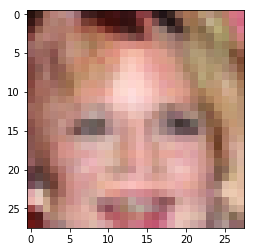

Epoch 11/25... Discriminator Loss: 1.3803... Generator Loss: 0.6793
Epoch 11/25... Discriminator Loss: 1.3351... Generator Loss: 0.8321
Epoch 11/25... Discriminator Loss: 1.3312... Generator Loss: 0.7154
Epoch 11/25... Discriminator Loss: 1.3928... Generator Loss: 0.6371


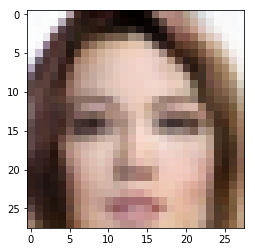

Epoch 11/25... Discriminator Loss: 1.3243... Generator Loss: 0.7405
Epoch 11/25... Discriminator Loss: 1.3397... Generator Loss: 0.7325
Epoch 11/25... Discriminator Loss: 1.3872... Generator Loss: 0.7298
Epoch 11/25... Discriminator Loss: 1.4403... Generator Loss: 0.6749


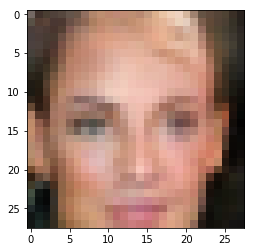

Epoch 11/25... Discriminator Loss: 1.2982... Generator Loss: 0.7991
Epoch 11/25... Discriminator Loss: 1.4427... Generator Loss: 0.6109
Epoch 11/25... Discriminator Loss: 1.3367... Generator Loss: 0.6649
Epoch 11/25... Discriminator Loss: 1.4007... Generator Loss: 0.6630


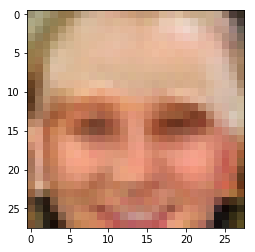

Epoch 11/25... Discriminator Loss: 1.4355... Generator Loss: 0.7438
Epoch 11/25... Discriminator Loss: 1.4201... Generator Loss: 0.6303
Epoch 11/25... Discriminator Loss: 1.4836... Generator Loss: 0.6988
Epoch 11/25... Discriminator Loss: 1.3083... Generator Loss: 0.7182


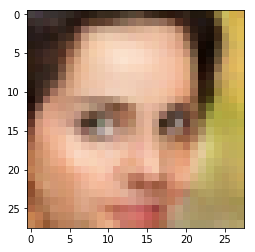

Epoch 11/25... Discriminator Loss: 1.2699... Generator Loss: 0.7445
Epoch 11/25... Discriminator Loss: 1.4038... Generator Loss: 0.5788
Epoch 11/25... Discriminator Loss: 1.3925... Generator Loss: 0.7426
Epoch 11/25... Discriminator Loss: 1.3862... Generator Loss: 0.6514


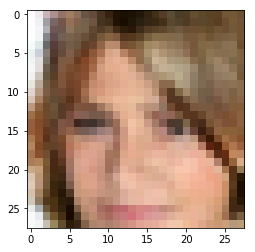

Epoch 11/25... Discriminator Loss: 1.3478... Generator Loss: 0.6997
Epoch 11/25... Discriminator Loss: 1.3682... Generator Loss: 0.7935
Epoch 11/25... Discriminator Loss: 1.3087... Generator Loss: 0.7417
Epoch 11/25... Discriminator Loss: 1.2817... Generator Loss: 0.7466


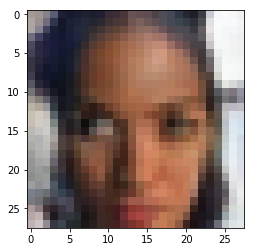

Epoch 11/25... Discriminator Loss: 1.2718... Generator Loss: 0.9110
Epoch 11/25... Discriminator Loss: 1.3257... Generator Loss: 0.8152
Epoch 11/25... Discriminator Loss: 1.3132... Generator Loss: 0.6895
Epoch 11/25... Discriminator Loss: 1.3001... Generator Loss: 0.7979


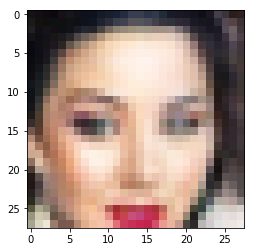

Epoch 11/25... Discriminator Loss: 1.4264... Generator Loss: 0.6309
Epoch 11/25... Discriminator Loss: 1.3521... Generator Loss: 0.7230
Epoch 11/25... Discriminator Loss: 1.3873... Generator Loss: 0.6794
Epoch 11/25... Discriminator Loss: 1.4248... Generator Loss: 0.6489


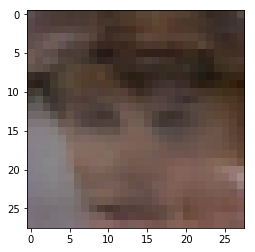

Epoch 11/25... Discriminator Loss: 1.4366... Generator Loss: 0.6111
Epoch 11/25... Discriminator Loss: 1.3503... Generator Loss: 0.6642
Epoch 11/25... Discriminator Loss: 1.2597... Generator Loss: 0.8004
Epoch 11/25... Discriminator Loss: 1.3119... Generator Loss: 0.7699


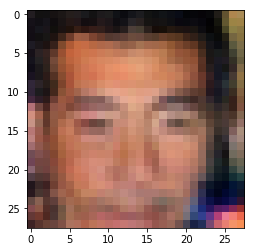

Epoch 12/25... Discriminator Loss: 1.4146... Generator Loss: 0.6833
Epoch 12/25... Discriminator Loss: 1.3499... Generator Loss: 0.7226
Epoch 12/25... Discriminator Loss: 1.4734... Generator Loss: 0.6150
Epoch 12/25... Discriminator Loss: 1.3263... Generator Loss: 0.6270


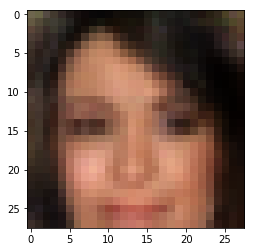

Epoch 12/25... Discriminator Loss: 1.2768... Generator Loss: 0.7527
Epoch 12/25... Discriminator Loss: 1.4697... Generator Loss: 0.6229
Epoch 12/25... Discriminator Loss: 1.3032... Generator Loss: 0.8720
Epoch 12/25... Discriminator Loss: 1.4726... Generator Loss: 0.5648


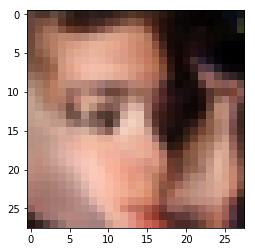

Epoch 12/25... Discriminator Loss: 1.3188... Generator Loss: 0.8244
Epoch 12/25... Discriminator Loss: 1.3477... Generator Loss: 0.7395
Epoch 12/25... Discriminator Loss: 1.1376... Generator Loss: 0.9819
Epoch 12/25... Discriminator Loss: 1.3249... Generator Loss: 0.7978


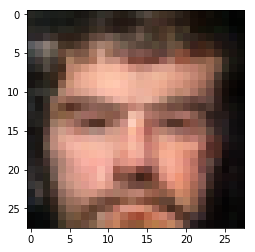

Epoch 12/25... Discriminator Loss: 1.2488... Generator Loss: 0.7954
Epoch 12/25... Discriminator Loss: 1.4780... Generator Loss: 0.6480
Epoch 12/25... Discriminator Loss: 1.3699... Generator Loss: 0.6532
Epoch 12/25... Discriminator Loss: 1.2699... Generator Loss: 0.7797


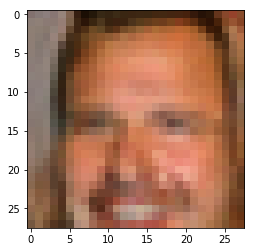

Epoch 12/25... Discriminator Loss: 1.3307... Generator Loss: 0.8877
Epoch 12/25... Discriminator Loss: 1.3308... Generator Loss: 0.7146
Epoch 12/25... Discriminator Loss: 1.4548... Generator Loss: 0.6470
Epoch 12/25... Discriminator Loss: 1.3185... Generator Loss: 0.6359


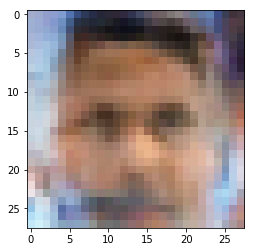

Epoch 12/25... Discriminator Loss: 1.3363... Generator Loss: 0.8022
Epoch 12/25... Discriminator Loss: 1.3646... Generator Loss: 0.6245
Epoch 12/25... Discriminator Loss: 1.2716... Generator Loss: 0.7698
Epoch 12/25... Discriminator Loss: 1.3055... Generator Loss: 0.7555


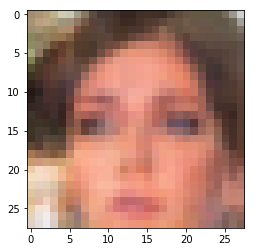

Epoch 12/25... Discriminator Loss: 1.3585... Generator Loss: 0.6436
Epoch 12/25... Discriminator Loss: 1.4297... Generator Loss: 0.6088
Epoch 12/25... Discriminator Loss: 1.4118... Generator Loss: 0.6219
Epoch 12/25... Discriminator Loss: 1.3585... Generator Loss: 0.8298


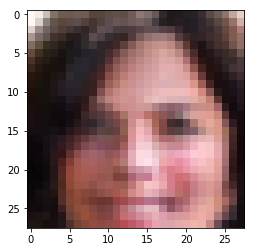

Epoch 12/25... Discriminator Loss: 1.3402... Generator Loss: 0.7417
Epoch 12/25... Discriminator Loss: 1.4149... Generator Loss: 0.6000
Epoch 12/25... Discriminator Loss: 1.4199... Generator Loss: 0.7169
Epoch 12/25... Discriminator Loss: 1.2860... Generator Loss: 0.8366


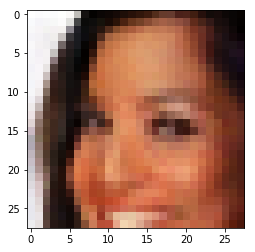

Epoch 12/25... Discriminator Loss: 1.4147... Generator Loss: 0.5757
Epoch 12/25... Discriminator Loss: 1.5713... Generator Loss: 0.5590
Epoch 12/25... Discriminator Loss: 1.3339... Generator Loss: 0.7274
Epoch 12/25... Discriminator Loss: 1.2940... Generator Loss: 0.7664


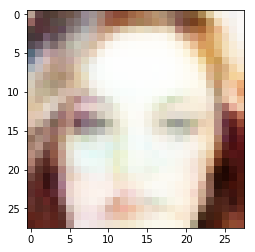

Epoch 12/25... Discriminator Loss: 1.3990... Generator Loss: 0.7515
Epoch 12/25... Discriminator Loss: 1.3982... Generator Loss: 0.6651
Epoch 12/25... Discriminator Loss: 1.3272... Generator Loss: 0.6693
Epoch 12/25... Discriminator Loss: 1.3478... Generator Loss: 0.7829


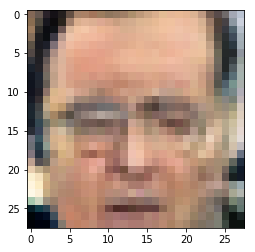

Epoch 12/25... Discriminator Loss: 1.4493... Generator Loss: 0.5722
Epoch 12/25... Discriminator Loss: 1.3592... Generator Loss: 0.6308
Epoch 12/25... Discriminator Loss: 1.3854... Generator Loss: 0.7359
Epoch 12/25... Discriminator Loss: 1.3434... Generator Loss: 0.6874


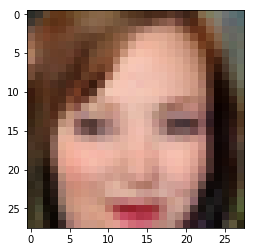

Epoch 12/25... Discriminator Loss: 1.4650... Generator Loss: 0.5763
Epoch 12/25... Discriminator Loss: 1.3571... Generator Loss: 0.6740
Epoch 12/25... Discriminator Loss: 1.3276... Generator Loss: 0.7949
Epoch 12/25... Discriminator Loss: 1.3659... Generator Loss: 0.7235


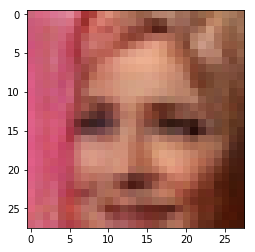

Epoch 12/25... Discriminator Loss: 1.4150... Generator Loss: 0.6349
Epoch 12/25... Discriminator Loss: 1.3439... Generator Loss: 0.7813
Epoch 12/25... Discriminator Loss: 1.4102... Generator Loss: 0.6422
Epoch 12/25... Discriminator Loss: 1.2296... Generator Loss: 0.8510


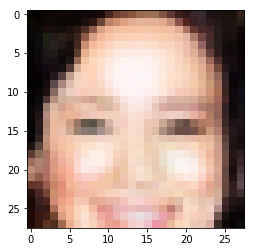

Epoch 12/25... Discriminator Loss: 1.4521... Generator Loss: 0.6316
Epoch 12/25... Discriminator Loss: 1.4287... Generator Loss: 0.6640
Epoch 12/25... Discriminator Loss: 1.4066... Generator Loss: 0.6982
Epoch 12/25... Discriminator Loss: 1.4336... Generator Loss: 0.6534


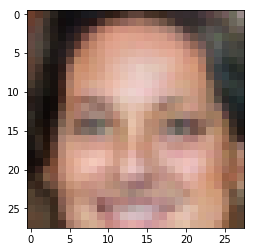

Epoch 12/25... Discriminator Loss: 1.3890... Generator Loss: 0.6356
Epoch 12/25... Discriminator Loss: 1.3116... Generator Loss: 0.8777
Epoch 12/25... Discriminator Loss: 1.3186... Generator Loss: 0.7863
Epoch 12/25... Discriminator Loss: 1.3503... Generator Loss: 0.7444


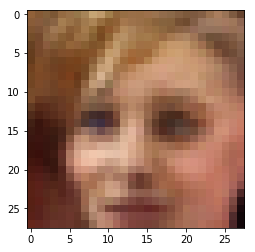

Epoch 12/25... Discriminator Loss: 1.4013... Generator Loss: 0.6793
Epoch 12/25... Discriminator Loss: 1.3594... Generator Loss: 0.7068
Epoch 12/25... Discriminator Loss: 1.4850... Generator Loss: 0.7021
Epoch 13/25... Discriminator Loss: 1.3747... Generator Loss: 0.6640


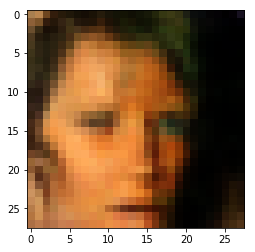

Epoch 13/25... Discriminator Loss: 1.4039... Generator Loss: 0.6495
Epoch 13/25... Discriminator Loss: 1.4375... Generator Loss: 0.7509
Epoch 13/25... Discriminator Loss: 1.4298... Generator Loss: 0.6173
Epoch 13/25... Discriminator Loss: 1.4121... Generator Loss: 0.5391


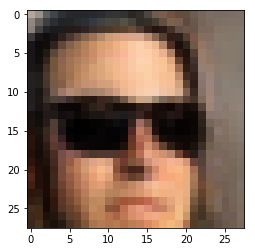

Epoch 13/25... Discriminator Loss: 1.3106... Generator Loss: 0.9335
Epoch 13/25... Discriminator Loss: 1.3017... Generator Loss: 0.8401
Epoch 13/25... Discriminator Loss: 1.4600... Generator Loss: 0.6555
Epoch 13/25... Discriminator Loss: 1.3363... Generator Loss: 0.8051


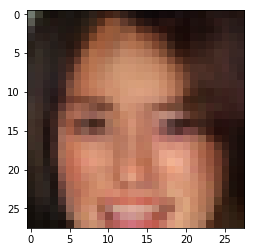

Epoch 13/25... Discriminator Loss: 1.2095... Generator Loss: 0.9173
Epoch 13/25... Discriminator Loss: 1.3535... Generator Loss: 0.6627
Epoch 13/25... Discriminator Loss: 1.3852... Generator Loss: 0.6732
Epoch 13/25... Discriminator Loss: 1.4178... Generator Loss: 0.7016


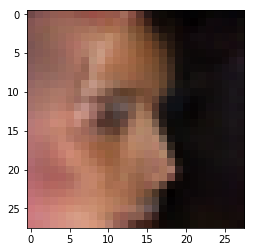

Epoch 13/25... Discriminator Loss: 1.3895... Generator Loss: 0.6827
Epoch 13/25... Discriminator Loss: 1.4472... Generator Loss: 0.6679
Epoch 13/25... Discriminator Loss: 1.4226... Generator Loss: 0.6488
Epoch 13/25... Discriminator Loss: 1.2843... Generator Loss: 0.7105


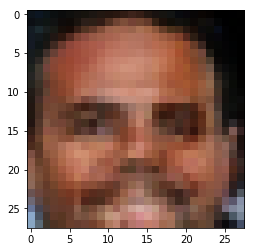

Epoch 13/25... Discriminator Loss: 1.3428... Generator Loss: 0.6705
Epoch 13/25... Discriminator Loss: 1.3513... Generator Loss: 0.6572
Epoch 13/25... Discriminator Loss: 1.3352... Generator Loss: 0.7740
Epoch 13/25... Discriminator Loss: 1.3623... Generator Loss: 0.7299


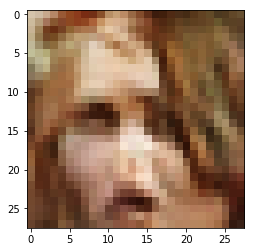

Epoch 13/25... Discriminator Loss: 1.3835... Generator Loss: 0.6424
Epoch 13/25... Discriminator Loss: 1.3312... Generator Loss: 0.7487
Epoch 13/25... Discriminator Loss: 1.3825... Generator Loss: 0.5794
Epoch 13/25... Discriminator Loss: 1.2712... Generator Loss: 0.8835


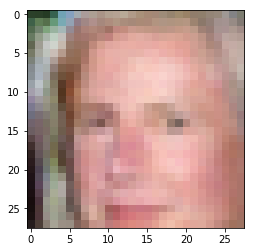

Epoch 13/25... Discriminator Loss: 1.3090... Generator Loss: 0.8910
Epoch 13/25... Discriminator Loss: 1.5516... Generator Loss: 0.5033
Epoch 13/25... Discriminator Loss: 1.3900... Generator Loss: 0.7111
Epoch 13/25... Discriminator Loss: 1.3819... Generator Loss: 0.7619


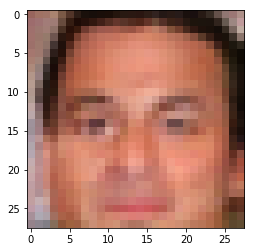

Epoch 13/25... Discriminator Loss: 1.6137... Generator Loss: 0.5440
Epoch 13/25... Discriminator Loss: 1.3318... Generator Loss: 0.7314
Epoch 13/25... Discriminator Loss: 1.4368... Generator Loss: 0.6546
Epoch 13/25... Discriminator Loss: 1.4750... Generator Loss: 0.5574


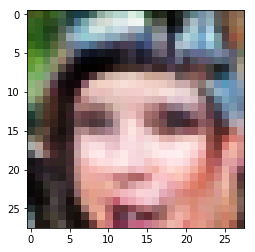

Epoch 13/25... Discriminator Loss: 1.4584... Generator Loss: 0.7796
Epoch 13/25... Discriminator Loss: 1.5051... Generator Loss: 0.6204
Epoch 13/25... Discriminator Loss: 1.3534... Generator Loss: 0.7290
Epoch 13/25... Discriminator Loss: 1.2918... Generator Loss: 0.7260


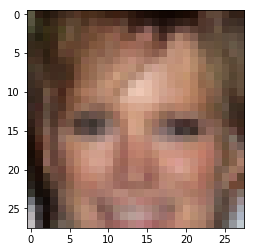

Epoch 13/25... Discriminator Loss: 1.2566... Generator Loss: 0.8463
Epoch 13/25... Discriminator Loss: 1.4122... Generator Loss: 0.5864
Epoch 13/25... Discriminator Loss: 1.3634... Generator Loss: 0.7755
Epoch 13/25... Discriminator Loss: 1.3919... Generator Loss: 0.6527


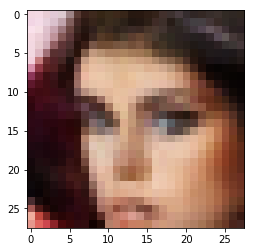

Epoch 13/25... Discriminator Loss: 1.3173... Generator Loss: 0.7360
Epoch 13/25... Discriminator Loss: 1.4440... Generator Loss: 0.6311
Epoch 13/25... Discriminator Loss: 1.4120... Generator Loss: 0.6449
Epoch 13/25... Discriminator Loss: 1.3162... Generator Loss: 0.8144


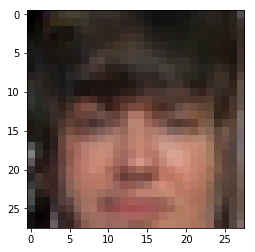

Epoch 13/25... Discriminator Loss: 1.5284... Generator Loss: 0.5131
Epoch 13/25... Discriminator Loss: 1.2824... Generator Loss: 0.8027
Epoch 13/25... Discriminator Loss: 1.3659... Generator Loss: 0.7068
Epoch 13/25... Discriminator Loss: 1.3556... Generator Loss: 0.7336


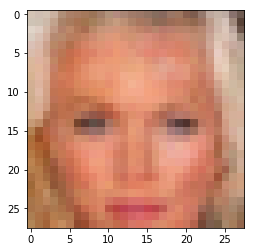

Epoch 13/25... Discriminator Loss: 1.3384... Generator Loss: 0.7673
Epoch 13/25... Discriminator Loss: 1.3428... Generator Loss: 0.6562
Epoch 13/25... Discriminator Loss: 1.4127... Generator Loss: 0.6615
Epoch 13/25... Discriminator Loss: 1.4898... Generator Loss: 0.5515


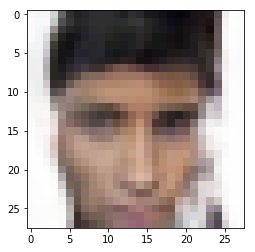

Epoch 13/25... Discriminator Loss: 1.2917... Generator Loss: 0.6776
Epoch 13/25... Discriminator Loss: 1.3064... Generator Loss: 0.7835
Epoch 13/25... Discriminator Loss: 1.4287... Generator Loss: 0.6219
Epoch 13/25... Discriminator Loss: 1.2653... Generator Loss: 0.9188


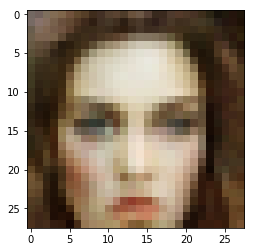

Epoch 13/25... Discriminator Loss: 1.2549... Generator Loss: 0.7537
Epoch 13/25... Discriminator Loss: 1.4084... Generator Loss: 0.6342
Epoch 13/25... Discriminator Loss: 1.3747... Generator Loss: 0.6434
Epoch 13/25... Discriminator Loss: 1.4501... Generator Loss: 0.7169


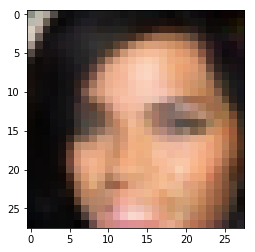

Epoch 13/25... Discriminator Loss: 1.3140... Generator Loss: 0.6716
Epoch 13/25... Discriminator Loss: 1.5215... Generator Loss: 0.6792
Epoch 14/25... Discriminator Loss: 1.3547... Generator Loss: 0.7960
Epoch 14/25... Discriminator Loss: 1.4536... Generator Loss: 0.6023


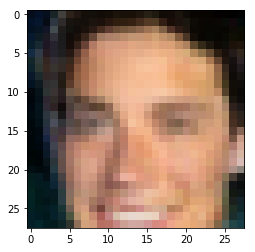

Epoch 14/25... Discriminator Loss: 1.2829... Generator Loss: 0.7282
Epoch 14/25... Discriminator Loss: 1.2559... Generator Loss: 0.7438
Epoch 14/25... Discriminator Loss: 1.3743... Generator Loss: 0.6457
Epoch 14/25... Discriminator Loss: 1.4213... Generator Loss: 0.8845


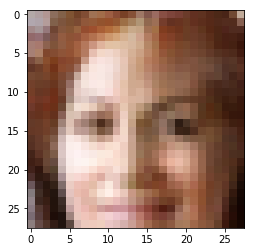

Epoch 14/25... Discriminator Loss: 1.3993... Generator Loss: 0.6538
Epoch 14/25... Discriminator Loss: 1.3918... Generator Loss: 0.6897
Epoch 14/25... Discriminator Loss: 1.4587... Generator Loss: 0.5888
Epoch 14/25... Discriminator Loss: 1.3222... Generator Loss: 0.7453


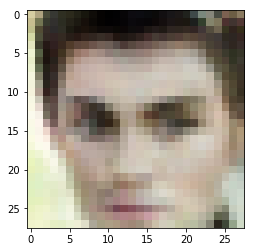

Epoch 14/25... Discriminator Loss: 1.4560... Generator Loss: 0.6571
Epoch 14/25... Discriminator Loss: 1.1909... Generator Loss: 0.8121
Epoch 14/25... Discriminator Loss: 1.3854... Generator Loss: 0.6685
Epoch 14/25... Discriminator Loss: 1.4247... Generator Loss: 0.6776


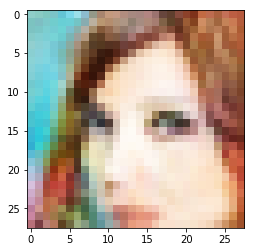

Epoch 14/25... Discriminator Loss: 1.1431... Generator Loss: 0.9828
Epoch 14/25... Discriminator Loss: 1.4338... Generator Loss: 0.6359
Epoch 14/25... Discriminator Loss: 1.2041... Generator Loss: 0.9202
Epoch 14/25... Discriminator Loss: 1.3141... Generator Loss: 0.7104


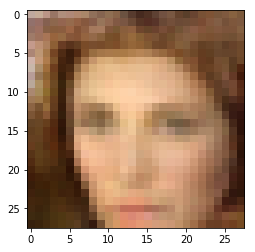

Epoch 14/25... Discriminator Loss: 1.4086... Generator Loss: 0.6592
Epoch 14/25... Discriminator Loss: 1.4777... Generator Loss: 0.5618
Epoch 14/25... Discriminator Loss: 1.3859... Generator Loss: 0.6770
Epoch 14/25... Discriminator Loss: 1.2950... Generator Loss: 0.6994


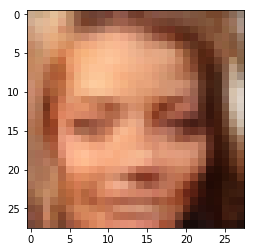

Epoch 14/25... Discriminator Loss: 1.3501... Generator Loss: 0.6392
Epoch 14/25... Discriminator Loss: 1.5626... Generator Loss: 0.4803
Epoch 14/25... Discriminator Loss: 1.3217... Generator Loss: 0.7399
Epoch 14/25... Discriminator Loss: 1.4467... Generator Loss: 0.5676


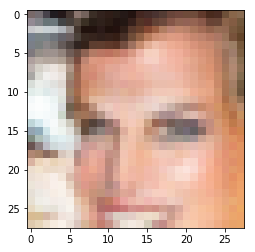

Epoch 14/25... Discriminator Loss: 1.3566... Generator Loss: 0.6566
Epoch 14/25... Discriminator Loss: 1.3950... Generator Loss: 0.6288
Epoch 14/25... Discriminator Loss: 1.2920... Generator Loss: 0.7603
Epoch 14/25... Discriminator Loss: 1.3839... Generator Loss: 0.6412


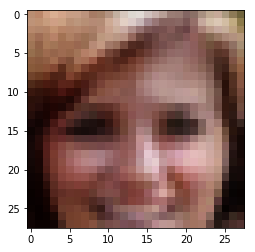

Epoch 14/25... Discriminator Loss: 1.3854... Generator Loss: 0.7739
Epoch 14/25... Discriminator Loss: 1.4147... Generator Loss: 0.6348
Epoch 14/25... Discriminator Loss: 1.3397... Generator Loss: 0.6538
Epoch 14/25... Discriminator Loss: 1.2809... Generator Loss: 0.7986


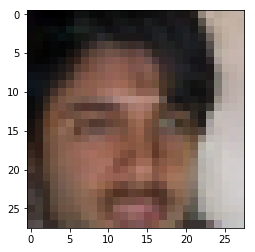

Epoch 14/25... Discriminator Loss: 1.3888... Generator Loss: 0.6698
Epoch 14/25... Discriminator Loss: 1.3351... Generator Loss: 0.7333
Epoch 14/25... Discriminator Loss: 1.3776... Generator Loss: 0.6279
Epoch 14/25... Discriminator Loss: 1.4010... Generator Loss: 0.6693


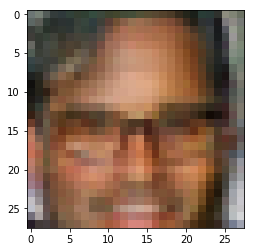

Epoch 14/25... Discriminator Loss: 1.2825... Generator Loss: 0.8376
Epoch 14/25... Discriminator Loss: 1.3611... Generator Loss: 0.6119
Epoch 14/25... Discriminator Loss: 1.2614... Generator Loss: 0.8433
Epoch 14/25... Discriminator Loss: 1.2763... Generator Loss: 0.7605


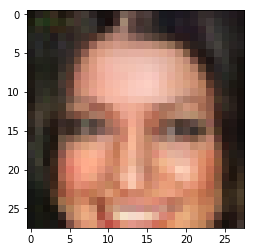

Epoch 14/25... Discriminator Loss: 1.2788... Generator Loss: 0.8355
Epoch 14/25... Discriminator Loss: 1.4362... Generator Loss: 0.5849
Epoch 14/25... Discriminator Loss: 1.4705... Generator Loss: 0.5624
Epoch 14/25... Discriminator Loss: 1.3688... Generator Loss: 0.6246


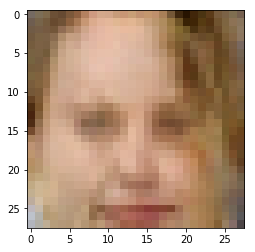

Epoch 14/25... Discriminator Loss: 1.2615... Generator Loss: 0.8048
Epoch 14/25... Discriminator Loss: 1.4182... Generator Loss: 0.6570
Epoch 14/25... Discriminator Loss: 1.4660... Generator Loss: 0.5681
Epoch 14/25... Discriminator Loss: 1.5214... Generator Loss: 0.5220


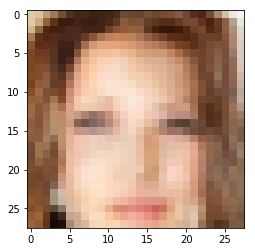

Epoch 14/25... Discriminator Loss: 1.4587... Generator Loss: 0.5739
Epoch 14/25... Discriminator Loss: 1.1467... Generator Loss: 0.8201
Epoch 14/25... Discriminator Loss: 1.3452... Generator Loss: 0.6825
Epoch 14/25... Discriminator Loss: 1.3810... Generator Loss: 0.6932


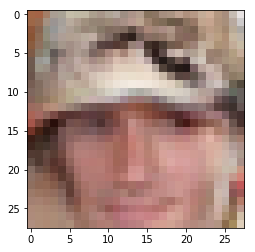

Epoch 14/25... Discriminator Loss: 1.3260... Generator Loss: 0.7828
Epoch 14/25... Discriminator Loss: 1.3905... Generator Loss: 0.6144
Epoch 14/25... Discriminator Loss: 1.4091... Generator Loss: 0.7244
Epoch 14/25... Discriminator Loss: 1.3108... Generator Loss: 0.7114


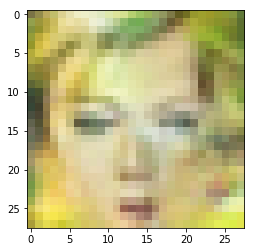

Epoch 14/25... Discriminator Loss: 1.3675... Generator Loss: 0.6300
Epoch 14/25... Discriminator Loss: 1.3587... Generator Loss: 0.7210
Epoch 14/25... Discriminator Loss: 1.4967... Generator Loss: 0.6129
Epoch 14/25... Discriminator Loss: 1.4095... Generator Loss: 0.6237


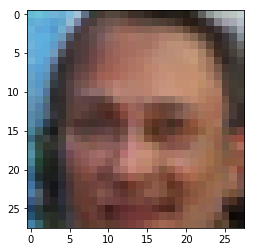

Epoch 14/25... Discriminator Loss: 1.4649... Generator Loss: 0.5656
Epoch 14/25... Discriminator Loss: 1.3111... Generator Loss: 0.7239
Epoch 15/25... Discriminator Loss: 1.3840... Generator Loss: 0.6755
Epoch 15/25... Discriminator Loss: 1.3617... Generator Loss: 0.6098


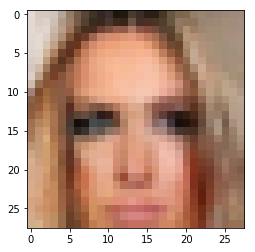

Epoch 15/25... Discriminator Loss: 1.3544... Generator Loss: 0.7292
Epoch 15/25... Discriminator Loss: 1.3973... Generator Loss: 0.6649
Epoch 15/25... Discriminator Loss: 1.4644... Generator Loss: 0.6332
Epoch 15/25... Discriminator Loss: 1.2162... Generator Loss: 0.9162


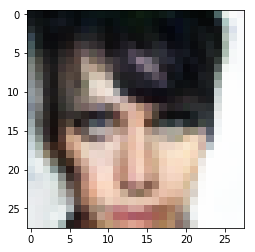

Epoch 15/25... Discriminator Loss: 1.2995... Generator Loss: 0.7179
Epoch 15/25... Discriminator Loss: 1.3204... Generator Loss: 0.7045
Epoch 15/25... Discriminator Loss: 1.3963... Generator Loss: 0.6163
Epoch 15/25... Discriminator Loss: 1.3699... Generator Loss: 0.6770


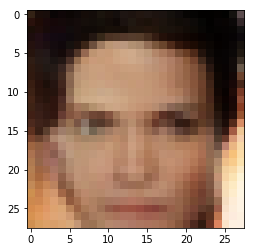

Epoch 15/25... Discriminator Loss: 1.5053... Generator Loss: 0.5708
Epoch 15/25... Discriminator Loss: 1.3317... Generator Loss: 0.7441
Epoch 15/25... Discriminator Loss: 1.3872... Generator Loss: 0.6262
Epoch 15/25... Discriminator Loss: 1.3771... Generator Loss: 0.6666


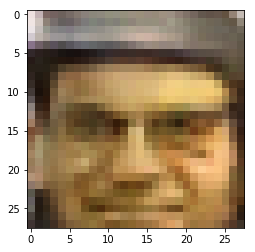

Epoch 15/25... Discriminator Loss: 1.3743... Generator Loss: 0.6494
Epoch 15/25... Discriminator Loss: 1.3381... Generator Loss: 0.7930
Epoch 15/25... Discriminator Loss: 1.3411... Generator Loss: 0.7544
Epoch 15/25... Discriminator Loss: 1.3983... Generator Loss: 0.6349


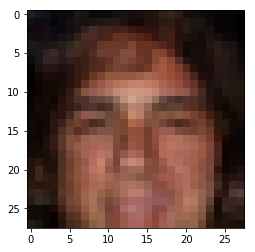

Epoch 15/25... Discriminator Loss: 1.2383... Generator Loss: 0.8899
Epoch 15/25... Discriminator Loss: 1.4156... Generator Loss: 0.6069
Epoch 15/25... Discriminator Loss: 1.3780... Generator Loss: 0.6812
Epoch 15/25... Discriminator Loss: 1.2655... Generator Loss: 0.7760


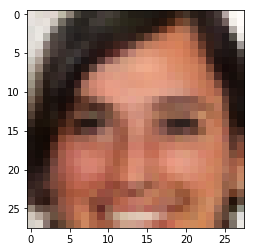

Epoch 15/25... Discriminator Loss: 1.3827... Generator Loss: 0.6539
Epoch 15/25... Discriminator Loss: 1.3264... Generator Loss: 0.6876
Epoch 15/25... Discriminator Loss: 1.3181... Generator Loss: 0.7254
Epoch 15/25... Discriminator Loss: 1.4690... Generator Loss: 0.6236


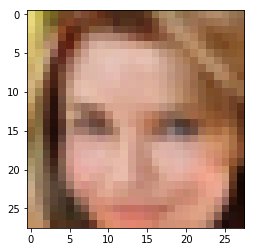

Epoch 15/25... Discriminator Loss: 1.3521... Generator Loss: 0.7747
Epoch 15/25... Discriminator Loss: 1.4128... Generator Loss: 0.6453
Epoch 15/25... Discriminator Loss: 1.3494... Generator Loss: 0.7213
Epoch 15/25... Discriminator Loss: 1.4087... Generator Loss: 0.7180


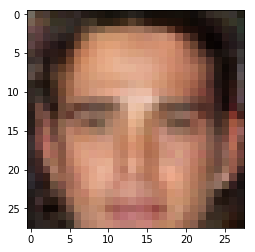

Epoch 15/25... Discriminator Loss: 1.3506... Generator Loss: 0.6270
Epoch 15/25... Discriminator Loss: 1.7493... Generator Loss: 0.4091
Epoch 15/25... Discriminator Loss: 1.2430... Generator Loss: 0.7850
Epoch 15/25... Discriminator Loss: 1.3524... Generator Loss: 0.8315


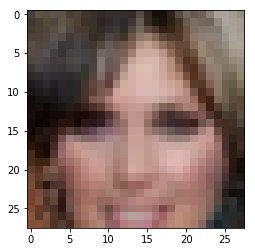

Epoch 15/25... Discriminator Loss: 1.2390... Generator Loss: 0.8933
Epoch 15/25... Discriminator Loss: 1.2782... Generator Loss: 0.8182
Epoch 15/25... Discriminator Loss: 1.3053... Generator Loss: 0.6916
Epoch 15/25... Discriminator Loss: 1.3842... Generator Loss: 0.6033


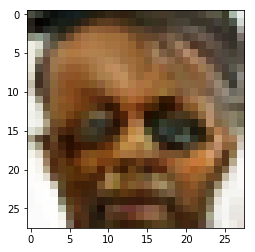

Epoch 15/25... Discriminator Loss: 1.3435... Generator Loss: 0.6990
Epoch 15/25... Discriminator Loss: 1.2232... Generator Loss: 0.7217
Epoch 15/25... Discriminator Loss: 1.2800... Generator Loss: 0.8944
Epoch 15/25... Discriminator Loss: 1.2908... Generator Loss: 0.7230


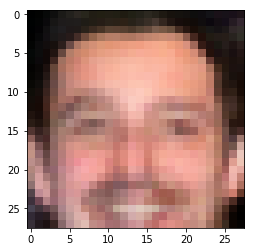

Epoch 15/25... Discriminator Loss: 1.3383... Generator Loss: 0.7485
Epoch 15/25... Discriminator Loss: 1.3631... Generator Loss: 0.7724
Epoch 15/25... Discriminator Loss: 1.5738... Generator Loss: 0.5824
Epoch 15/25... Discriminator Loss: 1.3683... Generator Loss: 0.6783


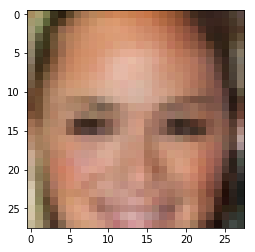

Epoch 15/25... Discriminator Loss: 1.1995... Generator Loss: 0.9566
Epoch 15/25... Discriminator Loss: 1.3374... Generator Loss: 0.7045
Epoch 15/25... Discriminator Loss: 1.3656... Generator Loss: 0.6831
Epoch 15/25... Discriminator Loss: 1.3494... Generator Loss: 0.6567


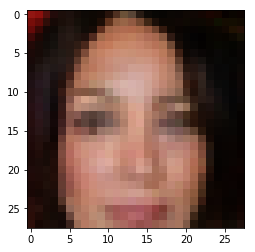

Epoch 15/25... Discriminator Loss: 1.4134... Generator Loss: 0.7102
Epoch 15/25... Discriminator Loss: 1.4936... Generator Loss: 0.5408
Epoch 15/25... Discriminator Loss: 1.5164... Generator Loss: 0.6121
Epoch 15/25... Discriminator Loss: 1.2950... Generator Loss: 0.7727


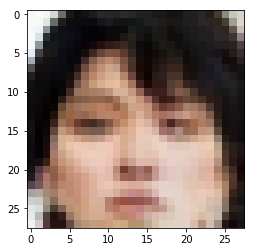

Epoch 15/25... Discriminator Loss: 1.2846... Generator Loss: 0.8335
Epoch 15/25... Discriminator Loss: 1.3629... Generator Loss: 0.6353
Epoch 15/25... Discriminator Loss: 1.3607... Generator Loss: 0.7008
Epoch 15/25... Discriminator Loss: 1.4655... Generator Loss: 0.6489


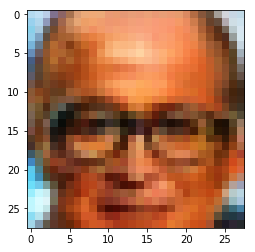

Epoch 15/25... Discriminator Loss: 1.3716... Generator Loss: 0.7334
Epoch 15/25... Discriminator Loss: 1.3522... Generator Loss: 0.6413
Epoch 15/25... Discriminator Loss: 1.2370... Generator Loss: 0.8048
Epoch 15/25... Discriminator Loss: 1.3533... Generator Loss: 0.6887


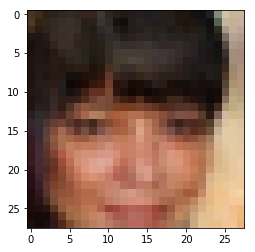

Epoch 15/25... Discriminator Loss: 1.3613... Generator Loss: 0.6951
Epoch 16/25... Discriminator Loss: 1.3403... Generator Loss: 0.6462
Epoch 16/25... Discriminator Loss: 1.3886... Generator Loss: 0.7129
Epoch 16/25... Discriminator Loss: 1.5671... Generator Loss: 0.4974


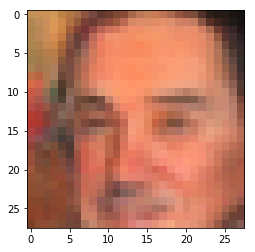

Epoch 16/25... Discriminator Loss: 1.3807... Generator Loss: 0.7064
Epoch 16/25... Discriminator Loss: 1.5508... Generator Loss: 0.6604
Epoch 16/25... Discriminator Loss: 1.4260... Generator Loss: 0.6618
Epoch 16/25... Discriminator Loss: 1.4096... Generator Loss: 0.6179


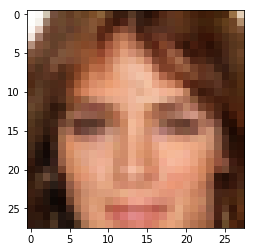

Epoch 16/25... Discriminator Loss: 1.5082... Generator Loss: 0.5529
Epoch 16/25... Discriminator Loss: 1.4731... Generator Loss: 0.6478
Epoch 16/25... Discriminator Loss: 1.2905... Generator Loss: 0.8369
Epoch 16/25... Discriminator Loss: 1.3001... Generator Loss: 0.6732


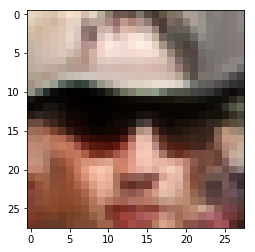

Epoch 16/25... Discriminator Loss: 1.2587... Generator Loss: 0.8369
Epoch 16/25... Discriminator Loss: 1.4917... Generator Loss: 0.5543
Epoch 16/25... Discriminator Loss: 1.3828... Generator Loss: 0.6506
Epoch 16/25... Discriminator Loss: 1.4367... Generator Loss: 0.6137


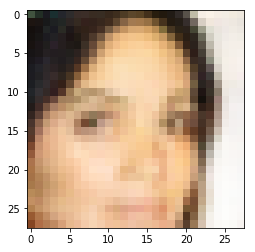

Epoch 16/25... Discriminator Loss: 1.3537... Generator Loss: 0.7209
Epoch 16/25... Discriminator Loss: 1.3825... Generator Loss: 0.6080
Epoch 16/25... Discriminator Loss: 1.3608... Generator Loss: 0.6871
Epoch 16/25... Discriminator Loss: 1.3125... Generator Loss: 0.6842


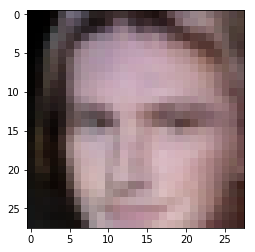

Epoch 16/25... Discriminator Loss: 1.2290... Generator Loss: 0.7759
Epoch 16/25... Discriminator Loss: 1.4084... Generator Loss: 0.6583
Epoch 16/25... Discriminator Loss: 1.3529... Generator Loss: 0.7688
Epoch 16/25... Discriminator Loss: 1.3917... Generator Loss: 0.6532


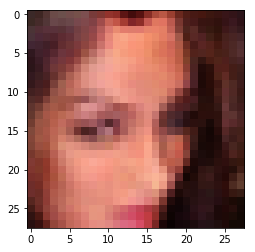

Epoch 16/25... Discriminator Loss: 1.3108... Generator Loss: 0.7520
Epoch 16/25... Discriminator Loss: 1.3231... Generator Loss: 0.7150
Epoch 16/25... Discriminator Loss: 1.4167... Generator Loss: 0.5660
Epoch 16/25... Discriminator Loss: 1.3529... Generator Loss: 0.7066


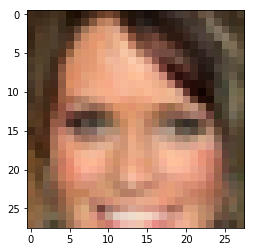

Epoch 16/25... Discriminator Loss: 1.3371... Generator Loss: 0.6777
Epoch 16/25... Discriminator Loss: 1.3866... Generator Loss: 0.5531
Epoch 16/25... Discriminator Loss: 1.5300... Generator Loss: 0.6192
Epoch 16/25... Discriminator Loss: 1.3712... Generator Loss: 0.6219


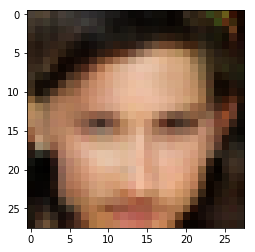

Epoch 16/25... Discriminator Loss: 1.0166... Generator Loss: 0.8855
Epoch 16/25... Discriminator Loss: 1.4249... Generator Loss: 0.6549
Epoch 16/25... Discriminator Loss: 1.6038... Generator Loss: 0.5104
Epoch 16/25... Discriminator Loss: 1.3439... Generator Loss: 0.6907


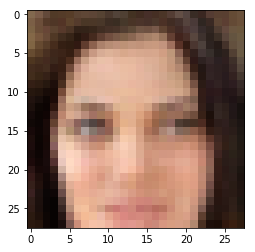

Epoch 16/25... Discriminator Loss: 1.2333... Generator Loss: 0.8409
Epoch 16/25... Discriminator Loss: 1.4728... Generator Loss: 0.6535
Epoch 16/25... Discriminator Loss: 1.3805... Generator Loss: 0.7445
Epoch 16/25... Discriminator Loss: 1.3941... Generator Loss: 0.7187


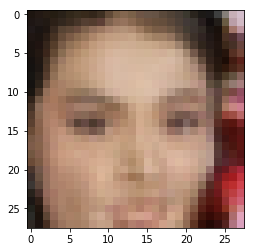

Epoch 16/25... Discriminator Loss: 1.3683... Generator Loss: 0.7101
Epoch 16/25... Discriminator Loss: 1.5011... Generator Loss: 0.5685
Epoch 16/25... Discriminator Loss: 1.4075... Generator Loss: 0.5966
Epoch 16/25... Discriminator Loss: 1.4005... Generator Loss: 0.5829


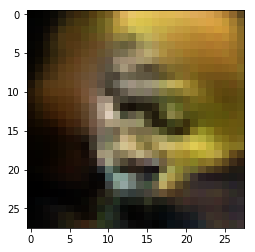

Epoch 16/25... Discriminator Loss: 1.2346... Generator Loss: 0.8205
Epoch 16/25... Discriminator Loss: 1.3978... Generator Loss: 0.7864
Epoch 16/25... Discriminator Loss: 1.3551... Generator Loss: 0.7562
Epoch 16/25... Discriminator Loss: 1.3704... Generator Loss: 0.6073


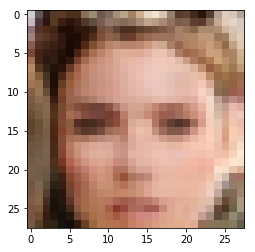

Epoch 16/25... Discriminator Loss: 1.3213... Generator Loss: 0.7431
Epoch 16/25... Discriminator Loss: 1.3790... Generator Loss: 0.7671
Epoch 16/25... Discriminator Loss: 1.4356... Generator Loss: 0.6827
Epoch 16/25... Discriminator Loss: 1.4615... Generator Loss: 0.7044


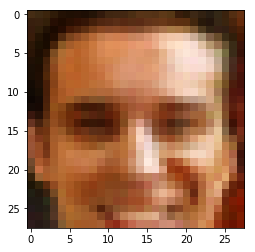

Epoch 16/25... Discriminator Loss: 1.3510... Generator Loss: 0.7319
Epoch 16/25... Discriminator Loss: 1.4211... Generator Loss: 0.6185
Epoch 16/25... Discriminator Loss: 1.4118... Generator Loss: 0.6723
Epoch 16/25... Discriminator Loss: 1.4899... Generator Loss: 0.5826


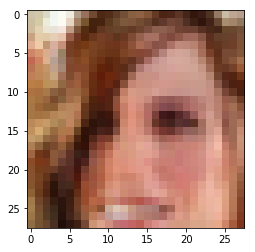

Epoch 16/25... Discriminator Loss: 1.2066... Generator Loss: 0.8813
Epoch 16/25... Discriminator Loss: 1.2530... Generator Loss: 0.7513
Epoch 16/25... Discriminator Loss: 1.4785... Generator Loss: 0.5375
Epoch 16/25... Discriminator Loss: 1.3301... Generator Loss: 0.6956


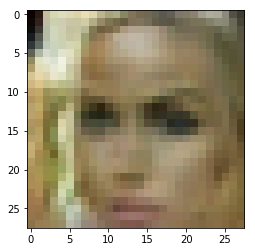

Epoch 16/25... Discriminator Loss: 1.4274... Generator Loss: 0.6837
Epoch 16/25... Discriminator Loss: 1.5000... Generator Loss: 0.5556
Epoch 16/25... Discriminator Loss: 1.4280... Generator Loss: 0.5883
Epoch 16/25... Discriminator Loss: 1.4984... Generator Loss: 0.5397


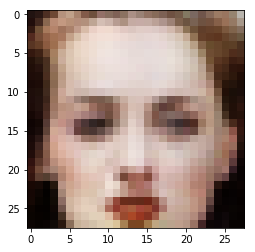

Epoch 17/25... Discriminator Loss: 1.2702... Generator Loss: 0.8324
Epoch 17/25... Discriminator Loss: 1.3498... Generator Loss: 0.6730
Epoch 17/25... Discriminator Loss: 1.2679... Generator Loss: 0.8786
Epoch 17/25... Discriminator Loss: 1.3336... Generator Loss: 0.7158


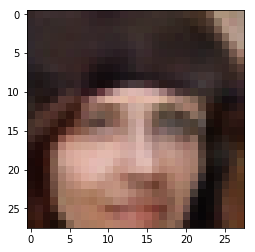

Epoch 17/25... Discriminator Loss: 1.3358... Generator Loss: 0.7029
Epoch 17/25... Discriminator Loss: 1.3487... Generator Loss: 0.7364
Epoch 17/25... Discriminator Loss: 1.5685... Generator Loss: 0.4954
Epoch 17/25... Discriminator Loss: 1.3731... Generator Loss: 0.6145


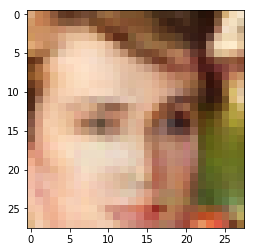

Epoch 17/25... Discriminator Loss: 1.3182... Generator Loss: 0.6902
Epoch 17/25... Discriminator Loss: 1.3072... Generator Loss: 0.6832
Epoch 17/25... Discriminator Loss: 1.2371... Generator Loss: 0.8041
Epoch 17/25... Discriminator Loss: 1.3492... Generator Loss: 0.6288


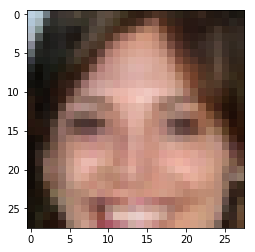

Epoch 17/25... Discriminator Loss: 1.4424... Generator Loss: 0.6972
Epoch 17/25... Discriminator Loss: 1.3870... Generator Loss: 0.6564
Epoch 17/25... Discriminator Loss: 1.3783... Generator Loss: 0.6652
Epoch 17/25... Discriminator Loss: 1.4499... Generator Loss: 0.6335


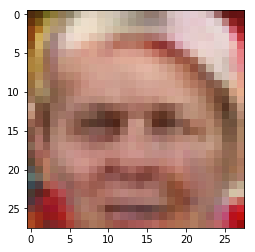

Epoch 17/25... Discriminator Loss: 1.7458... Generator Loss: 0.4094
Epoch 17/25... Discriminator Loss: 1.4321... Generator Loss: 0.6111
Epoch 17/25... Discriminator Loss: 1.2952... Generator Loss: 0.7709
Epoch 17/25... Discriminator Loss: 1.3354... Generator Loss: 0.7492


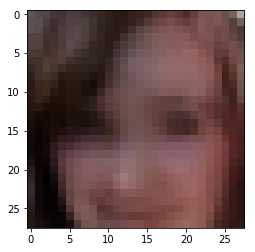

Epoch 17/25... Discriminator Loss: 1.3774... Generator Loss: 0.7194
Epoch 17/25... Discriminator Loss: 1.2526... Generator Loss: 0.7643
Epoch 17/25... Discriminator Loss: 1.3190... Generator Loss: 0.6634
Epoch 17/25... Discriminator Loss: 1.4315... Generator Loss: 0.6191


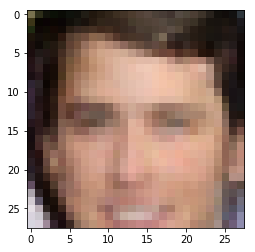

Epoch 17/25... Discriminator Loss: 1.4830... Generator Loss: 0.6170
Epoch 17/25... Discriminator Loss: 1.3120... Generator Loss: 0.7483
Epoch 17/25... Discriminator Loss: 1.3456... Generator Loss: 0.7161
Epoch 17/25... Discriminator Loss: 1.4005... Generator Loss: 0.6531


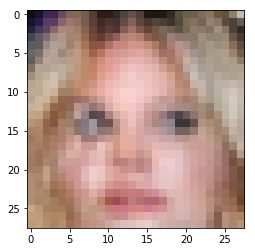

Epoch 17/25... Discriminator Loss: 1.3406... Generator Loss: 0.7340
Epoch 17/25... Discriminator Loss: 1.4925... Generator Loss: 0.6398
Epoch 17/25... Discriminator Loss: 1.2844... Generator Loss: 0.8723
Epoch 17/25... Discriminator Loss: 1.4014... Generator Loss: 0.5974


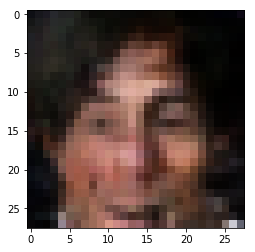

Epoch 17/25... Discriminator Loss: 1.3692... Generator Loss: 0.7840
Epoch 17/25... Discriminator Loss: 1.4053... Generator Loss: 0.6593
Epoch 17/25... Discriminator Loss: 1.4544... Generator Loss: 0.6161
Epoch 17/25... Discriminator Loss: 1.1590... Generator Loss: 0.9135


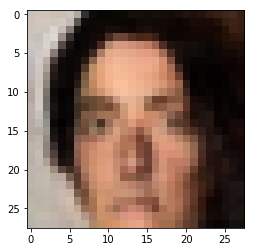

Epoch 17/25... Discriminator Loss: 1.2683... Generator Loss: 0.7792
Epoch 17/25... Discriminator Loss: 1.3738... Generator Loss: 0.6463
Epoch 17/25... Discriminator Loss: 1.3761... Generator Loss: 0.6355
Epoch 17/25... Discriminator Loss: 1.3286... Generator Loss: 0.7270


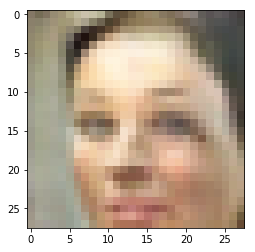

Epoch 17/25... Discriminator Loss: 1.2381... Generator Loss: 0.8123
Epoch 17/25... Discriminator Loss: 1.4430... Generator Loss: 0.5703
Epoch 17/25... Discriminator Loss: 1.3724... Generator Loss: 0.7313
Epoch 17/25... Discriminator Loss: 1.2614... Generator Loss: 0.7525


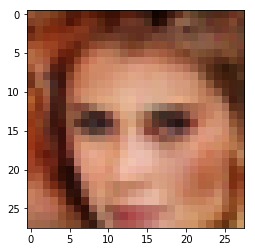

Epoch 17/25... Discriminator Loss: 1.2757... Generator Loss: 0.7015
Epoch 17/25... Discriminator Loss: 1.3223... Generator Loss: 0.7390
Epoch 17/25... Discriminator Loss: 1.2782... Generator Loss: 0.8180
Epoch 17/25... Discriminator Loss: 1.2374... Generator Loss: 0.7719


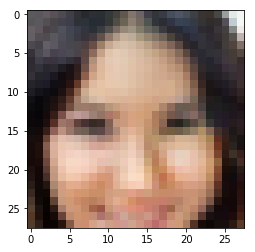

Epoch 17/25... Discriminator Loss: 1.4513... Generator Loss: 0.5933
Epoch 17/25... Discriminator Loss: 1.3650... Generator Loss: 0.7149
Epoch 17/25... Discriminator Loss: 1.3618... Generator Loss: 0.6024
Epoch 17/25... Discriminator Loss: 1.4621... Generator Loss: 0.5590


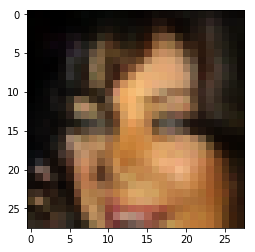

Epoch 17/25... Discriminator Loss: 1.3299... Generator Loss: 0.7247
Epoch 17/25... Discriminator Loss: 1.4343... Generator Loss: 0.7046
Epoch 17/25... Discriminator Loss: 1.4124... Generator Loss: 0.5740
Epoch 17/25... Discriminator Loss: 1.3785... Generator Loss: 0.6378


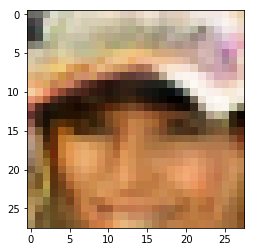

Epoch 17/25... Discriminator Loss: 1.2570... Generator Loss: 0.7602
Epoch 17/25... Discriminator Loss: 1.4045... Generator Loss: 0.6942
Epoch 17/25... Discriminator Loss: 1.3381... Generator Loss: 0.8700
Epoch 17/25... Discriminator Loss: 1.3569... Generator Loss: 0.6263


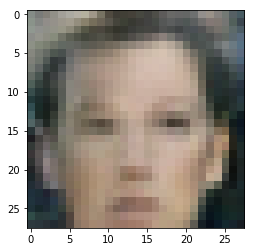

Epoch 17/25... Discriminator Loss: 1.3683... Generator Loss: 0.7232
Epoch 17/25... Discriminator Loss: 1.2868... Generator Loss: 0.8112
Epoch 17/25... Discriminator Loss: 1.3653... Generator Loss: 0.6260
Epoch 17/25... Discriminator Loss: 1.2321... Generator Loss: 0.7780


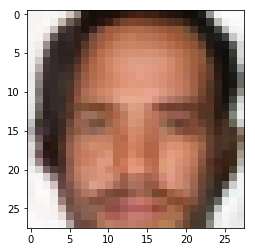

Epoch 18/25... Discriminator Loss: 1.2882... Generator Loss: 0.7214
Epoch 18/25... Discriminator Loss: 1.3210... Generator Loss: 0.7534
Epoch 18/25... Discriminator Loss: 1.3791... Generator Loss: 0.6317
Epoch 18/25... Discriminator Loss: 1.1972... Generator Loss: 0.8174


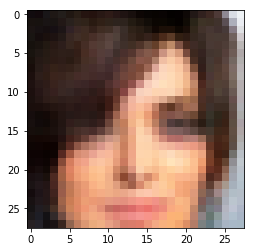

Epoch 18/25... Discriminator Loss: 1.2908... Generator Loss: 0.7225
Epoch 18/25... Discriminator Loss: 1.4430... Generator Loss: 0.6837
Epoch 18/25... Discriminator Loss: 1.3434... Generator Loss: 0.7657
Epoch 18/25... Discriminator Loss: 1.2844... Generator Loss: 0.6945


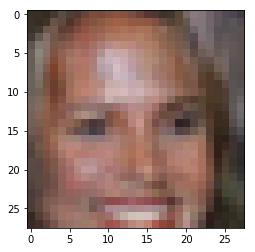

Epoch 18/25... Discriminator Loss: 1.4230... Generator Loss: 0.5618
Epoch 18/25... Discriminator Loss: 1.2238... Generator Loss: 0.9242
Epoch 18/25... Discriminator Loss: 1.1943... Generator Loss: 0.8457
Epoch 18/25... Discriminator Loss: 1.3131... Generator Loss: 0.7550


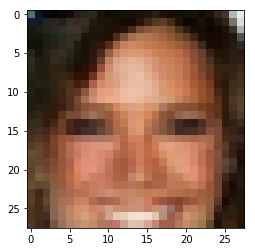

Epoch 18/25... Discriminator Loss: 1.3569... Generator Loss: 0.6929
Epoch 18/25... Discriminator Loss: 1.4450... Generator Loss: 0.6018
Epoch 18/25... Discriminator Loss: 1.4788... Generator Loss: 0.5281
Epoch 18/25... Discriminator Loss: 1.3508... Generator Loss: 0.7449


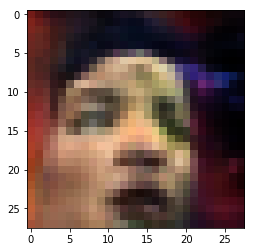

Epoch 18/25... Discriminator Loss: 1.3253... Generator Loss: 0.7126
Epoch 18/25... Discriminator Loss: 1.2770... Generator Loss: 0.6892
Epoch 18/25... Discriminator Loss: 1.4737... Generator Loss: 0.5967
Epoch 18/25... Discriminator Loss: 1.3876... Generator Loss: 0.7026


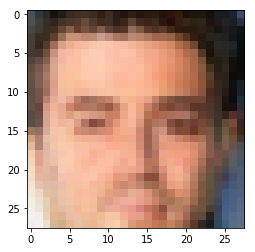

Epoch 18/25... Discriminator Loss: 1.4649... Generator Loss: 0.5895
Epoch 18/25... Discriminator Loss: 1.3950... Generator Loss: 0.7114
Epoch 18/25... Discriminator Loss: 1.3453... Generator Loss: 0.6840
Epoch 18/25... Discriminator Loss: 1.3006... Generator Loss: 0.7956


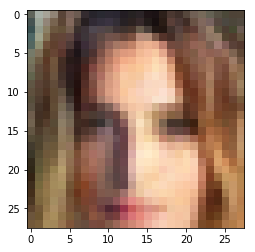

Epoch 18/25... Discriminator Loss: 1.3273... Generator Loss: 0.6382
Epoch 18/25... Discriminator Loss: 1.4528... Generator Loss: 0.5946
Epoch 18/25... Discriminator Loss: 1.3089... Generator Loss: 0.6557
Epoch 18/25... Discriminator Loss: 1.3283... Generator Loss: 0.7602


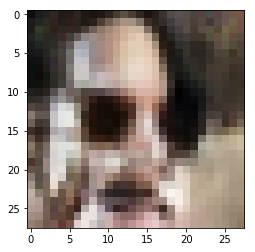

Epoch 18/25... Discriminator Loss: 1.2796... Generator Loss: 0.7225
Epoch 18/25... Discriminator Loss: 1.2748... Generator Loss: 0.8358
Epoch 18/25... Discriminator Loss: 1.3375... Generator Loss: 0.6936
Epoch 18/25... Discriminator Loss: 1.3695... Generator Loss: 0.6242


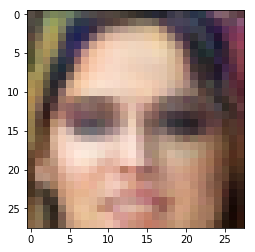

Epoch 18/25... Discriminator Loss: 1.2484... Generator Loss: 0.6677
Epoch 18/25... Discriminator Loss: 1.4162... Generator Loss: 0.6640
Epoch 18/25... Discriminator Loss: 1.4598... Generator Loss: 0.5985
Epoch 18/25... Discriminator Loss: 1.2629... Generator Loss: 0.8281


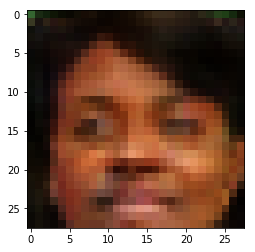

Epoch 18/25... Discriminator Loss: 1.2807... Generator Loss: 0.6766
Epoch 18/25... Discriminator Loss: 1.5628... Generator Loss: 0.5638
Epoch 18/25... Discriminator Loss: 1.4184... Generator Loss: 0.6392
Epoch 18/25... Discriminator Loss: 1.4594... Generator Loss: 0.6886


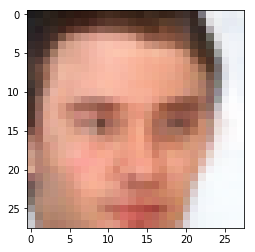

Epoch 18/25... Discriminator Loss: 1.4154... Generator Loss: 0.5606
Epoch 18/25... Discriminator Loss: 1.4522... Generator Loss: 0.6378
Epoch 18/25... Discriminator Loss: 1.3223... Generator Loss: 0.7585
Epoch 18/25... Discriminator Loss: 1.3809... Generator Loss: 0.6637


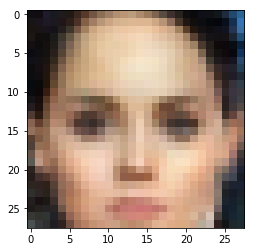

Epoch 18/25... Discriminator Loss: 1.3630... Generator Loss: 0.6791
Epoch 18/25... Discriminator Loss: 1.3143... Generator Loss: 0.7123
Epoch 18/25... Discriminator Loss: 1.3797... Generator Loss: 0.5922
Epoch 18/25... Discriminator Loss: 1.4617... Generator Loss: 0.6105


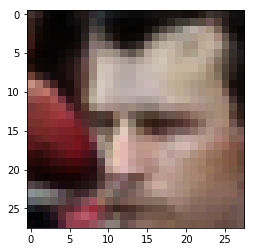

Epoch 18/25... Discriminator Loss: 1.5092... Generator Loss: 0.6196
Epoch 18/25... Discriminator Loss: 1.3205... Generator Loss: 0.6704
Epoch 18/25... Discriminator Loss: 1.2842... Generator Loss: 0.8094
Epoch 18/25... Discriminator Loss: 1.3916... Generator Loss: 0.6511


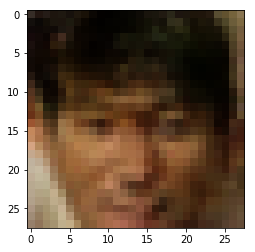

Epoch 18/25... Discriminator Loss: 1.3473... Generator Loss: 0.7350
Epoch 18/25... Discriminator Loss: 1.4951... Generator Loss: 0.5532
Epoch 18/25... Discriminator Loss: 1.3868... Generator Loss: 0.6107
Epoch 18/25... Discriminator Loss: 1.3654... Generator Loss: 0.6307


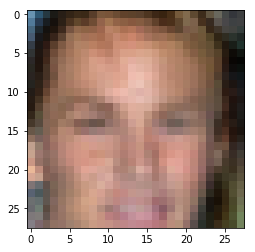

Epoch 18/25... Discriminator Loss: 1.6489... Generator Loss: 0.4528
Epoch 18/25... Discriminator Loss: 1.3356... Generator Loss: 0.6918
Epoch 18/25... Discriminator Loss: 1.3475... Generator Loss: 0.6441
Epoch 18/25... Discriminator Loss: 1.3385... Generator Loss: 0.6971


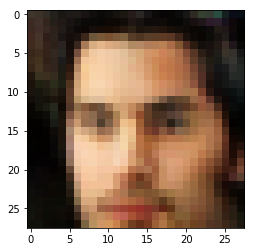

Epoch 18/25... Discriminator Loss: 1.3081... Generator Loss: 0.8275
Epoch 18/25... Discriminator Loss: 1.4139... Generator Loss: 0.6580
Epoch 18/25... Discriminator Loss: 1.4154... Generator Loss: 0.6376
Epoch 19/25... Discriminator Loss: 1.3797... Generator Loss: 0.6337


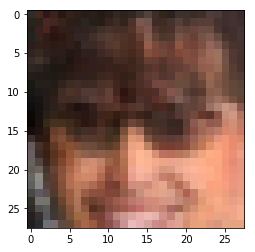

Epoch 19/25... Discriminator Loss: 1.3573... Generator Loss: 0.6053
Epoch 19/25... Discriminator Loss: 1.3322... Generator Loss: 0.6657
Epoch 19/25... Discriminator Loss: 1.3477... Generator Loss: 0.6086
Epoch 19/25... Discriminator Loss: 1.4596... Generator Loss: 0.5751


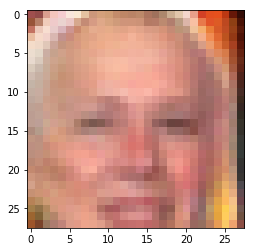

Epoch 19/25... Discriminator Loss: 1.2638... Generator Loss: 0.7211
Epoch 19/25... Discriminator Loss: 1.4280... Generator Loss: 0.6034
Epoch 19/25... Discriminator Loss: 1.3633... Generator Loss: 0.6720
Epoch 19/25... Discriminator Loss: 1.2594... Generator Loss: 0.7745


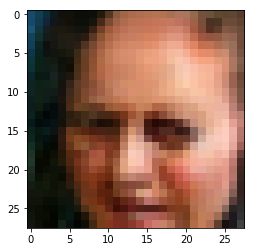

Epoch 19/25... Discriminator Loss: 1.2693... Generator Loss: 0.7113
Epoch 19/25... Discriminator Loss: 1.2522... Generator Loss: 0.7721
Epoch 19/25... Discriminator Loss: 1.2857... Generator Loss: 0.7546
Epoch 19/25... Discriminator Loss: 1.4241... Generator Loss: 0.5630


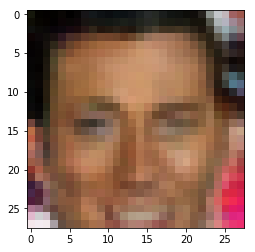

Epoch 19/25... Discriminator Loss: 1.4120... Generator Loss: 0.7414
Epoch 19/25... Discriminator Loss: 1.3537... Generator Loss: 0.6168
Epoch 19/25... Discriminator Loss: 1.3446... Generator Loss: 0.7537
Epoch 19/25... Discriminator Loss: 1.2834... Generator Loss: 0.6549


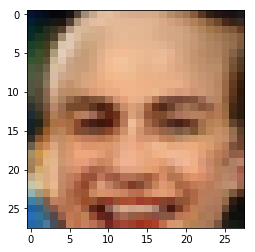

Epoch 19/25... Discriminator Loss: 1.3838... Generator Loss: 0.7026
Epoch 19/25... Discriminator Loss: 1.4269... Generator Loss: 0.5796
Epoch 19/25... Discriminator Loss: 1.4771... Generator Loss: 0.5599
Epoch 19/25... Discriminator Loss: 1.4235... Generator Loss: 0.6210


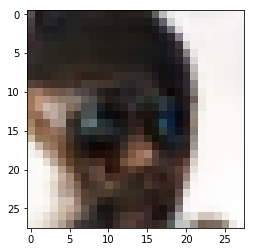

Epoch 19/25... Discriminator Loss: 1.5779... Generator Loss: 0.5274
Epoch 19/25... Discriminator Loss: 1.3582... Generator Loss: 0.6783
Epoch 19/25... Discriminator Loss: 1.2764... Generator Loss: 0.7475
Epoch 19/25... Discriminator Loss: 1.2577... Generator Loss: 0.8037


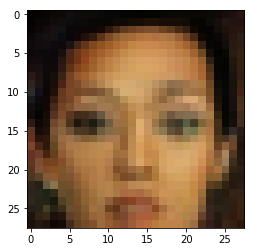

Epoch 19/25... Discriminator Loss: 1.5777... Generator Loss: 0.5442
Epoch 19/25... Discriminator Loss: 1.0972... Generator Loss: 1.1290
Epoch 19/25... Discriminator Loss: 1.3225... Generator Loss: 0.7161
Epoch 19/25... Discriminator Loss: 1.3481... Generator Loss: 0.6892


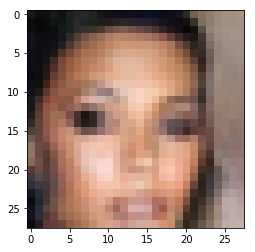

Epoch 19/25... Discriminator Loss: 1.4508... Generator Loss: 0.6037
Epoch 19/25... Discriminator Loss: 1.3247... Generator Loss: 0.6899
Epoch 19/25... Discriminator Loss: 1.4525... Generator Loss: 0.6037
Epoch 19/25... Discriminator Loss: 1.3469... Generator Loss: 0.6560


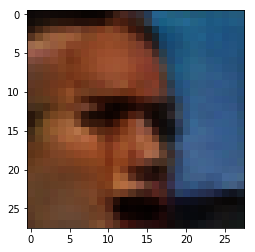

Epoch 19/25... Discriminator Loss: 1.3310... Generator Loss: 0.6889
Epoch 19/25... Discriminator Loss: 1.3340... Generator Loss: 0.7070
Epoch 19/25... Discriminator Loss: 1.1840... Generator Loss: 0.8665
Epoch 19/25... Discriminator Loss: 1.2318... Generator Loss: 0.7699


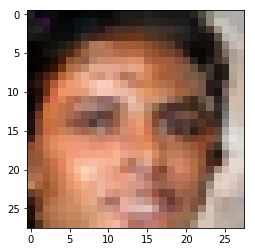

Epoch 19/25... Discriminator Loss: 1.2467... Generator Loss: 0.7809
Epoch 19/25... Discriminator Loss: 1.2971... Generator Loss: 0.7341
Epoch 19/25... Discriminator Loss: 1.5231... Generator Loss: 0.5260
Epoch 19/25... Discriminator Loss: 1.2293... Generator Loss: 0.8463


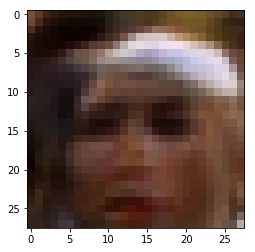

Epoch 19/25... Discriminator Loss: 1.4066... Generator Loss: 0.6111
Epoch 19/25... Discriminator Loss: 1.2122... Generator Loss: 0.7706
Epoch 19/25... Discriminator Loss: 1.4288... Generator Loss: 0.6352
Epoch 19/25... Discriminator Loss: 1.3306... Generator Loss: 0.6831


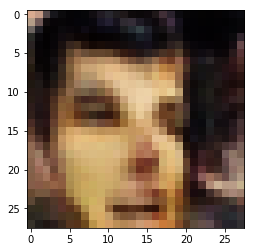

Epoch 19/25... Discriminator Loss: 1.3153... Generator Loss: 0.7647
Epoch 19/25... Discriminator Loss: 1.2530... Generator Loss: 0.7250
Epoch 19/25... Discriminator Loss: 1.3079... Generator Loss: 0.7462
Epoch 19/25... Discriminator Loss: 1.3405... Generator Loss: 0.6701


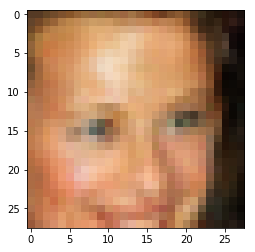

Epoch 19/25... Discriminator Loss: 1.3963... Generator Loss: 0.6964
Epoch 19/25... Discriminator Loss: 1.5700... Generator Loss: 0.6384
Epoch 19/25... Discriminator Loss: 1.4454... Generator Loss: 0.6239
Epoch 19/25... Discriminator Loss: 1.3000... Generator Loss: 0.6785


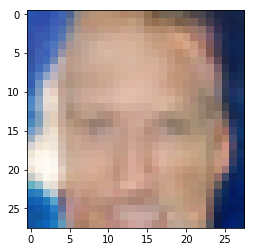

Epoch 19/25... Discriminator Loss: 1.3429... Generator Loss: 0.6952
Epoch 19/25... Discriminator Loss: 1.4820... Generator Loss: 0.5540
Epoch 19/25... Discriminator Loss: 1.1540... Generator Loss: 0.8018
Epoch 19/25... Discriminator Loss: 1.5311... Generator Loss: 0.5114


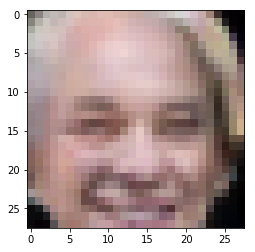

Epoch 19/25... Discriminator Loss: 1.2244... Generator Loss: 0.7912
Epoch 19/25... Discriminator Loss: 1.3301... Generator Loss: 0.6888
Epoch 19/25... Discriminator Loss: 1.2763... Generator Loss: 0.7354
Epoch 19/25... Discriminator Loss: 1.3956... Generator Loss: 0.5847


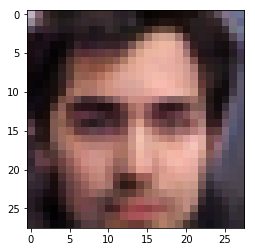

Epoch 19/25... Discriminator Loss: 1.3018... Generator Loss: 0.6627
Epoch 19/25... Discriminator Loss: 1.3478... Generator Loss: 0.6684
Epoch 20/25... Discriminator Loss: 1.4788... Generator Loss: 0.5275
Epoch 20/25... Discriminator Loss: 1.3057... Generator Loss: 0.7975


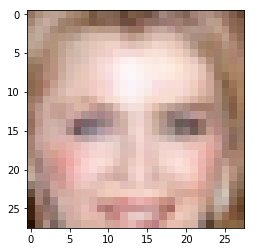

Epoch 20/25... Discriminator Loss: 1.2700... Generator Loss: 0.7527
Epoch 20/25... Discriminator Loss: 1.3966... Generator Loss: 0.6160
Epoch 20/25... Discriminator Loss: 1.1949... Generator Loss: 0.8049
Epoch 20/25... Discriminator Loss: 1.4091... Generator Loss: 0.5859


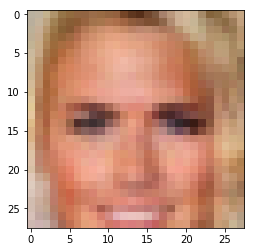

Epoch 20/25... Discriminator Loss: 1.4468... Generator Loss: 0.5604
Epoch 20/25... Discriminator Loss: 1.2378... Generator Loss: 0.9563
Epoch 20/25... Discriminator Loss: 1.3673... Generator Loss: 0.6667
Epoch 20/25... Discriminator Loss: 1.2208... Generator Loss: 0.8480


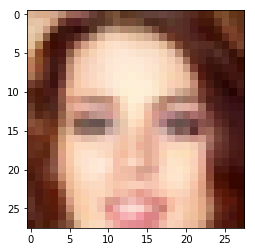

Epoch 20/25... Discriminator Loss: 1.3671... Generator Loss: 0.6420
Epoch 20/25... Discriminator Loss: 1.4399... Generator Loss: 0.6167
Epoch 20/25... Discriminator Loss: 1.3426... Generator Loss: 0.7124
Epoch 20/25... Discriminator Loss: 1.3528... Generator Loss: 0.7577


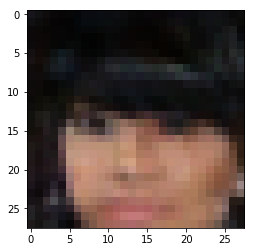

Epoch 20/25... Discriminator Loss: 1.4037... Generator Loss: 0.6048
Epoch 20/25... Discriminator Loss: 1.4885... Generator Loss: 0.7008
Epoch 20/25... Discriminator Loss: 1.5245... Generator Loss: 0.4709
Epoch 20/25... Discriminator Loss: 1.3632... Generator Loss: 0.7145


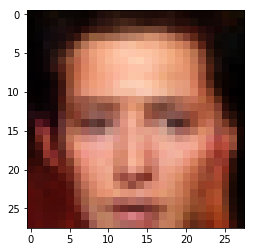

Epoch 20/25... Discriminator Loss: 1.3955... Generator Loss: 0.6324
Epoch 20/25... Discriminator Loss: 1.2860... Generator Loss: 0.6980
Epoch 20/25... Discriminator Loss: 1.3758... Generator Loss: 0.7259
Epoch 20/25... Discriminator Loss: 1.4765... Generator Loss: 0.5511


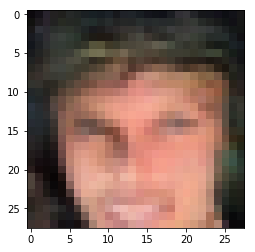

Epoch 20/25... Discriminator Loss: 1.2996... Generator Loss: 0.6891
Epoch 20/25... Discriminator Loss: 1.4755... Generator Loss: 0.5547
Epoch 20/25... Discriminator Loss: 1.2810... Generator Loss: 0.7583
Epoch 20/25... Discriminator Loss: 1.4880... Generator Loss: 0.6193


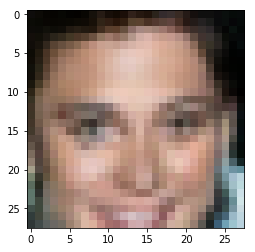

Epoch 20/25... Discriminator Loss: 1.4326... Generator Loss: 0.6387
Epoch 20/25... Discriminator Loss: 1.1972... Generator Loss: 0.9095
Epoch 20/25... Discriminator Loss: 1.4587... Generator Loss: 0.6221
Epoch 20/25... Discriminator Loss: 1.1740... Generator Loss: 0.8665


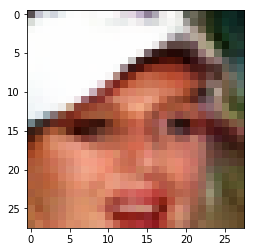

Epoch 20/25... Discriminator Loss: 1.3723... Generator Loss: 0.6198
Epoch 20/25... Discriminator Loss: 1.4283... Generator Loss: 0.6990
Epoch 20/25... Discriminator Loss: 1.2959... Generator Loss: 0.6748
Epoch 20/25... Discriminator Loss: 1.4205... Generator Loss: 0.6379


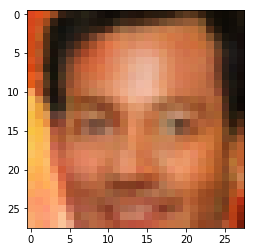

Epoch 20/25... Discriminator Loss: 1.4427... Generator Loss: 0.6196
Epoch 20/25... Discriminator Loss: 1.4042... Generator Loss: 0.5865
Epoch 20/25... Discriminator Loss: 1.3463... Generator Loss: 0.7093
Epoch 20/25... Discriminator Loss: 1.2953... Generator Loss: 0.7390


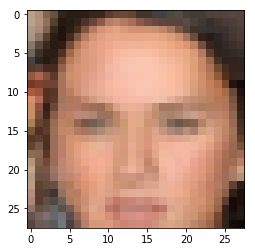

Epoch 20/25... Discriminator Loss: 1.6515... Generator Loss: 0.4679
Epoch 20/25... Discriminator Loss: 1.4465... Generator Loss: 0.5630
Epoch 20/25... Discriminator Loss: 1.2572... Generator Loss: 0.8449
Epoch 20/25... Discriminator Loss: 1.3968... Generator Loss: 0.7493


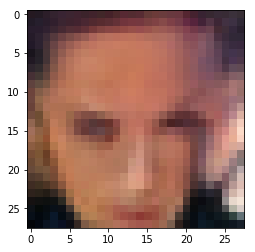

Epoch 20/25... Discriminator Loss: 1.2768... Generator Loss: 0.7625
Epoch 20/25... Discriminator Loss: 1.6611... Generator Loss: 0.4954
Epoch 20/25... Discriminator Loss: 1.3822... Generator Loss: 0.7625
Epoch 20/25... Discriminator Loss: 1.3114... Generator Loss: 0.7434


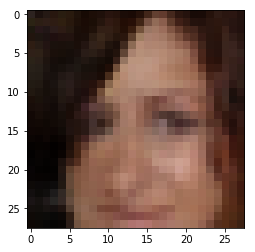

Epoch 20/25... Discriminator Loss: 1.2710... Generator Loss: 0.7114
Epoch 20/25... Discriminator Loss: 1.3800... Generator Loss: 0.6576
Epoch 20/25... Discriminator Loss: 1.3723... Generator Loss: 0.7247
Epoch 20/25... Discriminator Loss: 1.6770... Generator Loss: 0.4492


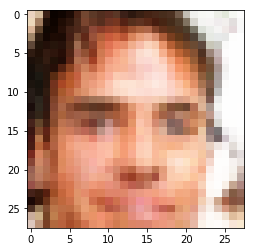

Epoch 20/25... Discriminator Loss: 1.3483... Generator Loss: 0.6798
Epoch 20/25... Discriminator Loss: 1.1846... Generator Loss: 0.8488
Epoch 20/25... Discriminator Loss: 1.3156... Generator Loss: 0.7384
Epoch 20/25... Discriminator Loss: 1.3392... Generator Loss: 0.6728


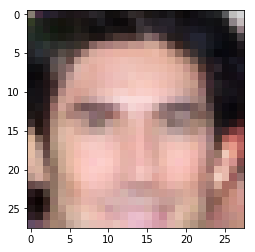

Epoch 20/25... Discriminator Loss: 1.3764... Generator Loss: 0.5861
Epoch 20/25... Discriminator Loss: 1.4065... Generator Loss: 0.5643
Epoch 20/25... Discriminator Loss: 1.2419... Generator Loss: 0.7119
Epoch 20/25... Discriminator Loss: 1.4411... Generator Loss: 0.5864


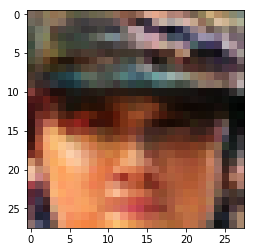

Epoch 20/25... Discriminator Loss: 1.5903... Generator Loss: 0.4817
Epoch 20/25... Discriminator Loss: 1.3135... Generator Loss: 0.8375
Epoch 20/25... Discriminator Loss: 1.3060... Generator Loss: 0.7432
Epoch 20/25... Discriminator Loss: 1.4060... Generator Loss: 0.5955


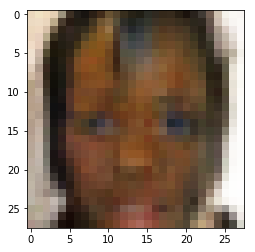

Epoch 20/25... Discriminator Loss: 1.2825... Generator Loss: 0.6734
Epoch 20/25... Discriminator Loss: 1.2454... Generator Loss: 0.9128
Epoch 21/25... Discriminator Loss: 1.2132... Generator Loss: 0.7521
Epoch 21/25... Discriminator Loss: 1.4360... Generator Loss: 0.7007


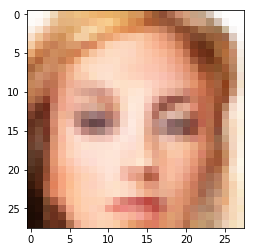

Epoch 21/25... Discriminator Loss: 1.2915... Generator Loss: 0.7381
Epoch 21/25... Discriminator Loss: 1.6175... Generator Loss: 0.4346
Epoch 21/25... Discriminator Loss: 1.3993... Generator Loss: 0.6470
Epoch 21/25... Discriminator Loss: 1.2575... Generator Loss: 0.7132


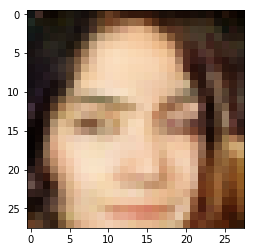

Epoch 21/25... Discriminator Loss: 1.3800... Generator Loss: 0.6022
Epoch 21/25... Discriminator Loss: 1.4277... Generator Loss: 0.6552
Epoch 21/25... Discriminator Loss: 1.2704... Generator Loss: 0.7389
Epoch 21/25... Discriminator Loss: 1.2016... Generator Loss: 0.8264


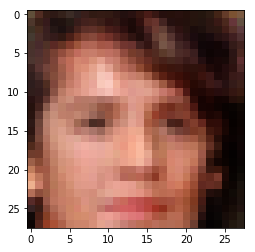

Epoch 21/25... Discriminator Loss: 1.3420... Generator Loss: 0.6988
Epoch 21/25... Discriminator Loss: 1.3364... Generator Loss: 0.6232
Epoch 21/25... Discriminator Loss: 1.2349... Generator Loss: 0.7998
Epoch 21/25... Discriminator Loss: 1.3257... Generator Loss: 0.6244


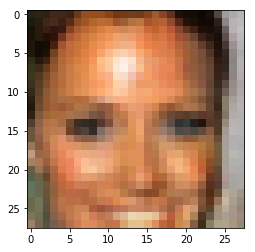

Epoch 21/25... Discriminator Loss: 1.4178... Generator Loss: 0.6266
Epoch 21/25... Discriminator Loss: 1.4202... Generator Loss: 0.6121
Epoch 21/25... Discriminator Loss: 1.3249... Generator Loss: 0.6255
Epoch 21/25... Discriminator Loss: 1.4240... Generator Loss: 0.6181


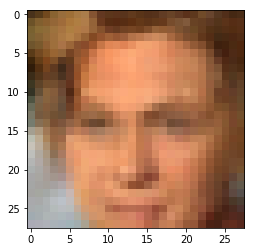

Epoch 21/25... Discriminator Loss: 1.2564... Generator Loss: 0.7669
Epoch 21/25... Discriminator Loss: 1.3554... Generator Loss: 0.6439
Epoch 21/25... Discriminator Loss: 1.2071... Generator Loss: 0.7677
Epoch 21/25... Discriminator Loss: 1.3716... Generator Loss: 0.5765


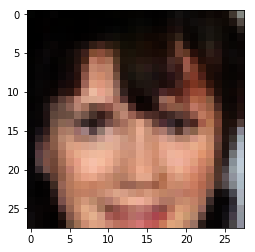

Epoch 21/25... Discriminator Loss: 1.1354... Generator Loss: 1.0357
Epoch 21/25... Discriminator Loss: 1.5491... Generator Loss: 0.5660
Epoch 21/25... Discriminator Loss: 1.1286... Generator Loss: 0.7361
Epoch 21/25... Discriminator Loss: 1.3501... Generator Loss: 0.6992


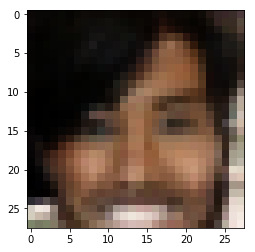

Epoch 21/25... Discriminator Loss: 1.1738... Generator Loss: 0.8468
Epoch 21/25... Discriminator Loss: 1.2817... Generator Loss: 0.7679
Epoch 21/25... Discriminator Loss: 1.3263... Generator Loss: 0.7532
Epoch 21/25... Discriminator Loss: 1.3308... Generator Loss: 0.7521


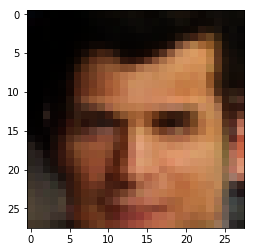

Epoch 21/25... Discriminator Loss: 1.5411... Generator Loss: 0.5437
Epoch 21/25... Discriminator Loss: 1.1198... Generator Loss: 0.8161
Epoch 21/25... Discriminator Loss: 1.4111... Generator Loss: 0.6156
Epoch 21/25... Discriminator Loss: 1.4825... Generator Loss: 0.6189


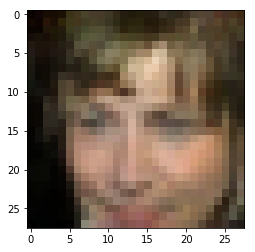

Epoch 21/25... Discriminator Loss: 1.6093... Generator Loss: 0.4731
Epoch 21/25... Discriminator Loss: 1.2336... Generator Loss: 0.8567
Epoch 21/25... Discriminator Loss: 1.2397... Generator Loss: 0.7654
Epoch 21/25... Discriminator Loss: 1.4503... Generator Loss: 0.5854


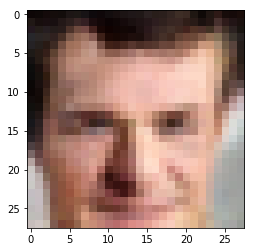

Epoch 21/25... Discriminator Loss: 1.1917... Generator Loss: 0.8358
Epoch 21/25... Discriminator Loss: 1.3872... Generator Loss: 0.6823
Epoch 21/25... Discriminator Loss: 1.4239... Generator Loss: 0.6287
Epoch 21/25... Discriminator Loss: 1.3938... Generator Loss: 0.5717


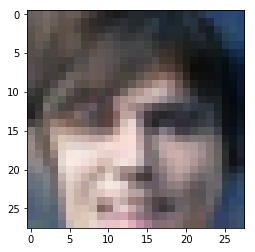

Epoch 21/25... Discriminator Loss: 1.3191... Generator Loss: 0.7200
Epoch 21/25... Discriminator Loss: 1.4036... Generator Loss: 0.5792
Epoch 21/25... Discriminator Loss: 1.4195... Generator Loss: 0.5882
Epoch 21/25... Discriminator Loss: 1.3601... Generator Loss: 0.6636


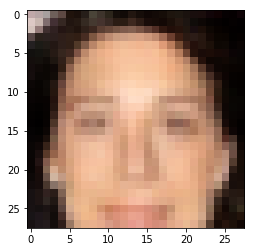

Epoch 21/25... Discriminator Loss: 1.5723... Generator Loss: 0.5690
Epoch 21/25... Discriminator Loss: 1.4550... Generator Loss: 0.7838
Epoch 21/25... Discriminator Loss: 1.2734... Generator Loss: 0.7023
Epoch 21/25... Discriminator Loss: 1.3823... Generator Loss: 0.5702


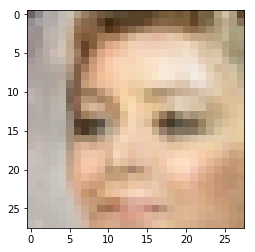

Epoch 21/25... Discriminator Loss: 1.2263... Generator Loss: 0.8028
Epoch 21/25... Discriminator Loss: 1.2657... Generator Loss: 0.8708
Epoch 21/25... Discriminator Loss: 1.4023... Generator Loss: 0.7191
Epoch 21/25... Discriminator Loss: 1.4571... Generator Loss: 0.5822


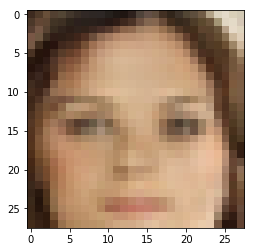

Epoch 21/25... Discriminator Loss: 1.2783... Generator Loss: 0.7997
Epoch 21/25... Discriminator Loss: 1.4387... Generator Loss: 0.7047
Epoch 21/25... Discriminator Loss: 1.5018... Generator Loss: 0.5451
Epoch 21/25... Discriminator Loss: 1.3754... Generator Loss: 0.6477


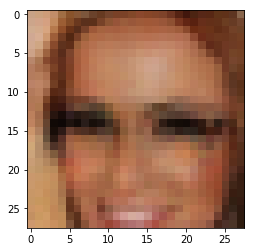

Epoch 21/25... Discriminator Loss: 1.1755... Generator Loss: 0.8326
Epoch 21/25... Discriminator Loss: 1.3463... Generator Loss: 0.5741
Epoch 21/25... Discriminator Loss: 1.3174... Generator Loss: 0.6779
Epoch 21/25... Discriminator Loss: 1.3204... Generator Loss: 0.7713


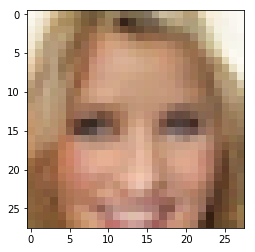

Epoch 21/25... Discriminator Loss: 1.2515... Generator Loss: 0.7554
Epoch 22/25... Discriminator Loss: 1.4618... Generator Loss: 0.6632
Epoch 22/25... Discriminator Loss: 1.4851... Generator Loss: 0.5434
Epoch 22/25... Discriminator Loss: 1.5098... Generator Loss: 0.5489


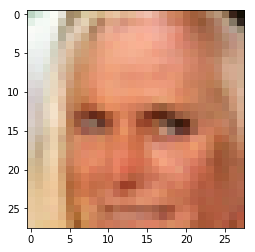

Epoch 22/25... Discriminator Loss: 1.3723... Generator Loss: 0.6710
Epoch 22/25... Discriminator Loss: 1.2941... Generator Loss: 0.7901
Epoch 22/25... Discriminator Loss: 1.2727... Generator Loss: 0.7195
Epoch 22/25... Discriminator Loss: 1.3015... Generator Loss: 0.7601


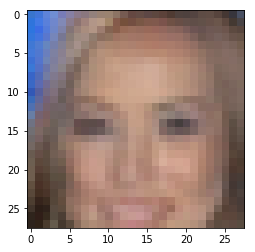

Epoch 22/25... Discriminator Loss: 1.3931... Generator Loss: 0.6479
Epoch 22/25... Discriminator Loss: 1.1668... Generator Loss: 0.8520
Epoch 22/25... Discriminator Loss: 1.3053... Generator Loss: 0.7409
Epoch 22/25... Discriminator Loss: 0.9750... Generator Loss: 0.9850


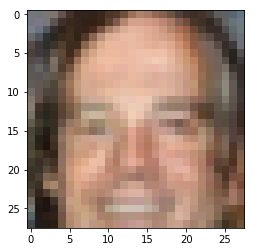

Epoch 22/25... Discriminator Loss: 1.3697... Generator Loss: 0.6653
Epoch 22/25... Discriminator Loss: 1.1791... Generator Loss: 0.8091
Epoch 22/25... Discriminator Loss: 1.3471... Generator Loss: 0.7583
Epoch 22/25... Discriminator Loss: 1.3593... Generator Loss: 0.6535


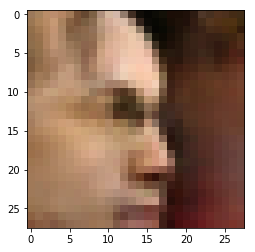

Epoch 22/25... Discriminator Loss: 1.2460... Generator Loss: 0.8143
Epoch 22/25... Discriminator Loss: 1.0630... Generator Loss: 0.9990
Epoch 22/25... Discriminator Loss: 1.2562... Generator Loss: 0.7151
Epoch 22/25... Discriminator Loss: 1.3601... Generator Loss: 0.6068


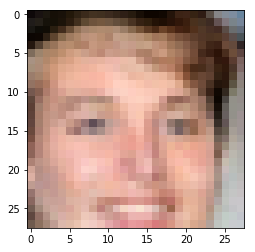

Epoch 22/25... Discriminator Loss: 1.1931... Generator Loss: 0.7254
Epoch 22/25... Discriminator Loss: 1.4637... Generator Loss: 0.6129
Epoch 22/25... Discriminator Loss: 1.3538... Generator Loss: 0.6795
Epoch 22/25... Discriminator Loss: 1.3672... Generator Loss: 0.6468


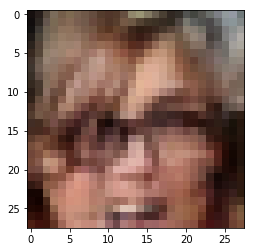

Epoch 22/25... Discriminator Loss: 1.5040... Generator Loss: 0.5574
Epoch 22/25... Discriminator Loss: 1.3970... Generator Loss: 0.6755
Epoch 22/25... Discriminator Loss: 1.5181... Generator Loss: 0.5634
Epoch 22/25... Discriminator Loss: 1.4587... Generator Loss: 0.6118


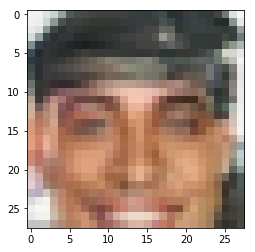

Epoch 22/25... Discriminator Loss: 1.2994... Generator Loss: 0.6681
Epoch 22/25... Discriminator Loss: 1.3455... Generator Loss: 0.6380
Epoch 22/25... Discriminator Loss: 1.7929... Generator Loss: 0.4172
Epoch 22/25... Discriminator Loss: 1.4159... Generator Loss: 0.6723


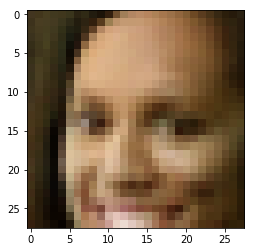

Epoch 22/25... Discriminator Loss: 1.2959... Generator Loss: 0.6726
Epoch 22/25... Discriminator Loss: 1.4342... Generator Loss: 0.5353
Epoch 22/25... Discriminator Loss: 1.4771... Generator Loss: 0.5660
Epoch 22/25... Discriminator Loss: 1.3775... Generator Loss: 0.5936


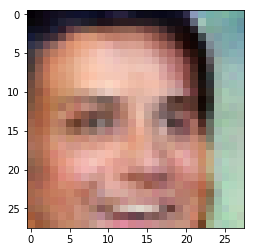

Epoch 22/25... Discriminator Loss: 1.2775... Generator Loss: 0.7220
Epoch 22/25... Discriminator Loss: 1.2947... Generator Loss: 0.7745
Epoch 22/25... Discriminator Loss: 1.3255... Generator Loss: 0.6864
Epoch 22/25... Discriminator Loss: 1.2356... Generator Loss: 0.8414


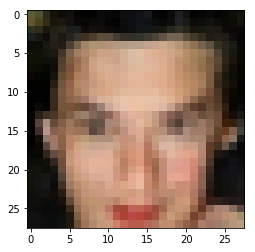

Epoch 22/25... Discriminator Loss: 1.4730... Generator Loss: 0.5951
Epoch 22/25... Discriminator Loss: 1.3299... Generator Loss: 0.7147
Epoch 22/25... Discriminator Loss: 1.4128... Generator Loss: 0.5983
Epoch 22/25... Discriminator Loss: 1.2552... Generator Loss: 0.6585


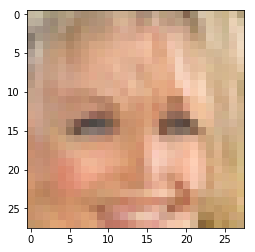

Epoch 22/25... Discriminator Loss: 1.2580... Generator Loss: 0.7124
Epoch 22/25... Discriminator Loss: 1.2959... Generator Loss: 0.6669
Epoch 22/25... Discriminator Loss: 1.3186... Generator Loss: 0.7086
Epoch 22/25... Discriminator Loss: 1.3535... Generator Loss: 0.7315


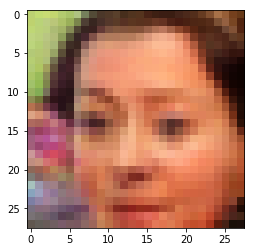

Epoch 22/25... Discriminator Loss: 1.2832... Generator Loss: 0.7141
Epoch 22/25... Discriminator Loss: 1.4242... Generator Loss: 0.6157
Epoch 22/25... Discriminator Loss: 1.3452... Generator Loss: 0.7406
Epoch 22/25... Discriminator Loss: 1.3101... Generator Loss: 0.7135


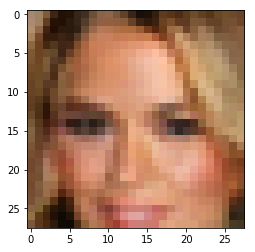

Epoch 22/25... Discriminator Loss: 1.3091... Generator Loss: 0.7606
Epoch 22/25... Discriminator Loss: 1.3888... Generator Loss: 0.6368
Epoch 22/25... Discriminator Loss: 1.3045... Generator Loss: 0.6510
Epoch 22/25... Discriminator Loss: 1.6000... Generator Loss: 0.4432


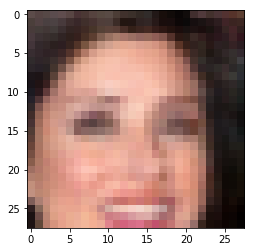

Epoch 22/25... Discriminator Loss: 1.4016... Generator Loss: 0.5890
Epoch 22/25... Discriminator Loss: 1.5275... Generator Loss: 0.5084
Epoch 22/25... Discriminator Loss: 1.3406... Generator Loss: 0.6315
Epoch 22/25... Discriminator Loss: 1.5314... Generator Loss: 0.5833


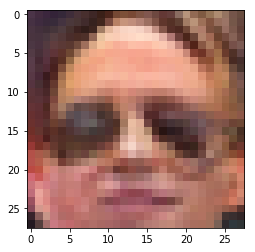

Epoch 22/25... Discriminator Loss: 1.2049... Generator Loss: 0.8401
Epoch 22/25... Discriminator Loss: 1.4364... Generator Loss: 0.5920
Epoch 22/25... Discriminator Loss: 1.2897... Generator Loss: 0.8948
Epoch 22/25... Discriminator Loss: 1.4075... Generator Loss: 0.6589


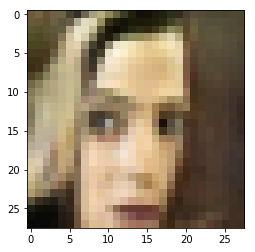

Epoch 23/25... Discriminator Loss: 1.3409... Generator Loss: 0.7413
Epoch 23/25... Discriminator Loss: 1.1558... Generator Loss: 0.8818
Epoch 23/25... Discriminator Loss: 1.2265... Generator Loss: 0.8101
Epoch 23/25... Discriminator Loss: 1.4006... Generator Loss: 0.6649


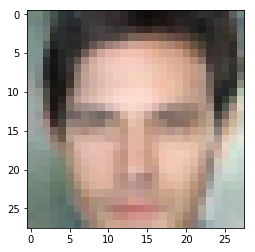

Epoch 23/25... Discriminator Loss: 1.3922... Generator Loss: 0.6947
Epoch 23/25... Discriminator Loss: 1.2399... Generator Loss: 0.7921
Epoch 23/25... Discriminator Loss: 1.3183... Generator Loss: 0.7152
Epoch 23/25... Discriminator Loss: 1.3257... Generator Loss: 0.6756


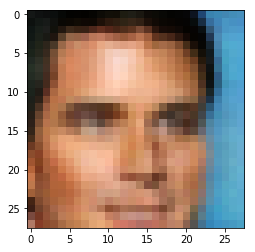

Epoch 23/25... Discriminator Loss: 1.2843... Generator Loss: 0.6890
Epoch 23/25... Discriminator Loss: 1.3157... Generator Loss: 0.7469
Epoch 23/25... Discriminator Loss: 1.2112... Generator Loss: 0.6981
Epoch 23/25... Discriminator Loss: 1.4222... Generator Loss: 0.6127


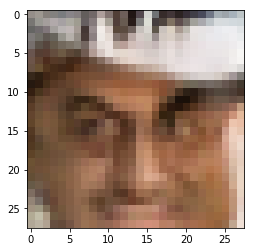

Epoch 23/25... Discriminator Loss: 1.3302... Generator Loss: 0.7469
Epoch 23/25... Discriminator Loss: 1.2627... Generator Loss: 0.7487
Epoch 23/25... Discriminator Loss: 1.6400... Generator Loss: 0.4896
Epoch 23/25... Discriminator Loss: 1.3397... Generator Loss: 0.6725


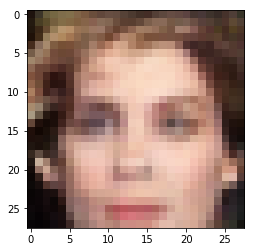

Epoch 23/25... Discriminator Loss: 1.4969... Generator Loss: 0.6087
Epoch 23/25... Discriminator Loss: 1.3285... Generator Loss: 0.7068
Epoch 23/25... Discriminator Loss: 1.3228... Generator Loss: 0.6168
Epoch 23/25... Discriminator Loss: 1.2069... Generator Loss: 0.7842


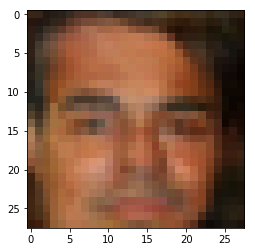

Epoch 23/25... Discriminator Loss: 0.9593... Generator Loss: 1.0392
Epoch 23/25... Discriminator Loss: 1.5150... Generator Loss: 0.5223
Epoch 23/25... Discriminator Loss: 1.3371... Generator Loss: 0.7035
Epoch 23/25... Discriminator Loss: 1.2293... Generator Loss: 0.7366


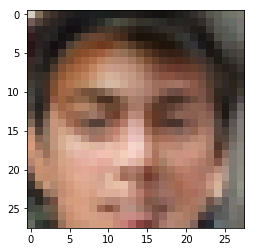

Epoch 23/25... Discriminator Loss: 1.2723... Generator Loss: 0.8192
Epoch 23/25... Discriminator Loss: 1.1776... Generator Loss: 0.7567
Epoch 23/25... Discriminator Loss: 1.3157... Generator Loss: 0.5920
Epoch 23/25... Discriminator Loss: 1.1852... Generator Loss: 0.8042


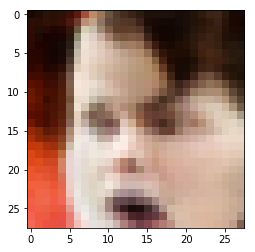

Epoch 23/25... Discriminator Loss: 1.4777... Generator Loss: 0.5920
Epoch 23/25... Discriminator Loss: 1.3534... Generator Loss: 0.6536
Epoch 23/25... Discriminator Loss: 1.2602... Generator Loss: 0.7305
Epoch 23/25... Discriminator Loss: 1.2130... Generator Loss: 0.7107


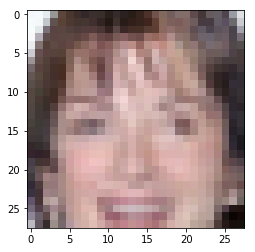

Epoch 23/25... Discriminator Loss: 1.5862... Generator Loss: 0.5164
Epoch 23/25... Discriminator Loss: 1.3594... Generator Loss: 0.6953
Epoch 23/25... Discriminator Loss: 1.3529... Generator Loss: 0.6141
Epoch 23/25... Discriminator Loss: 1.2731... Generator Loss: 0.8322


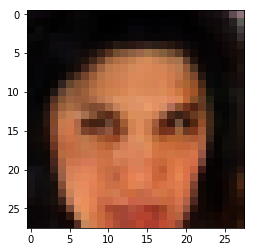

Epoch 23/25... Discriminator Loss: 1.2985... Generator Loss: 0.7646
Epoch 23/25... Discriminator Loss: 1.3537... Generator Loss: 0.6669
Epoch 23/25... Discriminator Loss: 1.3561... Generator Loss: 0.6598
Epoch 23/25... Discriminator Loss: 1.3448... Generator Loss: 0.7631


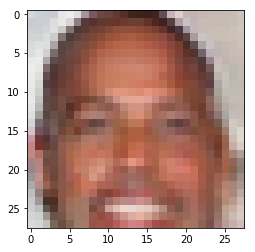

Epoch 23/25... Discriminator Loss: 1.4142... Generator Loss: 0.5974
Epoch 23/25... Discriminator Loss: 1.3040... Generator Loss: 0.6451
Epoch 23/25... Discriminator Loss: 1.3775... Generator Loss: 0.6406
Epoch 23/25... Discriminator Loss: 1.3250... Generator Loss: 0.6252


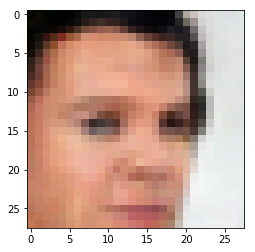

Epoch 23/25... Discriminator Loss: 1.1989... Generator Loss: 0.8996
Epoch 23/25... Discriminator Loss: 1.5016... Generator Loss: 0.4921
Epoch 23/25... Discriminator Loss: 1.3125... Generator Loss: 0.7293
Epoch 23/25... Discriminator Loss: 1.5076... Generator Loss: 0.5973


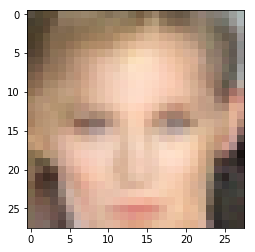

Epoch 23/25... Discriminator Loss: 1.2505... Generator Loss: 0.7937
Epoch 23/25... Discriminator Loss: 1.4200... Generator Loss: 0.5559
Epoch 23/25... Discriminator Loss: 1.3745... Generator Loss: 0.6392
Epoch 23/25... Discriminator Loss: 1.5090... Generator Loss: 0.5772


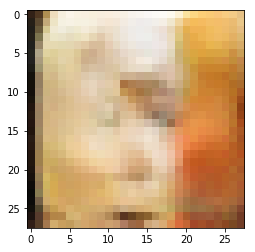

Epoch 23/25... Discriminator Loss: 1.4554... Generator Loss: 0.5908
Epoch 23/25... Discriminator Loss: 1.3842... Generator Loss: 0.6849
Epoch 23/25... Discriminator Loss: 1.3015... Generator Loss: 0.7458
Epoch 23/25... Discriminator Loss: 1.3360... Generator Loss: 0.6116


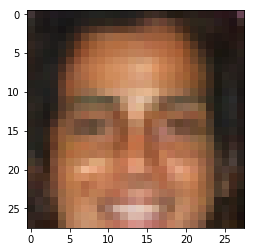

Epoch 23/25... Discriminator Loss: 1.2196... Generator Loss: 0.8289
Epoch 23/25... Discriminator Loss: 1.2688... Generator Loss: 0.8001
Epoch 23/25... Discriminator Loss: 1.3947... Generator Loss: 0.7160
Epoch 23/25... Discriminator Loss: 1.3638... Generator Loss: 0.6453


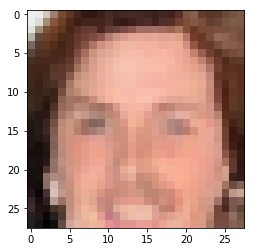

Epoch 23/25... Discriminator Loss: 1.5036... Generator Loss: 0.4942
Epoch 23/25... Discriminator Loss: 1.3846... Generator Loss: 0.6376
Epoch 23/25... Discriminator Loss: 1.7384... Generator Loss: 0.5804
Epoch 24/25... Discriminator Loss: 1.2302... Generator Loss: 0.7814


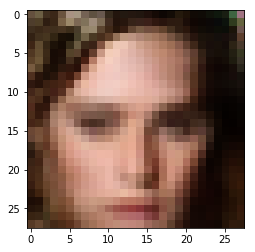

Epoch 24/25... Discriminator Loss: 1.4592... Generator Loss: 0.5742
Epoch 24/25... Discriminator Loss: 1.2039... Generator Loss: 0.8883
Epoch 24/25... Discriminator Loss: 1.2073... Generator Loss: 0.7332
Epoch 24/25... Discriminator Loss: 1.5228... Generator Loss: 0.5661


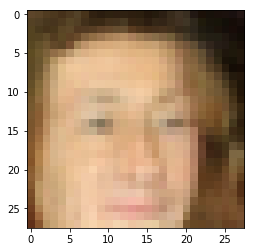

Epoch 24/25... Discriminator Loss: 1.3802... Generator Loss: 0.6379
Epoch 24/25... Discriminator Loss: 1.4166... Generator Loss: 0.6061
Epoch 24/25... Discriminator Loss: 1.2469... Generator Loss: 0.7369
Epoch 24/25... Discriminator Loss: 1.7284... Generator Loss: 0.3952


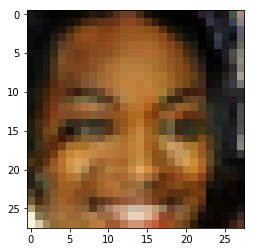

Epoch 24/25... Discriminator Loss: 1.3282... Generator Loss: 0.7363
Epoch 24/25... Discriminator Loss: 1.1329... Generator Loss: 0.9709
Epoch 24/25... Discriminator Loss: 1.5063... Generator Loss: 0.5343
Epoch 24/25... Discriminator Loss: 1.3914... Generator Loss: 0.6881


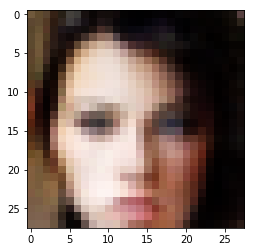

Epoch 24/25... Discriminator Loss: 1.3910... Generator Loss: 0.6237
Epoch 24/25... Discriminator Loss: 1.0944... Generator Loss: 0.8446
Epoch 24/25... Discriminator Loss: 1.1714... Generator Loss: 0.7481
Epoch 24/25... Discriminator Loss: 1.1092... Generator Loss: 0.9293


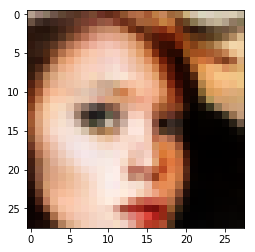

Epoch 24/25... Discriminator Loss: 1.3123... Generator Loss: 0.7094
Epoch 24/25... Discriminator Loss: 1.4414... Generator Loss: 0.6613
Epoch 24/25... Discriminator Loss: 1.5305... Generator Loss: 0.5917
Epoch 24/25... Discriminator Loss: 1.3639... Generator Loss: 0.6874


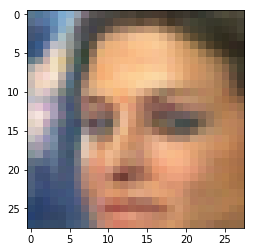

Epoch 24/25... Discriminator Loss: 1.2639... Generator Loss: 0.7378
Epoch 24/25... Discriminator Loss: 1.4454... Generator Loss: 0.5540
Epoch 24/25... Discriminator Loss: 1.2281... Generator Loss: 0.7307
Epoch 24/25... Discriminator Loss: 1.4372... Generator Loss: 0.6373


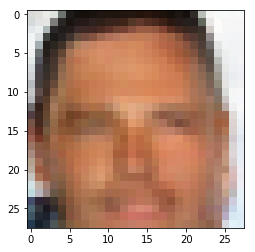

Epoch 24/25... Discriminator Loss: 1.4216... Generator Loss: 0.5796
Epoch 24/25... Discriminator Loss: 1.3666... Generator Loss: 0.7430
Epoch 24/25... Discriminator Loss: 1.3663... Generator Loss: 0.6004
Epoch 24/25... Discriminator Loss: 1.3348... Generator Loss: 0.6672


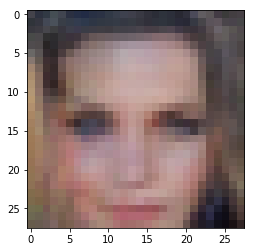

Epoch 24/25... Discriminator Loss: 1.3916... Generator Loss: 0.6098
Epoch 24/25... Discriminator Loss: 1.3732... Generator Loss: 0.6086
Epoch 24/25... Discriminator Loss: 1.3244... Generator Loss: 0.6480
Epoch 24/25... Discriminator Loss: 1.3945... Generator Loss: 0.5995


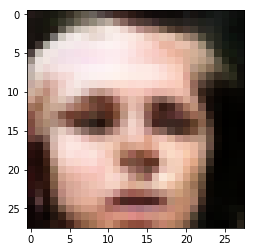

Epoch 24/25... Discriminator Loss: 1.2988... Generator Loss: 0.7011
Epoch 24/25... Discriminator Loss: 1.2633... Generator Loss: 0.7536
Epoch 24/25... Discriminator Loss: 1.2296... Generator Loss: 0.9411
Epoch 24/25... Discriminator Loss: 1.2224... Generator Loss: 0.8232


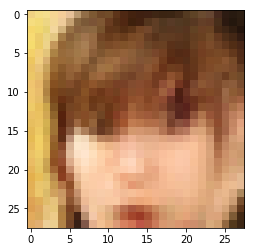

Epoch 24/25... Discriminator Loss: 1.5275... Generator Loss: 0.5220
Epoch 24/25... Discriminator Loss: 1.2305... Generator Loss: 0.8335
Epoch 24/25... Discriminator Loss: 1.3655... Generator Loss: 0.5977
Epoch 24/25... Discriminator Loss: 1.1275... Generator Loss: 0.9148


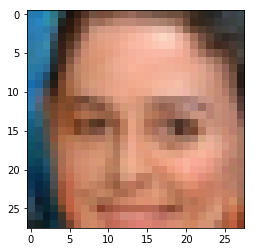

Epoch 24/25... Discriminator Loss: 1.2702... Generator Loss: 0.7994
Epoch 24/25... Discriminator Loss: 1.5067... Generator Loss: 0.5377
Epoch 24/25... Discriminator Loss: 1.4538... Generator Loss: 0.5670
Epoch 24/25... Discriminator Loss: 1.3183... Generator Loss: 0.6245


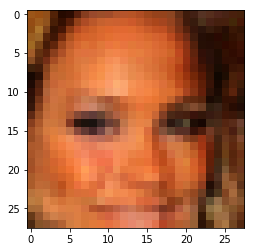

Epoch 24/25... Discriminator Loss: 1.5780... Generator Loss: 0.5014
Epoch 24/25... Discriminator Loss: 1.2024... Generator Loss: 0.8770
Epoch 24/25... Discriminator Loss: 1.3968... Generator Loss: 0.6858
Epoch 24/25... Discriminator Loss: 1.4767... Generator Loss: 0.5781


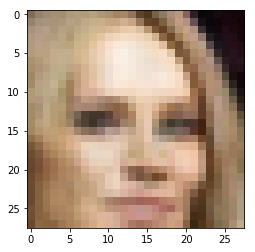

Epoch 24/25... Discriminator Loss: 1.5247... Generator Loss: 0.4721
Epoch 24/25... Discriminator Loss: 1.5524... Generator Loss: 0.5634
Epoch 24/25... Discriminator Loss: 1.0383... Generator Loss: 0.9140
Epoch 24/25... Discriminator Loss: 1.4505... Generator Loss: 0.5521


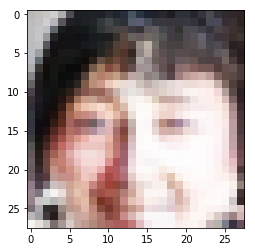

Epoch 24/25... Discriminator Loss: 1.5408... Generator Loss: 0.5492
Epoch 24/25... Discriminator Loss: 1.3332... Generator Loss: 0.6446
Epoch 24/25... Discriminator Loss: 1.4161... Generator Loss: 0.6279
Epoch 24/25... Discriminator Loss: 1.2654... Generator Loss: 0.7410


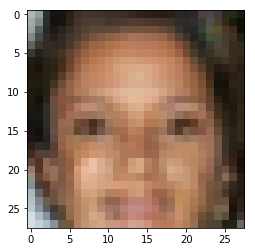

Epoch 24/25... Discriminator Loss: 1.1514... Generator Loss: 0.8133
Epoch 24/25... Discriminator Loss: 1.5392... Generator Loss: 0.4957
Epoch 24/25... Discriminator Loss: 1.3850... Generator Loss: 0.6062
Epoch 24/25... Discriminator Loss: 1.3328... Generator Loss: 0.5635


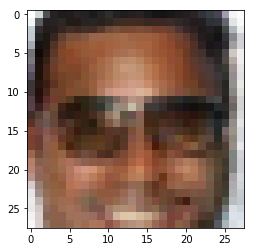

Epoch 24/25... Discriminator Loss: 1.3540... Generator Loss: 0.6301
Epoch 24/25... Discriminator Loss: 1.2779... Generator Loss: 0.7246
Epoch 24/25... Discriminator Loss: 1.4738... Generator Loss: 0.5744
Epoch 25/25... Discriminator Loss: 1.2047... Generator Loss: 0.7685


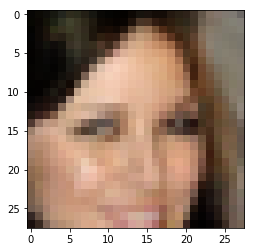

Epoch 25/25... Discriminator Loss: 1.3074... Generator Loss: 0.6659
Epoch 25/25... Discriminator Loss: 1.5189... Generator Loss: 0.5006
Epoch 25/25... Discriminator Loss: 1.2747... Generator Loss: 0.6332
Epoch 25/25... Discriminator Loss: 1.3629... Generator Loss: 0.6670


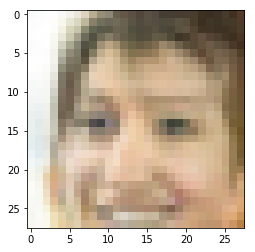

Epoch 25/25... Discriminator Loss: 1.3105... Generator Loss: 0.7549
Epoch 25/25... Discriminator Loss: 1.2298... Generator Loss: 0.7681
Epoch 25/25... Discriminator Loss: 1.1969... Generator Loss: 0.8222
Epoch 25/25... Discriminator Loss: 1.2808... Generator Loss: 0.6537


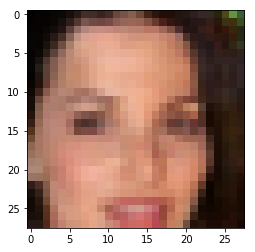

Epoch 25/25... Discriminator Loss: 1.5405... Generator Loss: 0.4967
Epoch 25/25... Discriminator Loss: 1.1475... Generator Loss: 0.8266
Epoch 25/25... Discriminator Loss: 1.0968... Generator Loss: 0.8707
Epoch 25/25... Discriminator Loss: 1.2767... Generator Loss: 0.6874


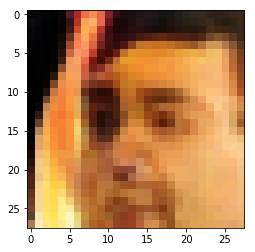

Epoch 25/25... Discriminator Loss: 1.4529... Generator Loss: 0.6293
Epoch 25/25... Discriminator Loss: 1.3149... Generator Loss: 0.6429
Epoch 25/25... Discriminator Loss: 1.2686... Generator Loss: 0.6467
Epoch 25/25... Discriminator Loss: 1.2899... Generator Loss: 0.7548


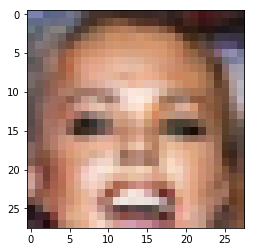

Epoch 25/25... Discriminator Loss: 1.5814... Generator Loss: 0.4875
Epoch 25/25... Discriminator Loss: 1.6421... Generator Loss: 0.4754
Epoch 25/25... Discriminator Loss: 1.3483... Generator Loss: 0.7647
Epoch 25/25... Discriminator Loss: 1.4153... Generator Loss: 0.6543


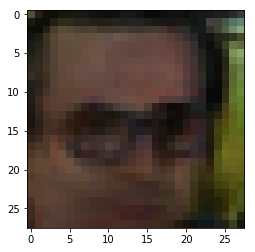

Epoch 25/25... Discriminator Loss: 1.2798... Generator Loss: 0.6759
Epoch 25/25... Discriminator Loss: 1.4165... Generator Loss: 0.5977
Epoch 25/25... Discriminator Loss: 1.4062... Generator Loss: 0.6565
Epoch 25/25... Discriminator Loss: 1.5030... Generator Loss: 0.5374


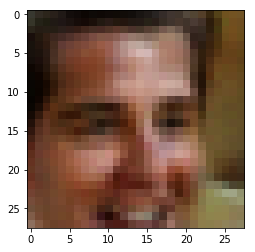

Epoch 25/25... Discriminator Loss: 1.5505... Generator Loss: 0.4692
Epoch 25/25... Discriminator Loss: 1.2081... Generator Loss: 0.8018
Epoch 25/25... Discriminator Loss: 1.4258... Generator Loss: 0.6778
Epoch 25/25... Discriminator Loss: 1.3547... Generator Loss: 0.7020


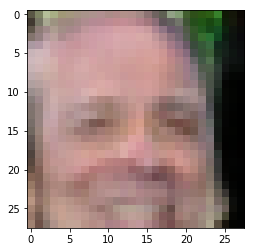

Epoch 25/25... Discriminator Loss: 1.3763... Generator Loss: 0.6913
Epoch 25/25... Discriminator Loss: 1.3395... Generator Loss: 0.6569
Epoch 25/25... Discriminator Loss: 1.3039... Generator Loss: 0.7200
Epoch 25/25... Discriminator Loss: 1.3315... Generator Loss: 0.7426


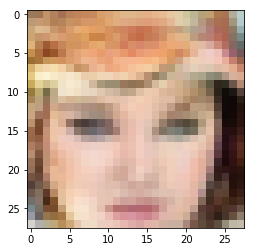

Epoch 25/25... Discriminator Loss: 1.2337... Generator Loss: 0.8651
Epoch 25/25... Discriminator Loss: 1.3017... Generator Loss: 0.6982
Epoch 25/25... Discriminator Loss: 1.3182... Generator Loss: 0.6806
Epoch 25/25... Discriminator Loss: 1.1885... Generator Loss: 0.7842


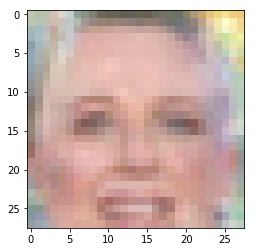

Epoch 25/25... Discriminator Loss: 1.4144... Generator Loss: 0.5831
Epoch 25/25... Discriminator Loss: 1.3627... Generator Loss: 0.6335
Epoch 25/25... Discriminator Loss: 1.2116... Generator Loss: 0.7759
Epoch 25/25... Discriminator Loss: 1.3172... Generator Loss: 0.7323


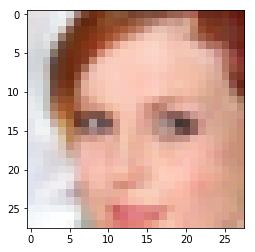

Epoch 25/25... Discriminator Loss: 1.2795... Generator Loss: 0.7275
Epoch 25/25... Discriminator Loss: 1.2690... Generator Loss: 0.7182
Epoch 25/25... Discriminator Loss: 1.3581... Generator Loss: 0.6698
Epoch 25/25... Discriminator Loss: 1.5667... Generator Loss: 0.5333


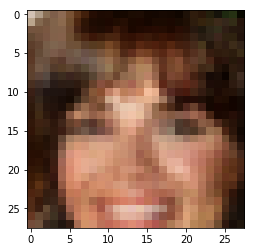

Epoch 25/25... Discriminator Loss: 1.3543... Generator Loss: 0.5775
Epoch 25/25... Discriminator Loss: 1.2171... Generator Loss: 0.7637
Epoch 25/25... Discriminator Loss: 1.3474... Generator Loss: 0.7587
Epoch 25/25... Discriminator Loss: 1.4283... Generator Loss: 0.6149


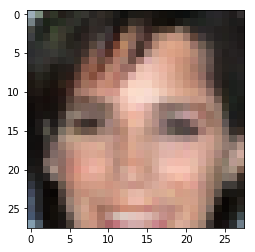

Epoch 25/25... Discriminator Loss: 1.3770... Generator Loss: 0.6369
Epoch 25/25... Discriminator Loss: 1.3662... Generator Loss: 0.7291
Epoch 25/25... Discriminator Loss: 1.2619... Generator Loss: 0.7108
Epoch 25/25... Discriminator Loss: 1.4677... Generator Loss: 0.6114


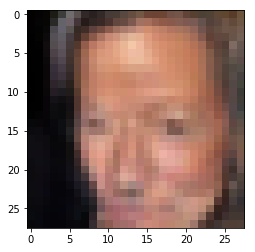

Epoch 25/25... Discriminator Loss: 1.1492... Generator Loss: 0.9073
Epoch 25/25... Discriminator Loss: 1.2387... Generator Loss: 0.7382
Epoch 25/25... Discriminator Loss: 1.4330... Generator Loss: 0.6002
Epoch 25/25... Discriminator Loss: 1.1577... Generator Loss: 0.8770


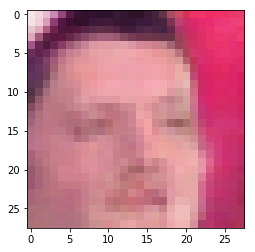

Epoch 25/25... Discriminator Loss: 1.3954... Generator Loss: 0.5860
Epoch 25/25... Discriminator Loss: 1.7381... Generator Loss: 0.5148
Epoch 25/25... Discriminator Loss: 1.6723... Generator Loss: 0.4877
Epoch 25/25... Discriminator Loss: 1.2425... Generator Loss: 0.7761


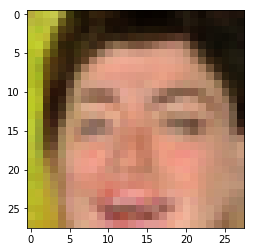

Epoch 25/25... Discriminator Loss: 1.4087... Generator Loss: 0.6057
Epoch 25/25... Discriminator Loss: 1.3373... Generator Loss: 0.7180


In [120]:
batch_size = 64 # between 32 or 64
z_dim = 100
learning_rate = 0.0002 # between 0.0002 and 0.0008
beta1 = 0.4 # between 0.2 and 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 25

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.